In [1]:
import pandas as pd
import numpy as np
from cmath import log

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy import stats,linalg
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pyinform import transferentropy
from scipy.spatial.distance import jensenshannon



In [2]:
# the column names are "Export_country", "Import_country", "Month", "Year", "Nominal Value (SUM)", "Tons (SUM)"

# Load the data from "originalData\Iron_and_steel.csv"
df = pd.read_csv("originalData\Iron_and_steel.csv")

# get all the unique values of "Export_country"
export_countries = df["Export_country"].unique()

# save the data to "finalVersion\export_countries.csv"
pd.DataFrame(export_countries).to_csv("finalVersion\export_countries.csv", index=False)

# drop the rows with "Tons (SUM)" == 0
df = df[df["Tons (SUM)"] != 0]

# calculate the price
df["Price"] = df["Nominal Value (SUM)"] / df["Tons (SUM)"]

# save the data to "finalVersion\withPrice.csv"
df.to_csv("finalVersion\withPrice.csv", index=False)

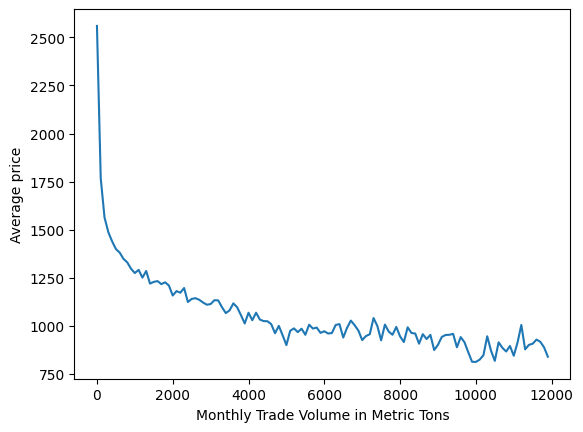

In [3]:
# load the data from the csv file# load the data from the csv file
df = pd.read_csv("finalVersion\withPrice.csv")

# arrange the data in "Tons (SUM)" in ascending order
df = df.sort_values(by="Tons (SUM)")

# calculate the average price(sum of "Nominal Value (SUM)" divided by sum of "Tons (SUM)") for each range of "Tons (SUM)" (0-1000, 1000-2000, 2000-3000, ...)
averagePrice = []

# # generate a range of "Tons (SUM)" with 1000 bins using np.linspace
# rangeOfTons_Price = np.linspace(0, 100000, 1000)

# generate a range of "Tons (SUM)"
binSize = 100
rangeOfTons_Price = range(0, 12000, binSize)
    
for i in rangeOfTons_Price:
    averagePrice.append(df[(df["Tons (SUM)"] >= i) & (df["Tons (SUM)"] < i + binSize)]["Nominal Value (SUM)"].sum() / df[(df["Tons (SUM)"] >= i) & (df["Tons (SUM)"] < i + binSize)]["Tons (SUM)"].sum())
# plot the average price for each range of "Tons (SUM)"

plt.plot(rangeOfTons_Price, averagePrice)
# plt.title("Average price for each range of 'Tons (SUM)'")
plt.xlabel("Monthly Trade Volume in Metric Tons")
plt.ylabel("Average price")
plt.show()

In [4]:
# calculate the probability of "Tons (SUM)" against different price ranges
def calculateProbability(
    df_volume_price,
    longTail=False,
    start=233,
    end=2341,
    binNum=100,
    str_price="Price",
    str_volume="Tons (SUM)",
):
    probability = []

    if longTail:
        start = np.log(start)
        end = np.log(end)
        # calculate the bin size
        binSize = (end - start) / binNum
        # generate a range of "Price"
        rangeOfPrice = np.linspace(start, end, binNum)
        # calculate the probability of "Tons (SUM)" against different price ranges
        for i in rangeOfPrice:
            probability.append(
                df_volume_price[
                    (np.log(df_volume_price[str_price]) >= i)
                    & (np.log(df_volume_price[str_price]) < i + binSize)
                ][str_volume].sum()
                / df_volume_price[str_volume].sum()
            )
    else:
        # calculate the bin size
        binSize = (end - start) / binNum
        # generate a range of "Price"
        rangeOfPrice = np.linspace(start, end, binNum)
        # calculate the probability of "Tons (SUM)" against different price ranges
        for i in rangeOfPrice:
            probability.append(
                df_volume_price[
                    (df_volume_price[str_price] >= i)
                    & (df_volume_price[str_price] < i + binSize)
                ][str_volume].sum()
                / df_volume_price[str_volume].sum()
            )
    return rangeOfPrice, probability


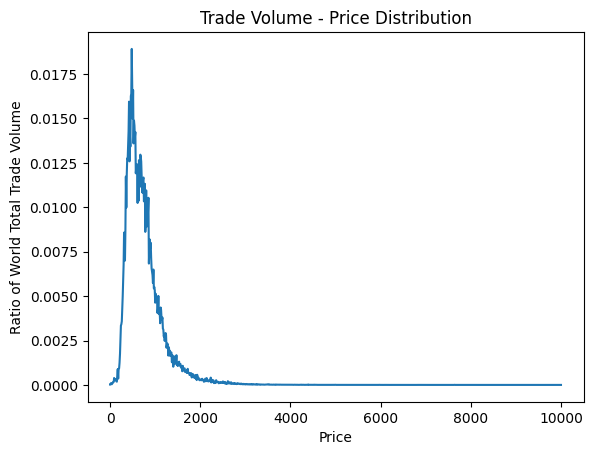

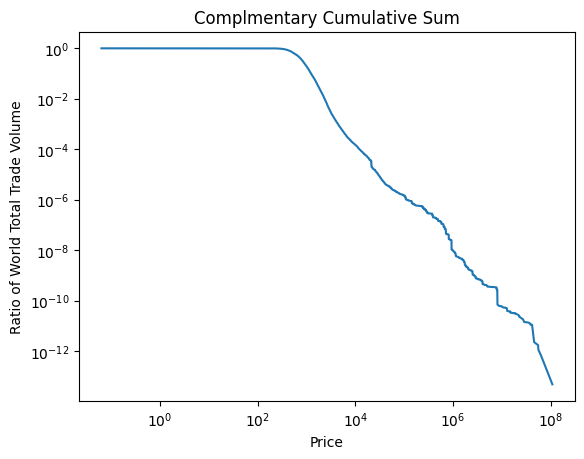

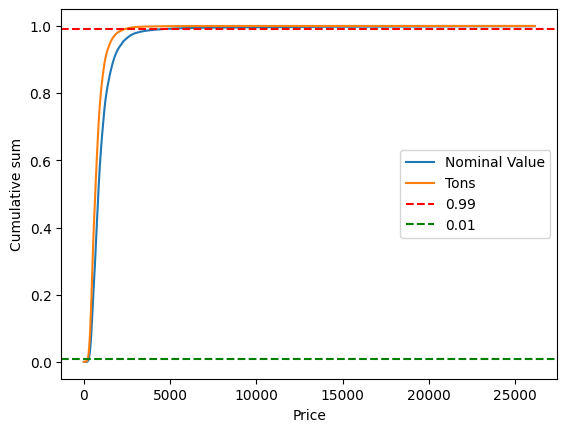

The price of the 99% of the 'Nominal Value (SUM)' is 4424.289681793392
The price of the 99% of the 'Tons (SUM)' is 2340.5674681369524
The price of the 1% of the 'Nominal Value (SUM)' is 290.9286232907862
The price of the 1% of the 'Tons (SUM)' is 233.9994470202901


In [75]:
# load the data from the csv file
df = pd.read_csv("finalVersion\withPrice.csv")

df = df.sort_values(by="Price", ascending=True)

# get the ratio of "Nominal Value (SUM)" to the total "Nominal Value (SUM)"
df["Ratio of Nominal Value (SUM)"] = df["Nominal Value (SUM)"] / df["Nominal Value (SUM)"].sum()

# get the cumulative sum of the ratio of "Nominal Value (SUM)" with different "Price"
df["Cumulative sum of ratio of Nominal Value (SUM)"] = df["Ratio of Nominal Value (SUM)"].cumsum()

# get the ratio of "Tons (SUM)" to the total "Tons (SUM)"
df["Ratio of Tons (SUM)"] = df["Tons (SUM)"] / df["Tons (SUM)"].sum()

# get the cumulative sum of the ratio of "Tons (SUM)" with different "Price"
df["Cumulative sum of ratio of Tons (SUM)"] = df["Ratio of Tons (SUM)"].cumsum()

rangeOfPrice, probability = calculateProbability(df, start=0, end=10000, binNum=1000, str_price="Price", str_volume="Tons (SUM)")
# plot the ratio of "Tons (SUM)" against different price ranges
plt.plot(rangeOfPrice, probability)
plt.title("Trade Volume - Price Distribution")
plt.xlabel("Price")
plt.ylabel("Ratio of World Total Trade Volume")
plt.show()

# plot the log of complmentary cumulative sum of ratio of "Nominal Value (SUM)" with different "Price"
plt.figure()
plt.plot(df["Price"], 1 - df["Cumulative sum of ratio of Tons (SUM)"])  
plt.title("Complmentary Cumulative Sum")
plt.xlabel("Price")
plt.ylabel("Ratio of World Total Trade Volume")
plt.xscale("log")
plt.yscale("log")
plt.show()

# plot the cumulative sum of ratio of "Nominal Value (SUM)" with different "Price" in the same figure without the last 5 rows
plt.figure()
plt.plot(df["Price"][:-20000], df["Cumulative sum of ratio of Nominal Value (SUM)"][:-20000],label = "Nominal Value")
plt.plot(df["Price"][:-20000], df["Cumulative sum of ratio of Tons (SUM)"][:-20000],label = "Tons")
# draw the line of 0.99 with label
plt.axhline(y=0.99, color='r', linestyle='--', label="0.99")
# draw the line of 0.01 with label
plt.axhline(y=0.01, color='g', linestyle='--', label="0.01")
# plt.title("Cumulative sum of ratio of 'Nominal Value (SUM)' and 'Tons (SUM)' with different 'Price'")
plt.xlabel("Price")
plt.ylabel("Cumulative sum")
plt.legend()
plt.show()

# calculate the price of the 99% of the "Nominal Value (SUM)"
price = df[df["Cumulative sum of ratio of Nominal Value (SUM)"] >= 0.99]["Price"].iloc[0]
print("The price of the 99% of the 'Nominal Value (SUM)' is", price)

# calculate the price of the 99% of the "Tons (SUM)"
price = df[df["Cumulative sum of ratio of Tons (SUM)"] >= 0.99]["Price"].iloc[0]
print("The price of the 99% of the 'Tons (SUM)' is", price)

# calculate the price of the 1% of the "Nominal Value (SUM)"
price = df[df["Cumulative sum of ratio of Nominal Value (SUM)"] >= 0.01]["Price"].iloc[0]
print("The price of the 1% of the 'Nominal Value (SUM)' is", price)

# calculate the price of the 1% of the "Tons (SUM)"
price = df[df["Cumulative sum of ratio of Tons (SUM)"] >= 0.01]["Price"].iloc[0]
print("The price of the 1% of the 'Tons (SUM)' is", price)


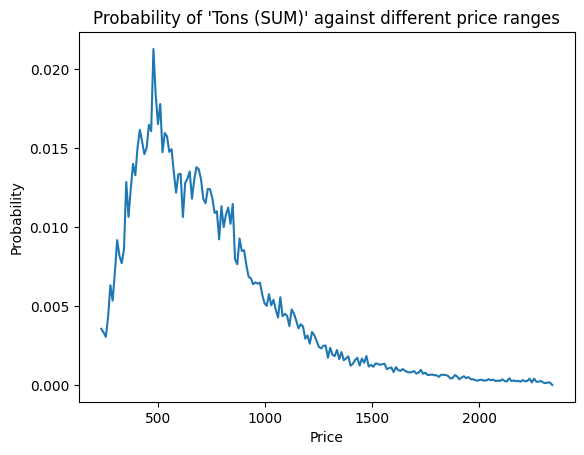

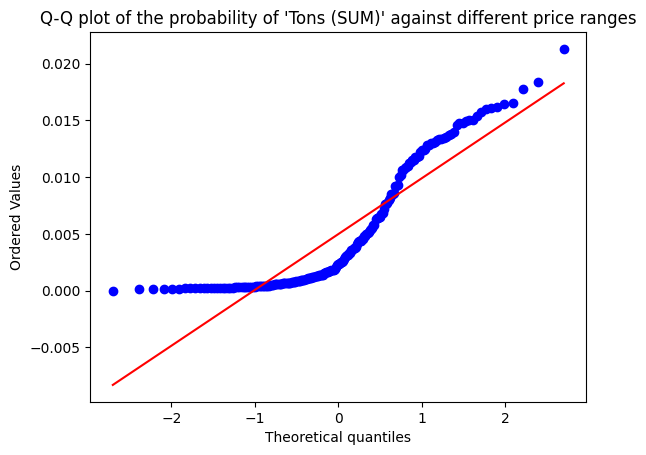

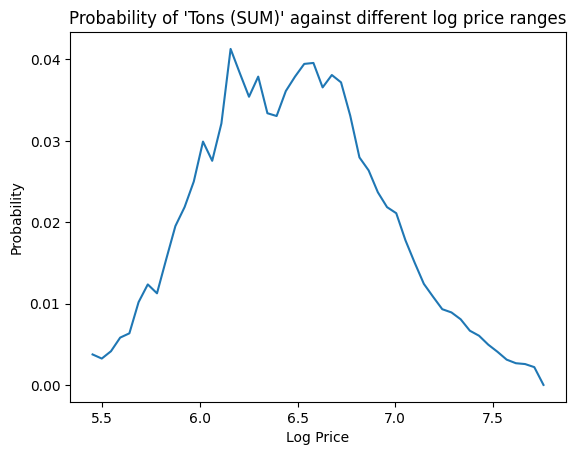

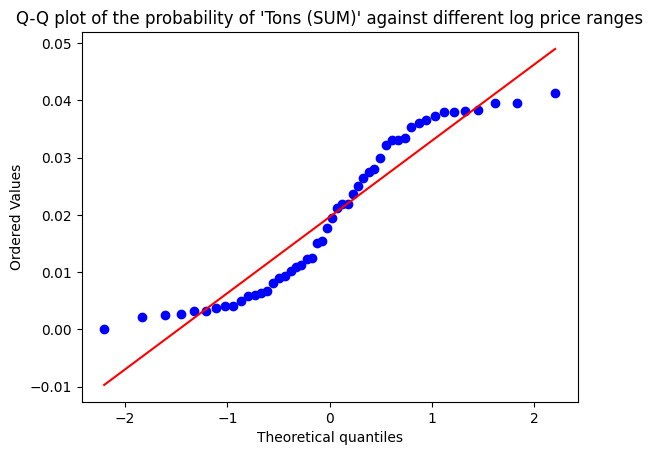

In [6]:
# load the data from the csv file
df = pd.read_csv("finalVersion\withPrice.csv")
# filter the data with "Price" between 233 and 2341
# df = df[(df["Price"] >= 233) & (df["Price"] <= 2341)]
df = df[(df["Price"] >= 233) & (df["Price"] <= 2341)]
# save the data to a new csv file
df.to_csv("finalVersion/filtered_byPrice.csv", index=False)

# calculate the probability of "Tons (SUM)" against different price ranges
rangeOfPrice, probability = calculateProbability(df,binNum=200)

# plot the probability of "Tons (SUM)" against different price ranges
plt.plot(rangeOfPrice, probability)
plt.title("Probability of 'Tons (SUM)' against different price ranges")
plt.xlabel("Price")
plt.ylabel("Probability")
plt.show()

# plot the Q-Q plot of the probability of "Tons (SUM)" against different price ranges
stats.probplot(probability, dist="norm", plot=plt)
plt.title("Q-Q plot of the probability of 'Tons (SUM)' against different price ranges")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Ordered Values")
plt.show()

# calculate the probability of "Tons (SUM)" against different log price ranges
rangeOfPrice, probability = calculateProbability(df, True,binNum=50)

# plot the probability of "Tons (SUM)" against different log price ranges
plt.plot(rangeOfPrice, probability)
# plot the normal distribution with the mean and standard deviation of the log price
plt.title("Probability of 'Tons (SUM)' against different log price ranges")
plt.xlabel("Log Price")
plt.ylabel("Probability")
plt.show()

# plot the Q-Q plot of the probability of "Tons (SUM)" against different log price ranges
stats.probplot(probability, dist="norm", plot=plt)
plt.title("Q-Q plot of the probability of 'Tons (SUM)' against different log price ranges")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Ordered Values")
plt.show()



In [7]:
# load the data from the csv file
df = pd.read_csv("finalVersion/filtered_byPrice.csv")
# group the data by "Export_country", "Import_country", "Year" and calculate the total export value and the total export volume
df = df.groupby(["Export_country", "Import_country", "Year"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# caculate the average price
df["Price"] = df["Nominal Value (SUM)"] / df["Tons (SUM)"]
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_anually.csv", index=False)

# group the data by "Export_country", "Import_country" and calculate the total export value and the total export volume
df = df.groupby(["Export_country", "Import_country"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# caculate the average price
df["Price"] = df["Nominal Value (SUM)"] / df["Tons (SUM)"]
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_decadely.csv", index=False)

# group the data by "Export_country" and calculate the total export value and the total export volume
df_exporters = df.groupby(["Export_country"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# caculate the average price
df_exporters["Price"] = df_exporters["Nominal Value (SUM)"] / df_exporters["Tons (SUM)"]
# save the data to a csv file
df_exporters.to_csv("finalVersion/filtered_byPrice_decadely_exporters.csv", index=False)

# group the data by "Import_country" and calculate the total export value and the total export volume
df_importers = df.groupby(["Import_country"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# caculate the average price
df_importers["Price"] = df_importers["Nominal Value (SUM)"] / df_importers["Tons (SUM)"]
# save the data to a csv file
df_importers.to_csv("finalVersion/filtered_byPrice_decadely_importers.csv", index=False)

# merge the data of exporters and importers
df = pd.merge(df_exporters, df_importers, left_on="Export_country", right_on="Import_country", suffixes=('_exporter', '_importer'))
# drop the column "Import_country" and rename the column "Export_country" to "Country"
df = df.drop(columns=["Import_country"])
df = df.rename(columns={"Export_country": "Country"})
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_decadely_traders.csv", index=False)

# calculate the market share of each country on both value and volume of both export and import
df["Market share of value export"] = df["Nominal Value (SUM)_exporter"] / df["Nominal Value (SUM)_exporter"].sum()
df["Market share of volume export"] = df["Tons (SUM)_exporter"] / df["Tons (SUM)_exporter"].sum()
df["Market share of value import"] = df["Nominal Value (SUM)_importer"] / df["Nominal Value (SUM)_importer"].sum()
df["Market share of volume import"] = df["Tons (SUM)_importer"] / df["Tons (SUM)_importer"].sum()
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_decadely_traders_marketShare.csv", index=False)

# load the data from the csv file
df = pd.read_csv("finalVersion/filtered_byPrice.csv")
# group the data by quarter
df["Month"] = df["Month"].apply(lambda x: int(x))
df["Quarter"] = df["Month"].apply(lambda x: (x-1)//3+1)
df = df.groupby(["Export_country", "Import_country", "Year", "Quarter"]).sum().reset_index()
# depending on the "Year" and "Quarter" add a new column "Period" with integer values starting from 1
df["Period"] = (df["Year"]-2013)*4 + df["Quarter"]
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_quarterly.csv", index=False)

df = pd.read_csv("finalVersion/filtered_byPrice_quarterly.csv")
# group the data by "Export_country" and "Period"
df = df.groupby(["Export_country", "Period"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# pivot the data with "Export_country" as index, "Period" as columns and "Nominal Value (SUM)" as values
df = df.pivot(index=["Export_country"], columns=["Period"], values=["Nominal Value (SUM)"])
# set the column names to the values of "Period"
df.columns = df.columns.get_level_values(1)
# make the value to the ratio of each country's export value in each period to the total export value in each period
df = df.div(df.sum(axis=0), axis=1)
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_quarterly_marketSharebyValue_export.csv",index=True)

df = pd.read_csv("finalVersion/filtered_byPrice_quarterly.csv")
# group the data by "Import_country" and "Period"
df = df.groupby(["Import_country", "Period"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# pivot the data with "Import_country" as index, "Period" as columns and "Nominal Value (SUM)" as values
df = df.pivot(index=["Import_country"], columns=["Period"], values=["Nominal Value (SUM)"])
# set the column names to the values of "Period"
df.columns = df.columns.get_level_values(1)
# make the value to the ratio of each country's import value in each period to the total import value in each period
df = df.div(df.sum(axis=0), axis=1)
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_quarterly_marketSharebyValue_import.csv",index=True)



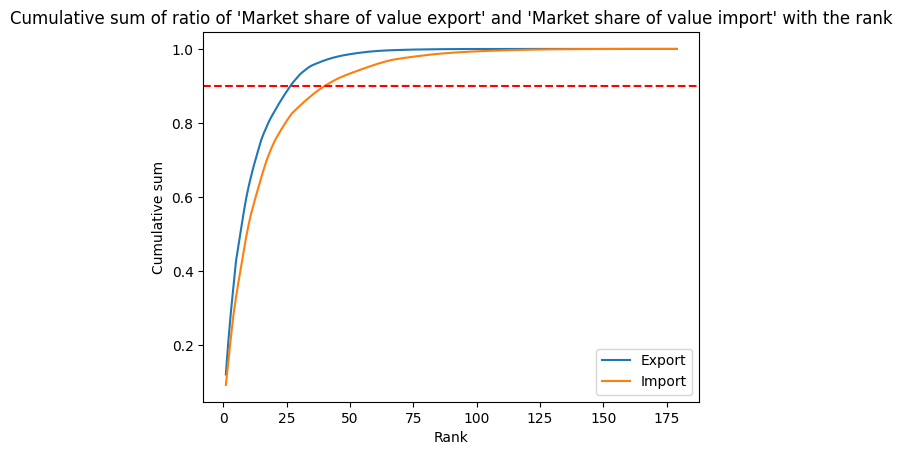

In [8]:
# load the data from the csv file
df_marketShare = pd.read_csv("finalVersion/filtered_byPrice_decadely_traders_marketShare.csv")

plt.figure()
# sort the data by "Market share of value export" in descending order
df_marketShare = df_marketShare.sort_values(by="Market share of value export", ascending=False)
# plot the cumulative sum of ratio of "Market share of value export" with the rank of "Market share of value export"
plt.plot(range(1, len(df_marketShare) + 1), df_marketShare["Market share of value export"].cumsum(),label = "Export")
# sort the data by "Market share of value import" in descending order
df_marketShare = df_marketShare.sort_values(by="Market share of value import", ascending=False)
# plot the cumulative sum of ratio of "Market share of value import" with the rank of "Market share of value import"
plt.plot(range(1, len(df_marketShare) + 1), df_marketShare["Market share of value import"].cumsum(),label = "Import")
# draw the line of 0.9
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title("Cumulative sum of ratio of 'Market share of value export' and 'Market share of value import' with the rank")
plt.xlabel("Rank")
plt.ylabel("Cumulative sum")
plt.legend()
plt.show()


# sort the data by "Market share of value export" in descending order
df_marketShare = df_marketShare.sort_values(by="Market share of value export", ascending=False)
# store the countries that make up 90% of the market share of value export in the csv file "topExporters.csv"
df_marketShare[df_marketShare["Market share of value export"].cumsum() <= 0.9].to_csv("finalVersion/topExporters.csv", index=False)

# sort the data by "Market share of value import" in descending order
df_marketShare = df_marketShare.sort_values(by="Market share of value import", ascending=False)
# store the countries that make up 90% of the market share of value import in the csv file "topImporters.csv"
df_marketShare[df_marketShare["Market share of value import"].cumsum() <= 0.9].to_csv("finalVersion/topImporters.csv", index=False)

In [9]:
# load the top exporters
topExporters = pd.read_csv("finalVersion/topExporters.csv")

# load the data from the csv file
df_original = pd.read_csv("finalVersion/filtered_byPrice.csv")
# filter the data with the top exporters
df_export = df_original[df_original["Export_country"].isin(topExporters["Country"])]
df_import = df_original[df_original["Import_country"].isin(topExporters["Country"])]
df_export.to_csv("finalVersion/filtered_byPrice_bytopExporters_export.csv", index=False)
df_import.to_csv("finalVersion/filtered_byPrice_bytopExporters_import.csv", index=False)

# load the data from the csv file
df = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_export.csv")
# group the data by quarter
df["Month"] = df["Month"].apply(lambda x: int(x))
df["Quarter"] = df["Month"].apply(lambda x: (x-1)//3+1)
df = df.groupby(["Export_country", "Import_country", "Year", "Quarter"]).sum().reset_index()
# depending on the "Year" and "Quarter" add a new column "Period" with integer values starting from 1
df["Period"] = (df["Year"]-2013)*4 + df["Quarter"]
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_bytopExporters_quarterly_export.csv", index=False)

df["Period_Month"] = (df["Year"]-2013)*12 + df["Month"]
df.to_csv("finalVersion/filtered_byPrice_bytopExporters_monthly_export.csv", index=False)

df = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_monthly_export.csv")
# group the data by "Export_country" and "Period_Month"
df = df.groupby(["Export_country", "Period_Month"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# pivot the data with "Export_country" as index, "Period_Month" as columns and "Tons (SUM)" as values
df = df.pivot(index=["Export_country"], columns=["Period_Month"], values=["Tons (SUM)"])
# set the column names to the values of "Period"
df.columns = df.columns.get_level_values(1)
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_bytopExporters_monthly_exportVolume.csv",index=True)

df = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_quarterly_export.csv")
# group the data by "Export_country" and "Period"
df = df.groupby(["Export_country", "Period"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# pivot the data with "Export_country" as index, "Period" as columns and "Nominal Value (SUM)" as values
df = df.pivot(index=["Export_country"], columns=["Period"], values=["Nominal Value (SUM)"])
# set the column names to the values of "Period"
df.columns = df.columns.get_level_values(1)
# make the value to the ratio of each country's export value in each period to the total export value in each period
df = df.div(df.sum(axis=0), axis=1)
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_bytopExporters_quarterly_marketSharebyValue_export.csv",index=True)

df = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_quarterly_export.csv")
# group the data by "Export_country" and "Period"
df = df.groupby(["Export_country", "Period"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# pivot the data with "Export_country" as index, "Period" as columns and "Tons (SUM)" as values
df = df.pivot(index=["Export_country"], columns=["Period"], values=["Tons (SUM)"])
# set the column names to the values of "Period"
df.columns = df.columns.get_level_values(1)
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_bytopExporters_quarterly_exportVolume.csv",index=True)

# load the data from the csv file
df = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_import.csv")
# group the data by quarter
df["Month"] = df["Month"].apply(lambda x: int(x))
df["Quarter"] = df["Month"].apply(lambda x: (x-1)//3+1)
df = df.groupby(["Export_country", "Import_country", "Year", "Quarter"]).sum().reset_index()
# depending on the "Year" and "Quarter" add a new column "Period" with integer values starting from 1
df["Period"] = (df["Year"]-2013)*4 + df["Quarter"]
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_bytopExporters_quarterly_import.csv", index=False)

df = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_quarterly_import.csv")
# group the data by "Import_country" and "Period"
df = df.groupby(["Import_country", "Period"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# pivot the data with "Import_country" as index, "Period" as columns and "Nominal Value (SUM)" as values
df = df.pivot(index=["Import_country"], columns=["Period"], values=["Nominal Value (SUM)"])
# set the column names to the values of "Period"
df.columns = df.columns.get_level_values(1)
# make the value to the ratio of each country's import value in each period to the total import value in each period
df = df.div(df.sum(axis=0), axis=1)
# save the data to a csv file
df.to_csv("finalVersion/filtered_byPrice_bytopExporters_quarterly_marketSharebyValue_import.csv",index=True)


In [10]:
# load the top exporters
topExporters = pd.read_csv("finalVersion/topExporters.csv")

# load the data from the csv file
df_original = pd.read_csv("finalVersion/filtered_byPrice.csv")

# find the name of each topExporters' top 10 trading partners
topExporters_top10 = []
for exporter in topExporters["Country"]:
    df_export = df_original[df_original["Export_country"] == exporter]
    df_export = df_export.groupby(["Import_country"]).agg({"Nominal Value (SUM)": "sum"}).reset_index()
    df_export = df_export.sort_values(by="Nominal Value (SUM)", ascending=False)
    topExporters_top10.append(df_export["Import_country"].head(10).values)
# set the index to the name of the topExporters
topExporters_top10 = pd.DataFrame(topExporters_top10, index=topExporters["Country"])
# save the data to a csv file
pd.DataFrame(topExporters_top10).to_csv("finalVersion/topExporters_top10.csv", index=True)






(43, 26)
Export_country   Austria   Belgium    Brazil    Canada  China (mainland)  \
0                    NaN       NaN       NaN       NaN               NaN   
1               0.004043  0.018595  0.072392  0.000518          0.002104   
2               0.002432  0.000333  0.001494  0.009312          0.009489   
3               0.009107  0.000001  0.081720  0.003355          0.012253   
4               0.031563  0.011917  0.048063  0.004911          0.057298   

Export_country    France   Germany     India  Indonesia      Iran  ...  \
0                    NaN       NaN       NaN        NaN       NaN  ...   
1               0.014034  0.006030  0.000054   0.609344  1.451235  ...   
2               0.015082  0.017925  0.029264   0.466380  0.005723  ...   
3               0.007909  0.000321  0.059956   2.230821  0.013040  ...   
4               0.028880  0.006270  0.005917   0.037843  0.358926  ...   

Export_country  Slovakia  South Africa  South Korea     Spain    Sweden  \
0             

C:\Users\25726\AppData\Local\Temp\ipykernel_21668\1460661647.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataframe_countryPair_diff.iloc[i,j] = average[i] - average[j]


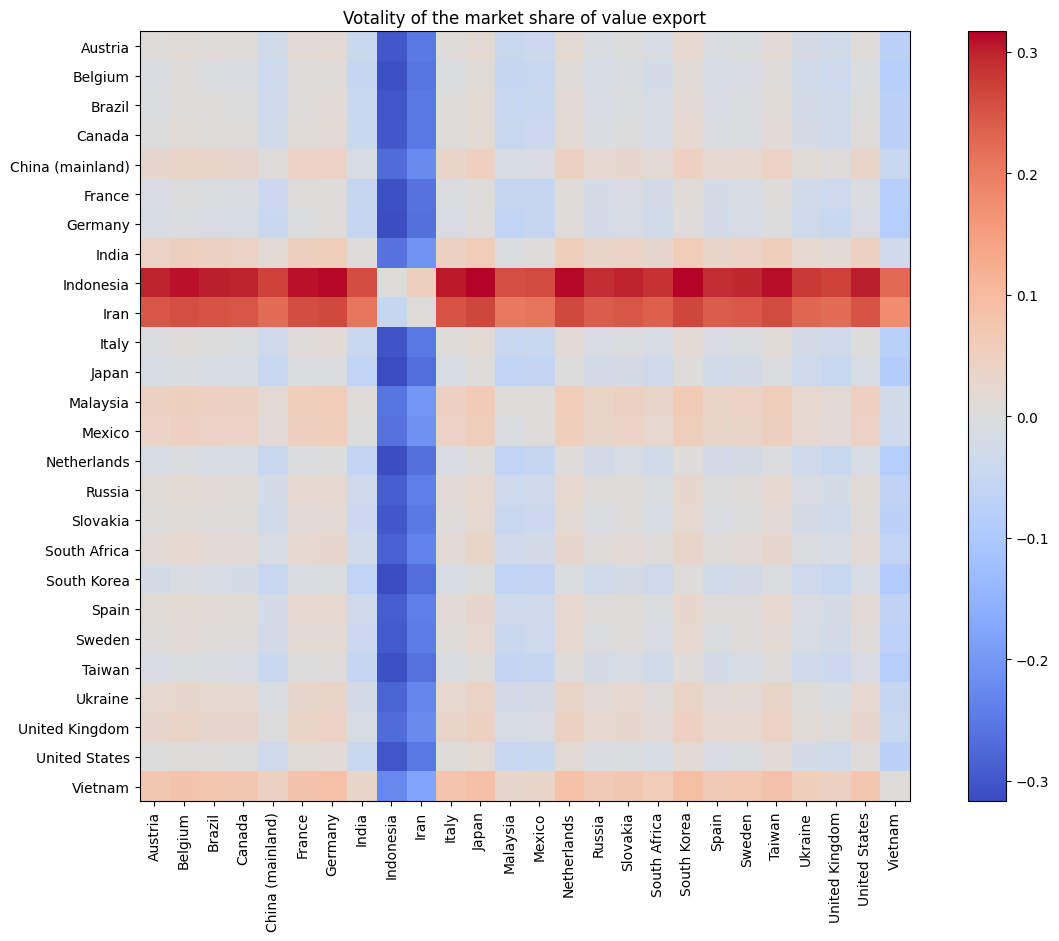

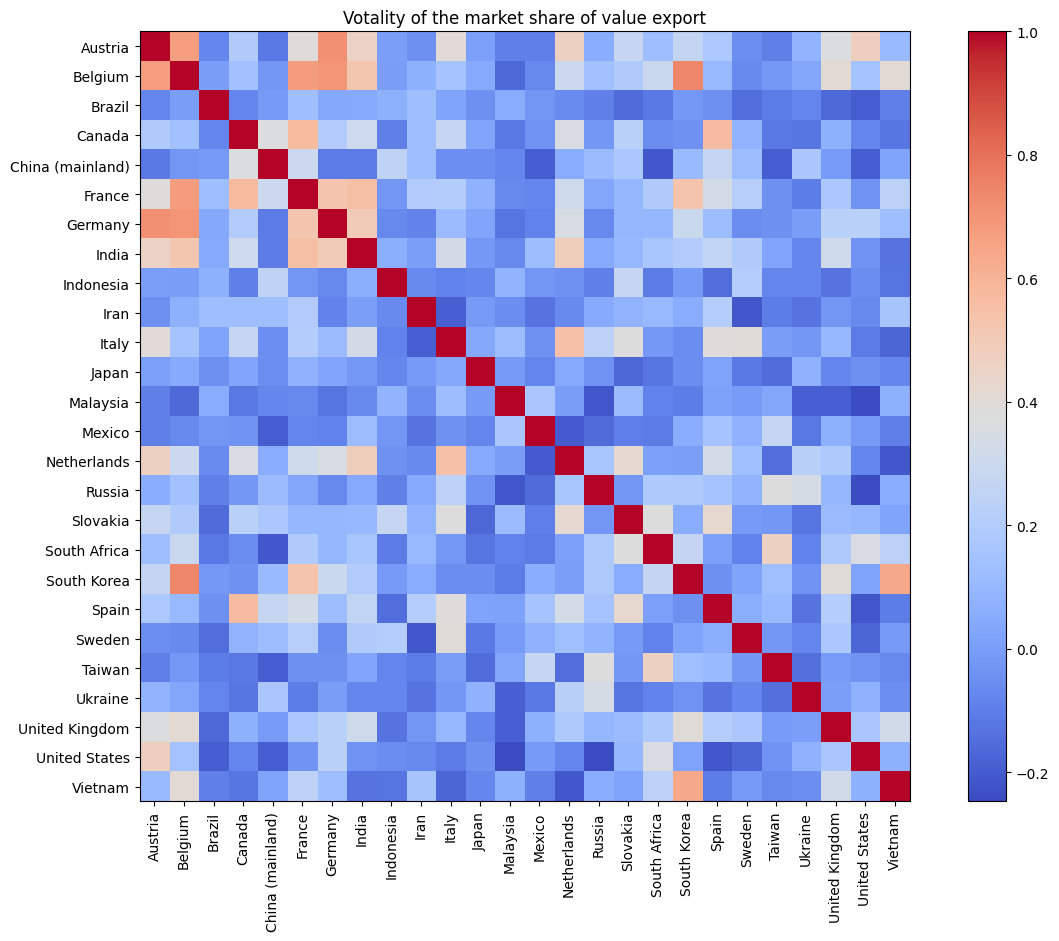

C:\Users\25726\AppData\Local\Temp\ipykernel_21668\1460661647.py:83: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df_marketShare_export_diff = df_marketShare_export.pct_change()


(136, 26)
Export_country     Austria       Belgium     Brazil      Canada  \
0                      NaN           NaN        NaN         NaN   
1                 0.957521      0.974796   0.968531    0.959597   
2                 0.116871  28604.017326  58.938412    8.876351   
3               175.221031      0.097149   0.070197   43.905068   
4                 0.011182      0.251708   0.262113  705.870046   

Export_country  China (mainland)     France    Germany      India  \
0                            NaN        NaN        NaN        NaN   
1                       0.744620  29.731163   0.500441   0.097708   
2                     120.485279   0.709296   2.246591  18.454516   
3                       0.395532   0.057739  13.625026   0.008769   
4                       2.937292   0.688717   0.069432  36.050587   

Export_country    Indonesia        Iran  ...    Slovakia  South Africa  \
0                       NaN         NaN  ...         NaN           NaN   
1                 93.803

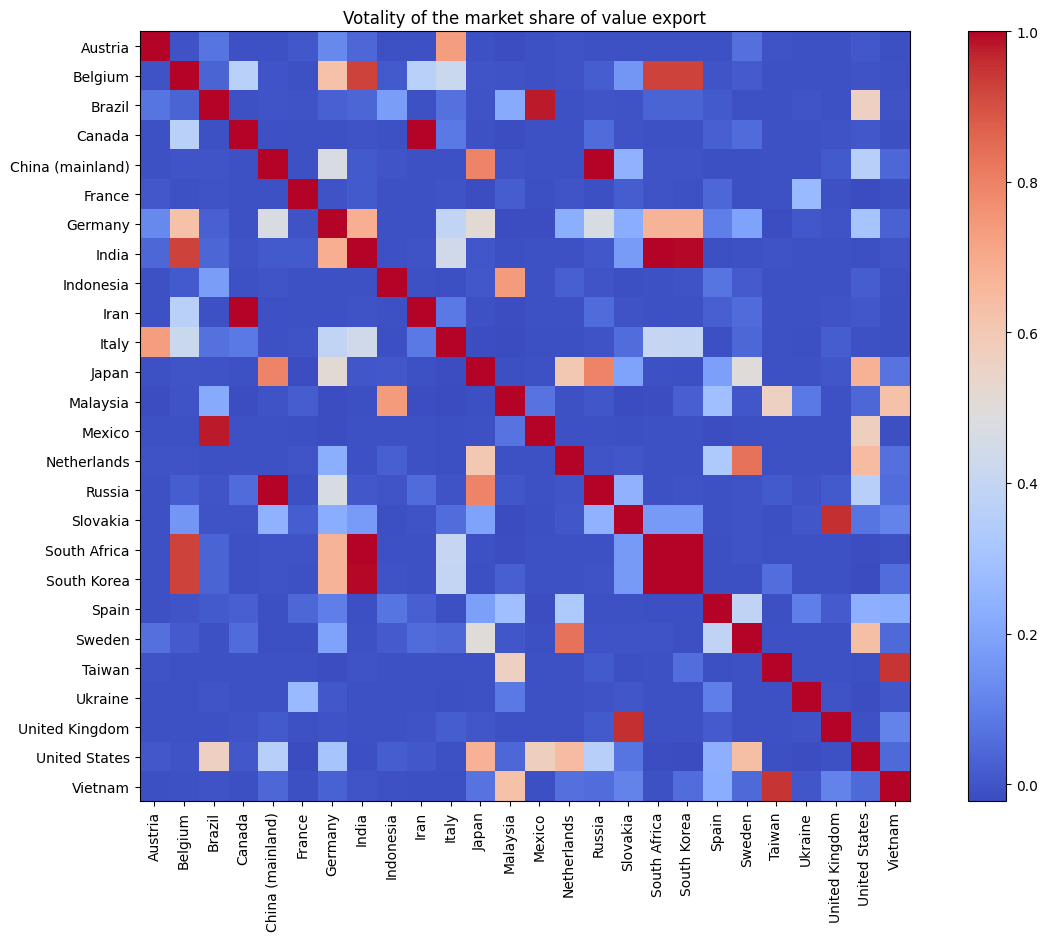

In [11]:
# load the data from the csv file
df_marketShare = pd.read_csv(
    "finalVersion/filtered_byPrice_bytopExporters_quarterly_exportVolume.csv"
)

# set the first column as index
df_marketShare = df_marketShare.set_index(df_marketShare.columns[0])
# transpose the data
df_marketShare = df_marketShare.transpose()
# reset the index
df_marketShare = df_marketShare.reset_index(drop=True)

# drop the last row
df_marketShare_export = df_marketShare.drop(df_marketShare.index[-1])
# print(df_marketShare_export.shape)

# calculate the percentage difference between each period and the previous period
df_marketShare_export_diff = df_marketShare_export.pct_change()
# square the percentage difference
df_marketShare_export_diff_abs = df_marketShare_export_diff ** 2
print(df_marketShare_export_diff_abs.shape)
print(df_marketShare_export_diff_abs.head())
df_marketShare_export_diff_abs.dropna(inplace=True)
# print(df_marketShare_export_diff_abs.shape)
# print(df_marketShare_export_diff_abs.head())

# caculate the average of the percentage difference between each period and the previous period
average = df_marketShare_export_diff_abs.mean()
print(average)
# caculate the difference
dataframe_countryPair_diff = pd.DataFrame(np.zeros((len(average), len(average))))
for i in range(len(average)):
    for j in range(len(average)):
        dataframe_countryPair_diff.iloc[i,j] = average[i] - average[j]
# set the index and columns to the name of the countries
dataframe_countryPair_diff.index = df_marketShare_export_diff_abs.columns
dataframe_countryPair_diff.columns = df_marketShare_export_diff_abs.columns
# plot the difference
plt.figure(figsize=(15, 10))
plt.imshow(dataframe_countryPair_diff, cmap="coolwarm", interpolation="nearest")
# set the xticks and yticks
plt.xticks(range(len(df_marketShare_export.columns)), df_marketShare_export.columns, rotation=90)
plt.yticks(range(len(df_marketShare_export.columns)), df_marketShare_export.columns)
# plt.title("Difference of the average of the percentage difference between each period and the previous period")
plt.title("Votality of the market share of value export")
plt.colorbar()
plt.show()

        


# caculate the correlation matrix
correlationMatrix = df_marketShare_export_diff_abs.corr()

# plot the correlation matrix
plt.figure(figsize=(15, 10))
plt.imshow(correlationMatrix, cmap="coolwarm", interpolation="nearest")
# set the xticks and yticks
plt.xticks(range(len(df_marketShare_export.columns)), df_marketShare_export.columns, rotation=90)   
plt.yticks(range(len(df_marketShare_export.columns)), df_marketShare_export.columns)
# plt.title("Correlation matrix of the percentage difference between each period and the previous period")
plt.title("Votality of the market share of value export")
plt.colorbar()
plt.show()

# load the data from the csv file
df_marketShare = pd.read_csv(
    "finalVersion/filtered_byPrice_bytopExporters_monthly_exportVolume.csv"
)

# set the first column as index
df_marketShare = df_marketShare.set_index(df_marketShare.columns[0])
# transpose the data
df_marketShare = df_marketShare.transpose()
# reset the index
df_marketShare = df_marketShare.reset_index(drop=True)

# drop the last row
df_marketShare_export = df_marketShare.drop(df_marketShare.index[-1])
# print(df_marketShare_export.shape)

# calculate the percentage difference between each period and the previous period
df_marketShare_export_diff = df_marketShare_export.pct_change()
# square the percentage difference
df_marketShare_export_diff_abs = df_marketShare_export_diff ** 2
print(df_marketShare_export_diff_abs.shape)
print(df_marketShare_export_diff_abs.head())
df_marketShare_export_diff_abs.dropna(inplace=True)
# print(df_marketShare_export_diff_abs.shape)
# print(df_marketShare_export_diff_abs.head())

# caculate the correlation matrix
correlationMatrix = df_marketShare_export_diff_abs.corr()

# plot the correlation matrix
plt.figure(figsize=(15, 10))
plt.imshow(correlationMatrix, cmap="coolwarm", interpolation="nearest")
# set the xticks and yticks
plt.xticks(range(len(df_marketShare_export.columns)), df_marketShare_export.columns, rotation=90)
plt.yticks(range(len(df_marketShare_export.columns)), df_marketShare_export.columns)
# plt.title("Correlation matrix of the percentage difference between each period and the previous period")
plt.title("Votality of the market share of value export")
plt.colorbar()
plt.show()



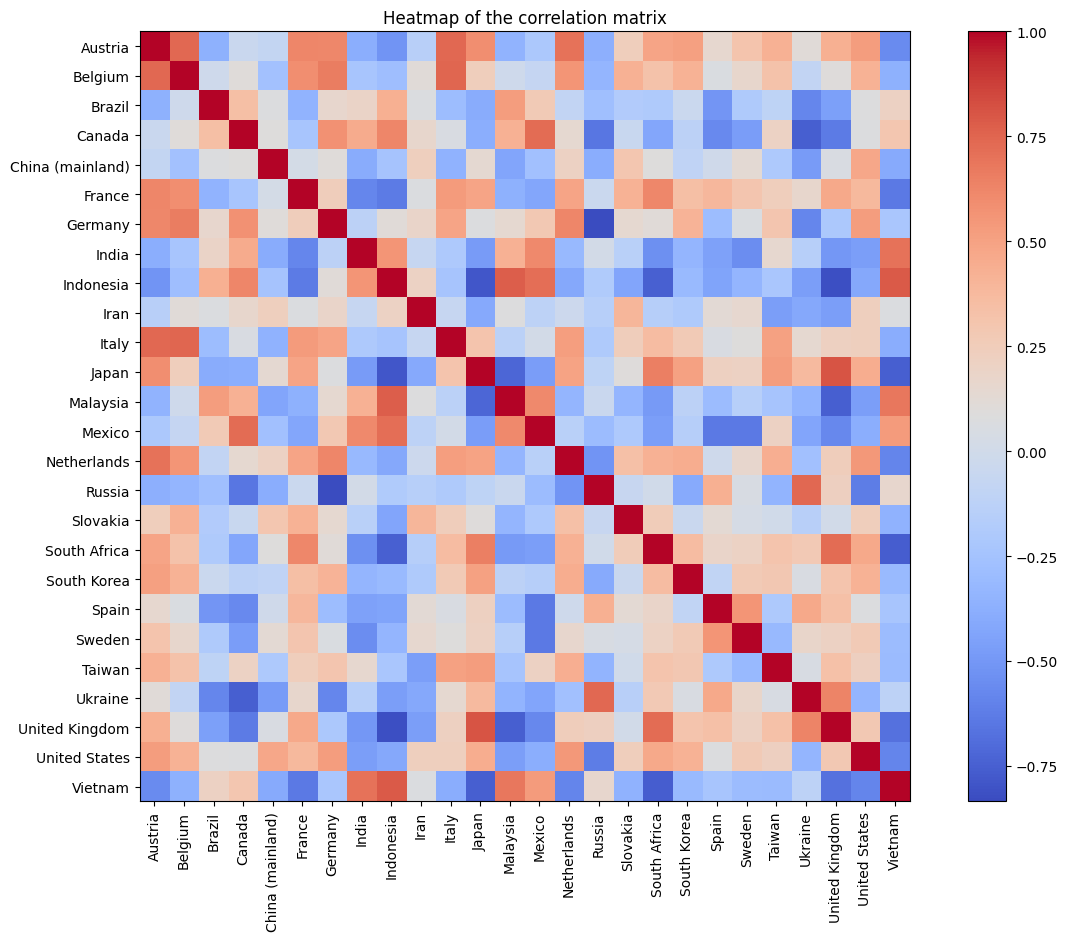

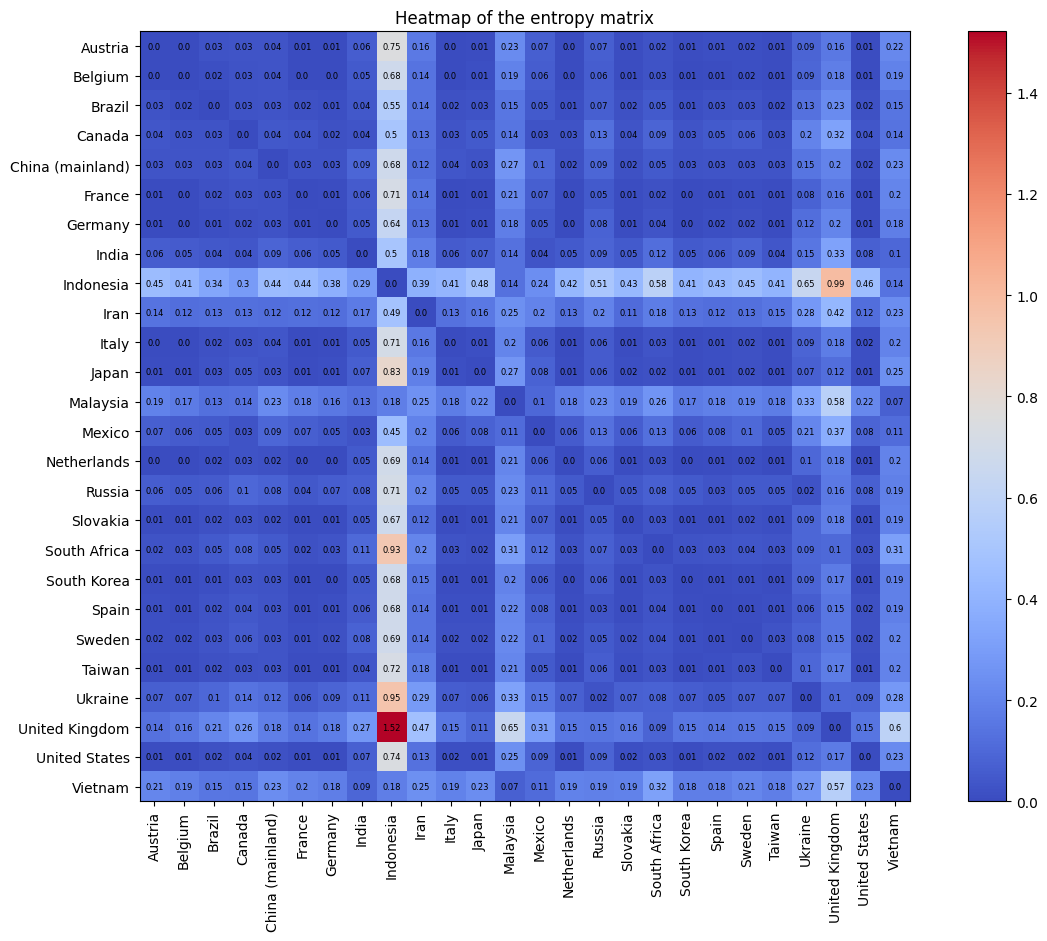

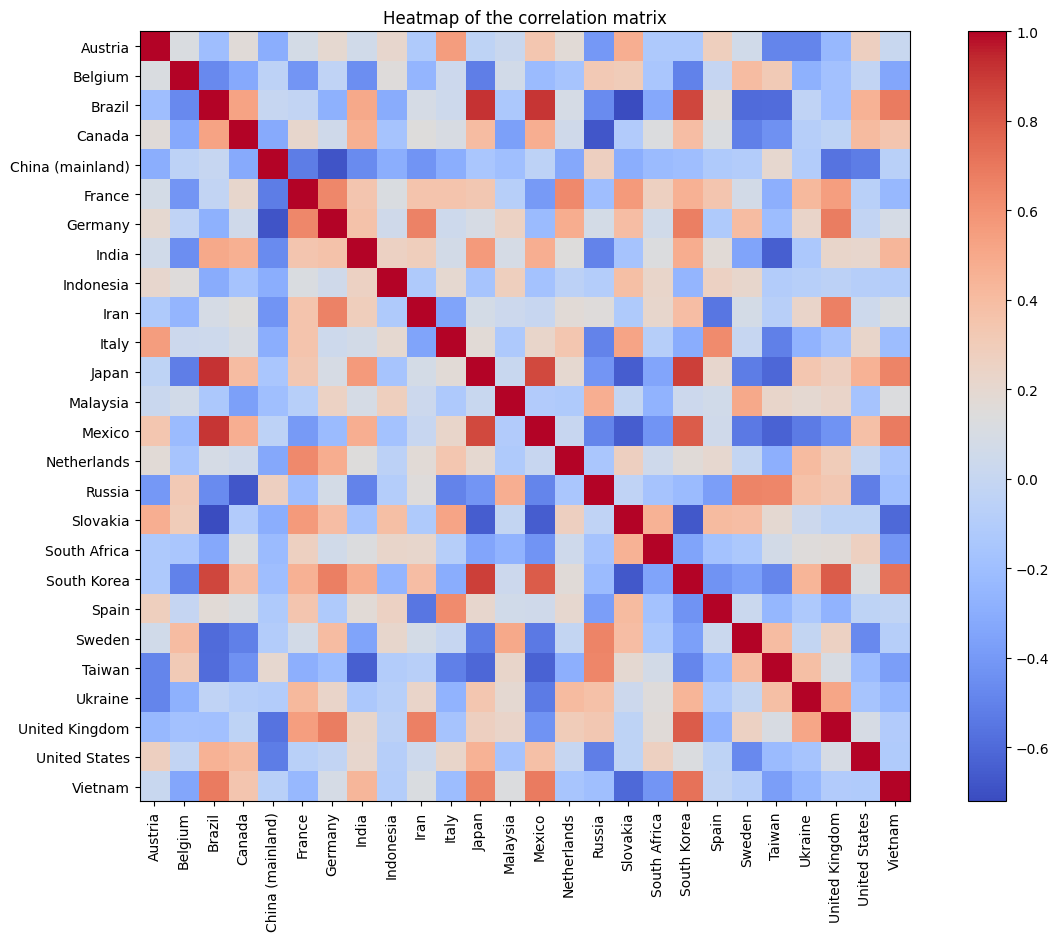

Export_country   Austria   Belgium    Brazil    Canada  China (mainland)  \
0               0.022072  0.059216  0.048644  0.014662          0.093703   
1               0.021254  0.051252  0.039183  0.014258          0.102171   
2               0.021481  0.050485  0.038241  0.014540          0.109706   
3               0.019337  0.049503  0.046674  0.014297          0.097343   
4               0.020896  0.051497  0.035144  0.015547          0.108095   

Export_country    France   Germany     India  Indonesia      Iran  ...  \
0               0.041662  0.077184  0.036192   0.000754  0.002041  ...   
1               0.037388  0.081050  0.036486   0.001122  0.003978  ...   
2               0.041897  0.075648  0.040553   0.000485  0.004210  ...   
3               0.039612  0.073355  0.046295   0.001011  0.003841  ...   
4               0.041104  0.076040  0.040304   0.000935  0.005614  ...   

Export_country  Slovakia  South Africa  South Korea     Spain    Sweden  \
0               0.01437

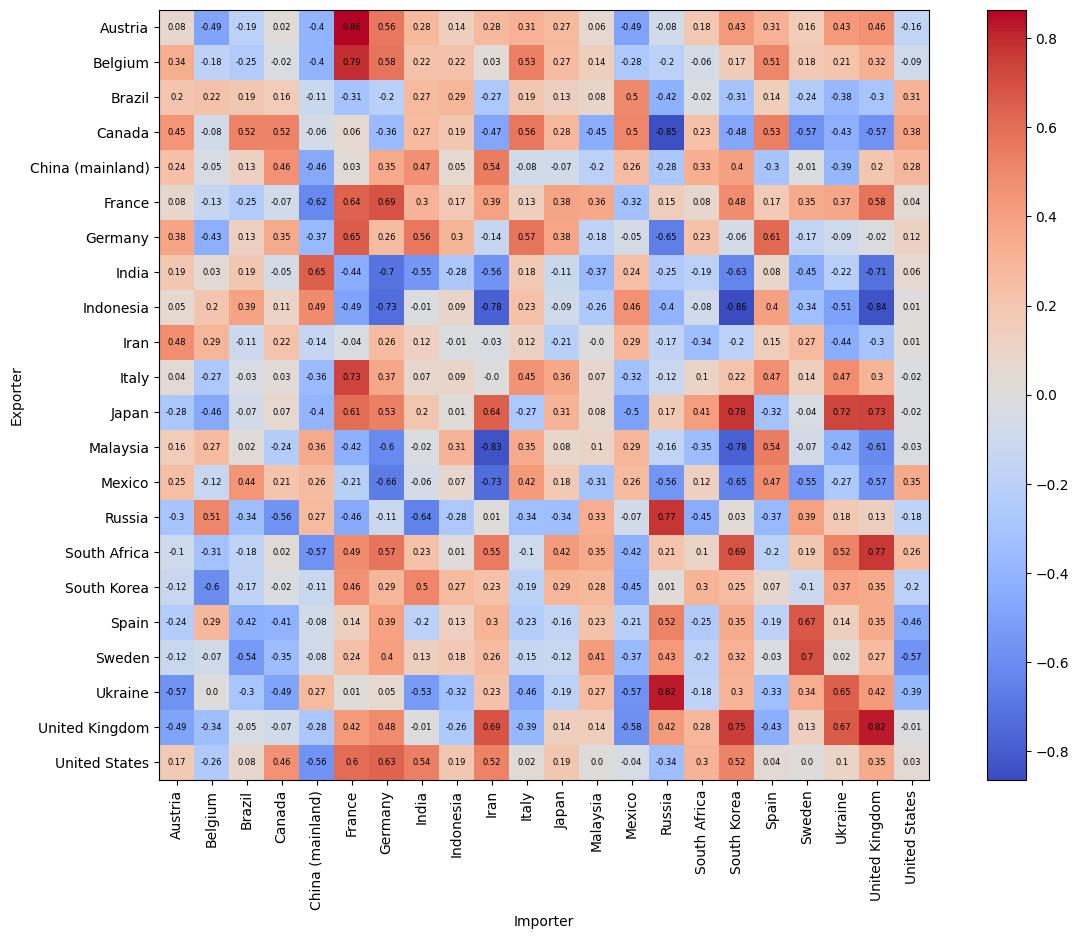

In [51]:
# load the data from the csv file
df_marketShare = pd.read_csv(
    "finalVersion/filtered_byPrice_bytopExporters_quarterly_marketSharebyValue_export.csv"
)

# set the first column as index
df_marketShare = df_marketShare.set_index(df_marketShare.columns[0])
# transpose the data
df_marketShare = df_marketShare.transpose()
# reset the index
df_marketShare = df_marketShare.reset_index(drop=True)

# drop the last row
df_marketShare_export = df_marketShare.drop(df_marketShare.index[-1])

correlationMatrix = df_marketShare_export.corr()
# save the data to a csv file
correlationMatrix.to_csv("finalVersion/correlationMatrix.csv", index=False)

# plot the correlation matrix
# plot the heatmap of the correlation matrix(triangle matrix)
plt.figure(figsize=(15, 10))
plt.imshow(correlationMatrix, cmap="coolwarm", interpolation="nearest")
plt.xticks(np.arange(len(correlationMatrix)), correlationMatrix.columns, rotation=90)
plt.yticks(np.arange(len(correlationMatrix)), correlationMatrix.columns)
plt.colorbar()
plt.title("Heatmap of the correlation matrix")
plt.show()

# plot the matrix calculating the entropy of the export market share between each pair of countries
# calculate the entropy matrix
len_df_marketShare_export = df_marketShare_export.shape[1]
entropyMatrix = np.zeros((len_df_marketShare_export, len_df_marketShare_export))
for i in range(len_df_marketShare_export):
    for j in range(len_df_marketShare_export):
        entropyMatrix[i, j] = stats.entropy(df_marketShare_export.iloc[:,i], df_marketShare_export.iloc[:,j])
# plot the heatmap of the entropy matrix(triangle matrix) with labled values
plt.figure(figsize=(15, 10))
plt.imshow(entropyMatrix, cmap="coolwarm", interpolation="nearest")
plt.xticks(np.arange(len_df_marketShare_export), correlationMatrix.columns, rotation=90)
plt.yticks(np.arange(len_df_marketShare_export), correlationMatrix.columns)
for i in range(len(entropyMatrix)):
    for j in range(len(entropyMatrix)):
        plt.text(j, i, round(entropyMatrix[i, j], 2), ha="center", va="center", color="black", fontsize=6)
plt.colorbar()
plt.title("Heatmap of the entropy matrix")
plt.show()

# # plot the transfer entropy matrix between each pair of countries
# # calculate the transfer entropy matrix
# print("df_marketShare_export.iloc[:,i]:", df_marketShare_export.iloc[:,i])
# transferEntropyMatrix = np.zeros((len_df_marketShare_export, len_df_marketShare_export))
# for i in range(len_df_marketShare_export):
#     for j in range(len_df_marketShare_export):
#         transferEntropyMatrix[i, j] = transferentropy.transfer_entropy(df_marketShare_export.iloc[:,i], df_marketShare_export.iloc[:,j], k=2)
# # plot the heatmap of the transfer entropy matrix(triangle matrix) with labled values
# plt.figure(figsize=(15, 10))
# plt.imshow(transferEntropyMatrix, cmap="coolwarm", interpolation="nearest")
# plt.xticks(np.arange(len_df_marketShare_export), correlationMatrix.columns, rotation=90)
# plt.yticks(np.arange(len_df_marketShare_export), correlationMatrix.columns)
# for i in range(len(transferEntropyMatrix)):
#     for j in range(len(transferEntropyMatrix)):
#         plt.text(j, i, round(transferEntropyMatrix[i, j], 2), ha="center", va="center", color="black", fontsize=6)
# plt.colorbar()
# plt.title("Heatmap of the transfer entropy matrix")
# plt.show()

# # plot the precision matrix
# # calculate the precision matrix
# covarianceMatrix = df_marketShare_export.cov()
# precisionMatrix = linalg.inv(covarianceMatrix)
# print(covarianceMatrix)
# # plot the heatmap of the precision matrix(triangle matrix) with labled values
# plt.figure(figsize=(15, 10))
# plt.imshow(precisionMatrix, cmap="coolwarm", interpolation="nearest")
# plt.xticks(np.arange(len(precisionMatrix)), correlationMatrix.columns, rotation=90)
# plt.yticks(np.arange(len(precisionMatrix)), correlationMatrix.columns)
# for i in range(len(precisionMatrix)):
#     for j in range(len(precisionMatrix)):
#         plt.text(j, i, round(precisionMatrix[i, j], 2), ha="center", va="center", color="black")
# plt.colorbar()
# plt.title("Heatmap of the precision matrix")
# plt.show()

# load the data from the csv file
df = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_quarterly_marketSharebyValue_import.csv")
# set the first column as index
df = df.set_index(df.columns[0])
# transpose the data
df = df.transpose()
# reset the index
df_marketShare_import = df.reset_index(drop=True)

correlationMatrix = df_marketShare_import.corr()
# save the data to a csv file
correlationMatrix.to_csv("finalVersion/correlationMatrix_import.csv", index=False)

# plot the correlation matrix
# plot the heatmap of the correlation matrix(triangle matrix)
plt.figure(figsize=(15, 10))
plt.imshow(correlationMatrix, cmap="coolwarm", interpolation="nearest")
plt.xticks(np.arange(len(correlationMatrix)), correlationMatrix.columns, rotation=90)
plt.yticks(np.arange(len(correlationMatrix)), correlationMatrix.columns)
plt.colorbar()
plt.title("Heatmap of the correlation matrix")
plt.show()

# load the both data from the csv file
df_export = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_quarterly_marketSharebyValue_export.csv")
df_import = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_quarterly_marketSharebyValue_import.csv")

# get the correlation matrix of:
# the first country's export value in each period to the rest countries' import value in each period
# the second country's export value in each period to the rest countries' import value in each period
# ...

# 假设df_marketShare_export和df_marketShare_import已经按时间顺序对齐，并且行数相同。
print(df_marketShare_export.head())
# drop the columes with "Taiwan","Netherlands","Vietnam","Slovakia"
df_marketShare_export = df_marketShare_export.drop(columns=["Taiwan","Netherlands","Vietnam","Slovakia"])
df_marketShare_import = df_marketShare_import.drop(columns=["Taiwan","Netherlands","Vietnam","Slovakia"])

# 创建一个空的DataFrame来存储相关系数
correlationMatrix = pd.DataFrame(index=df_marketShare_export.columns, columns=df_marketShare_import.columns)


# 计算两个DataFrame所有列之间的相关系数
for export_col in df_marketShare_export:
    for import_col in df_marketShare_import:
        # 计算单个列对之间的相关性
        correlation = df_marketShare_export[export_col].corr(df_marketShare_import[import_col])
        # 将结果赋值到相关系数矩阵中相应的位置
        correlationMatrix.at[export_col, import_col] = correlation

# 保存相关系数矩阵到csv文件
correlationMatrix.to_csv("finalVersion/correlationMatrix_export_import.csv", index=True)

# 转换相关系数矩阵中的数据类型为float，以便可以绘制
correlationMatrix = correlationMatrix.astype(float)

# 绘制热图
plt.figure(figsize=(15, 10))
plt.imshow(correlationMatrix, cmap="coolwarm", interpolation="nearest")
# label the data
for i in range(len(correlationMatrix)):
    for j in range(len(correlationMatrix)):
        plt.text(j, i, round(correlationMatrix.iloc[i, j], 2), ha="center", va="center", color="black",fontsize=6)
plt.xticks(np.arange(len(correlationMatrix.columns)), correlationMatrix.columns, rotation=90)
plt.yticks(np.arange(len(correlationMatrix.index)), correlationMatrix.index)
plt.xlabel("Importer")
plt.ylabel("Exporter")
plt.colorbar()
# plt.title("Heatmap of the correlation matrix")
plt.show()


In [13]:
# # load the data from the csv file
# df = pd.read_csv("finalVersion/correlationMatrix_export_import.csv")
# # set the first column as index
# df = df.set_index(df.columns[0])
# # drop the first row
# df = df.drop(df.index[0])
# # reset the index
# df = df.reset_index(drop=True)
# df = df.astype(float)

# # calculate the euclidean distance between each pair of countries' correlation matrix
# # create an empty DataFrame to store the euclidean distance
# euclideanDistance = pd.DataFrame(index=df.columns, columns=df.columns)

# # calculate the euclidean distance between each pair of countries' correlation matrix
# for country1 in df.columns:
#     for country2 in df.columns:
#         # calculate the euclidean distance between the correlation matrix of country1 and country2
#         # distance = np.linalg.norm(df[country1] - df[country2])
#         distance = stats.entropy(df[country1], df[country2])
#         # store the distance in the DataFrame
#         euclideanDistance.at[country1, country2] = distance

# euclideanDistance = euclideanDistance.astype(float)

# # plot the heatmap of the euclidean distance
# plt.figure(figsize=(15, 10))
# plt.imshow(euclideanDistance, cmap="coolwarm", interpolation="nearest")
# plt.xticks(np.arange(len(euclideanDistance.columns)), euclideanDistance.columns, rotation=90)
# plt.yticks(np.arange(len(euclideanDistance.index)), euclideanDistance.index)
# plt.colorbar()
# plt.title("Heatmap of the euclidean distance")
# plt.show()

# # get the potential trading competitors for each country if the euclidean distance is less than 0.5
# # create an empty DataFrame to store the potential trading competitors
# potentialCompetitors = pd.DataFrame(index=df.columns, columns=df.columns)

# # get the potential trading competitors for each country if the euclidean distance is less than 0.5
# for country1 in df.columns:
#     for country2 in df.columns:
#         # if the euclidean distance between country1 and country2 is less than 0.5
#         if (euclideanDistance.at[country1, country2] < 1) & (country1 != country2):
#             # store 1 in the DataFrame
#             potentialCompetitors.at[country1, country2] = 1.0
#         else:
#             # store 0 in the DataFrame
#             potentialCompetitors.at[country1, country2] = 0.0
# # plot the heatmap of the potential trading competitors
# plt.figure(figsize=(15, 10))
# plt.imshow(potentialCompetitors.astype(float), cmap="coolwarm", interpolation="nearest")
# plt.xticks(np.arange(len(potentialCompetitors.columns)), potentialCompetitors.columns, rotation=90)
# plt.yticks(np.arange(len(potentialCompetitors.index)), potentialCompetitors.index)
# plt.title("Heatmap of the potential trading competitors")
# plt.show()

# # save the data to a csv file
# potentialCompetitors.to_csv("finalVersion/potentialCompetitors.csv", index=True)



In [14]:
# # load the data from the csv file
# df_competitors = pd.read_csv("finalVersion/potentialCompetitors.csv")
# print(df_competitors.shape)
# print(df_competitors.head())

# # load the data from the csv file
# df_correlation_export = pd.read_csv("finalVersion/correlationMatrix.csv")
# print(df_correlation_export.shape)
# print(df_correlation_export.head())

# # # set the first row as column names and drop it
# # df_competitors.columns = df_competitors.iloc[0]
# # df_competitors = df_competitors.drop(df_competitors.index[0])
# # df_correlation_export.columns = df_correlation_export.iloc[0]
# # df_correlation_export = df_correlation_export.drop(df_correlation_export.index[0])
# # drop the first column
# df_competitors = df_competitors.drop(columns=df_competitors.columns[0])
# # df_correlation_export = df_correlation_export.drop(columns=df_correlation_export.columns[0])

# print(df_competitors)
# print(df_correlation_export)    

# # flatten the two correlation matrices
# correlation_export = df_correlation_export.values.flatten()
# correlation_competitors = df_competitors.values.flatten()

# print(df_competitors.shape)
# print(df_correlation_export.shape)  

# # plot the scatter plot of the correlation between the export value of each pair of countries and the potential trading competitors
# plt.scatter(correlation_export, correlation_competitors)
# plt.xlabel("Correlation between the export value of each pair of countries")
# plt.ylabel("Potential trading competitors")
# plt.title("Scatter plot of the correlation between the export value of each pair of countries and the potential trading competitors")
# plt.show()



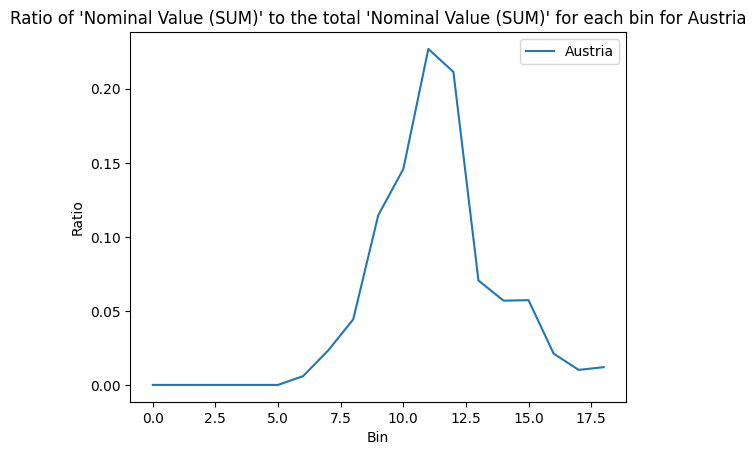

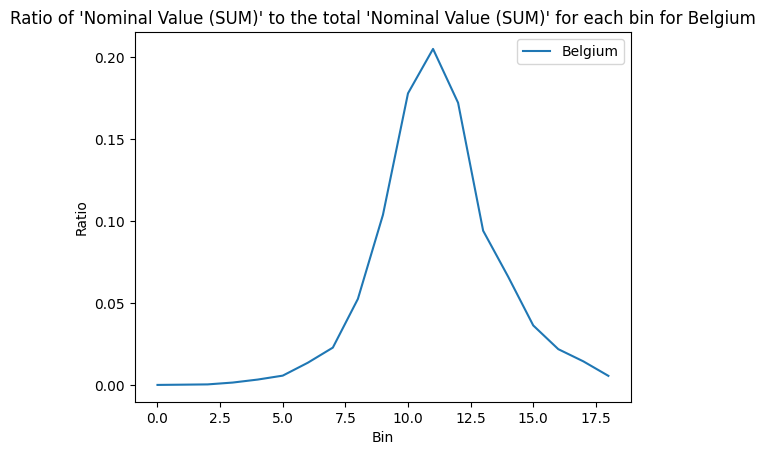

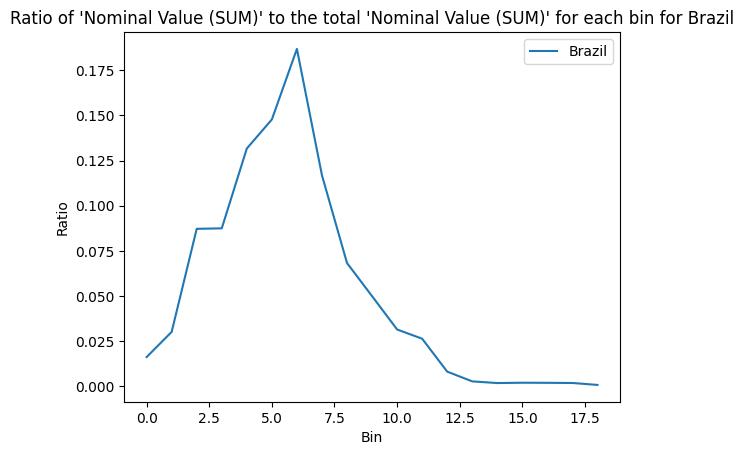

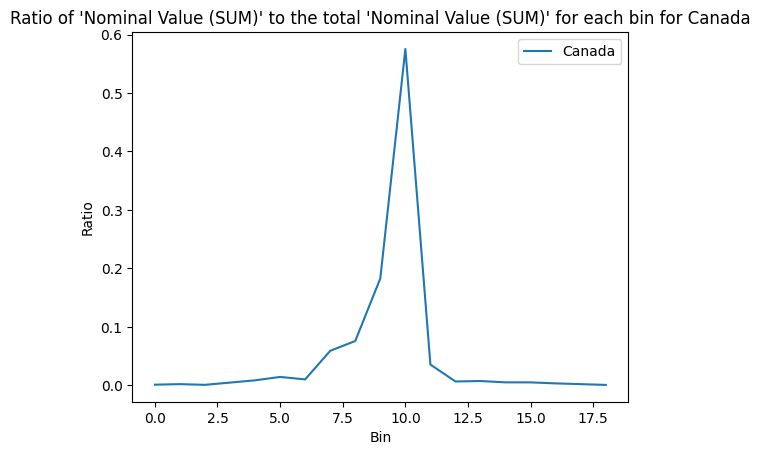

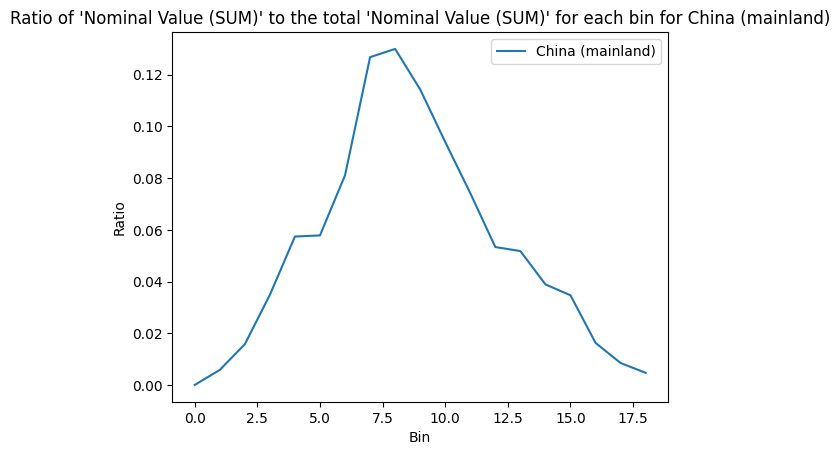

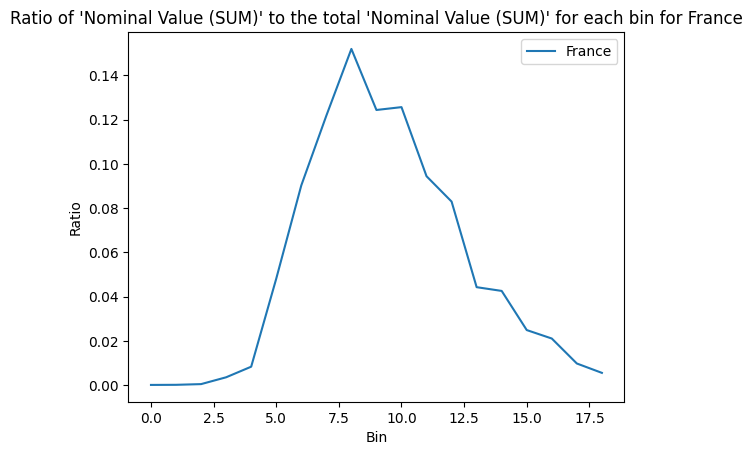

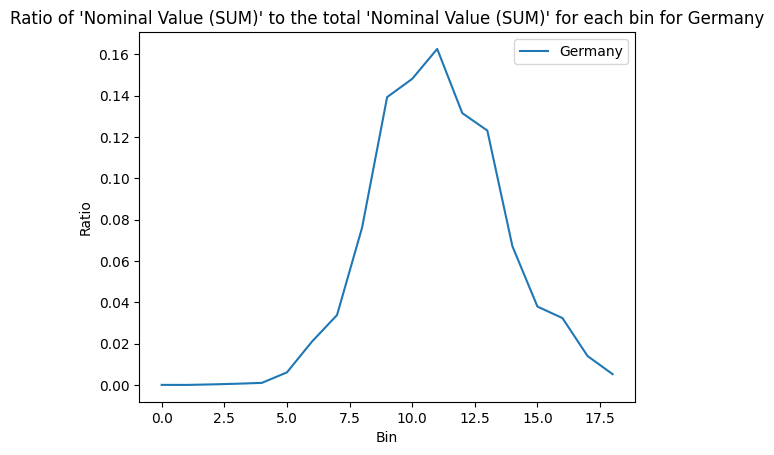

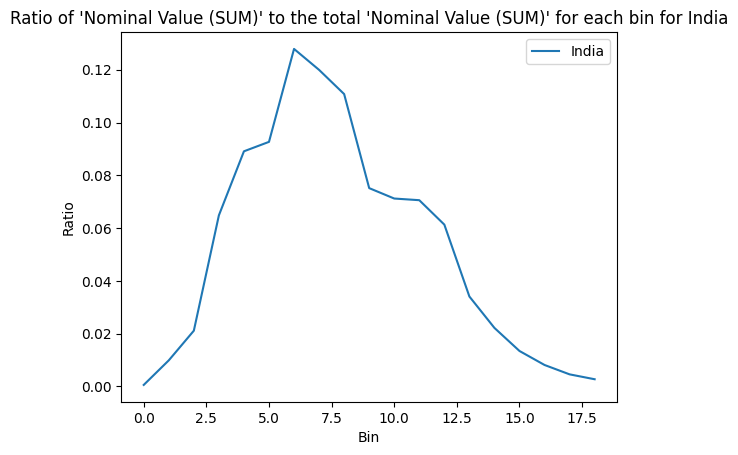

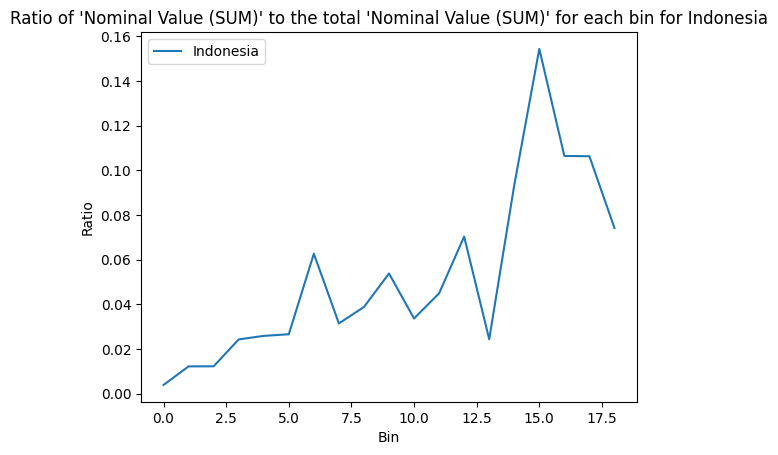

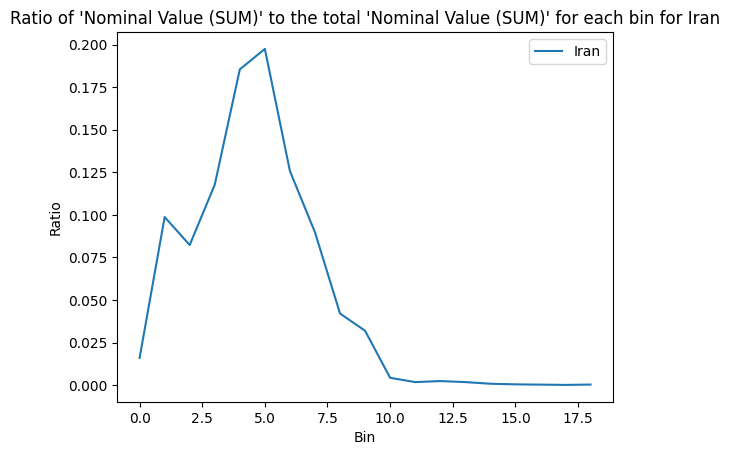

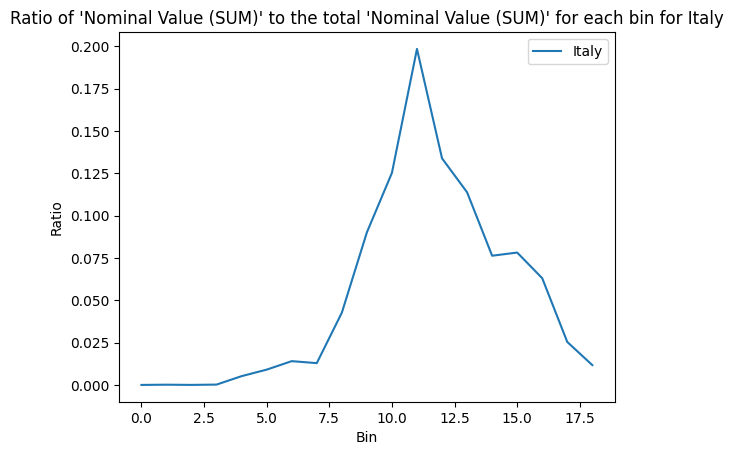

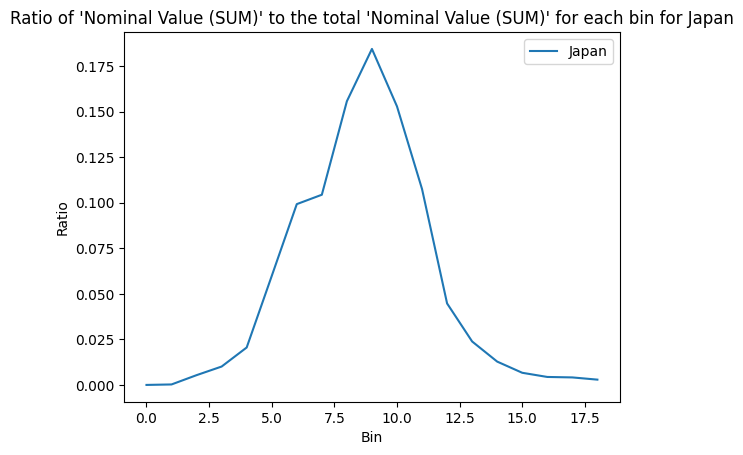

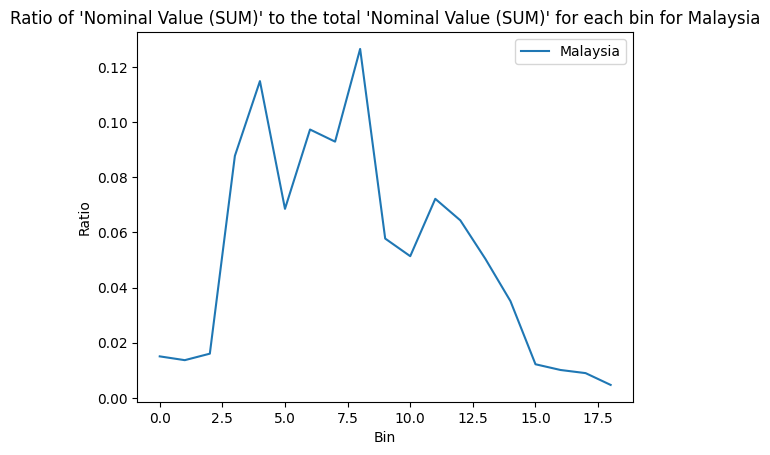

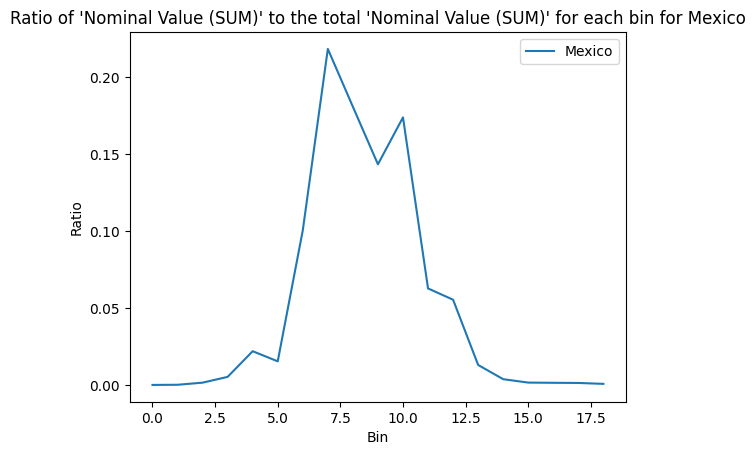

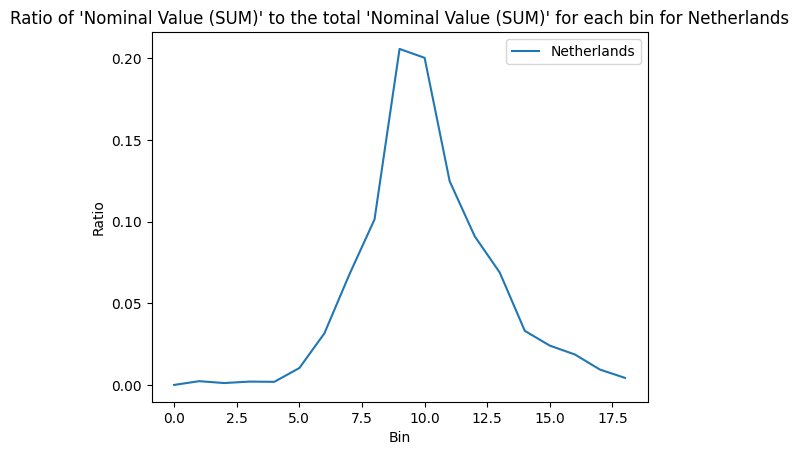

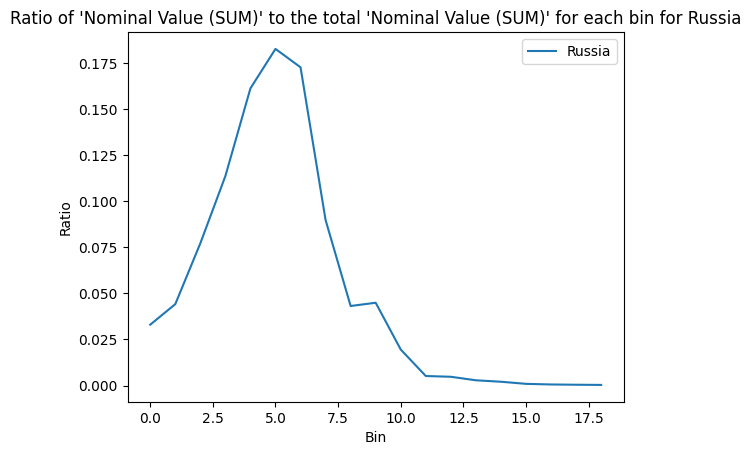

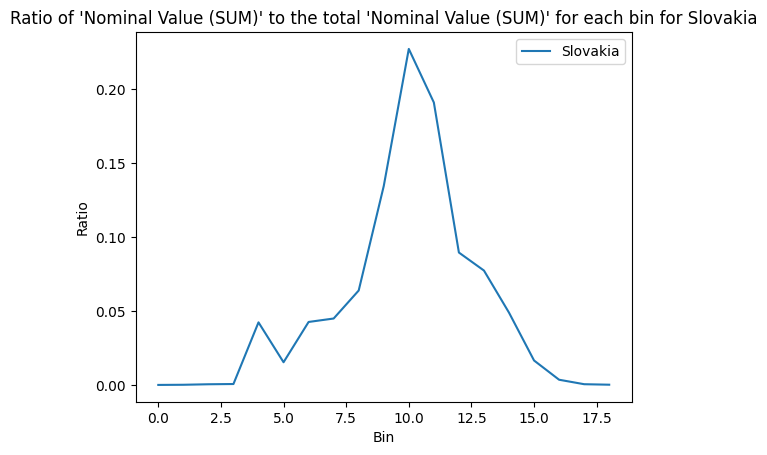

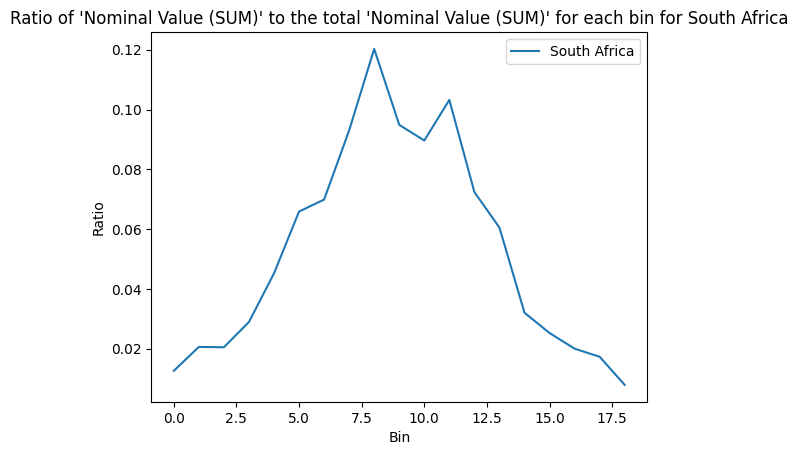

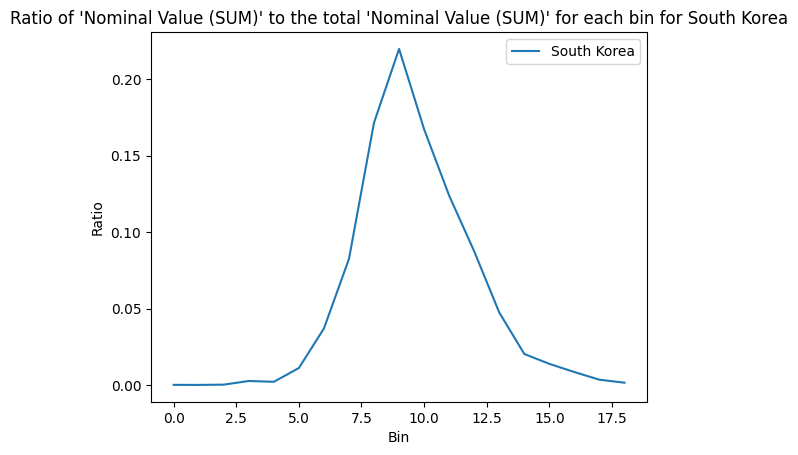

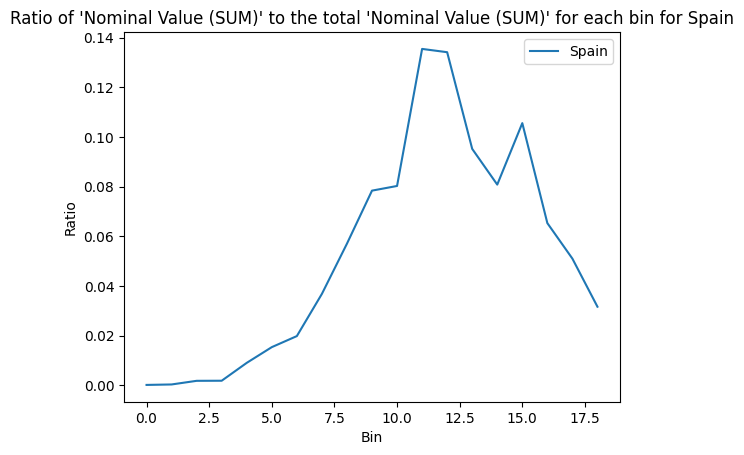

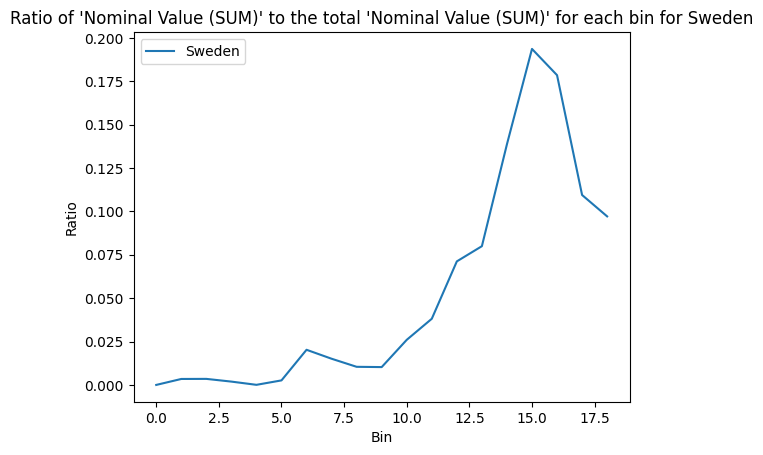

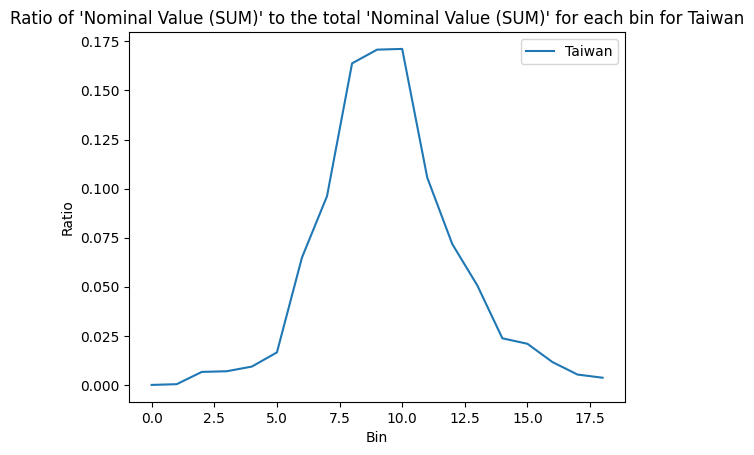

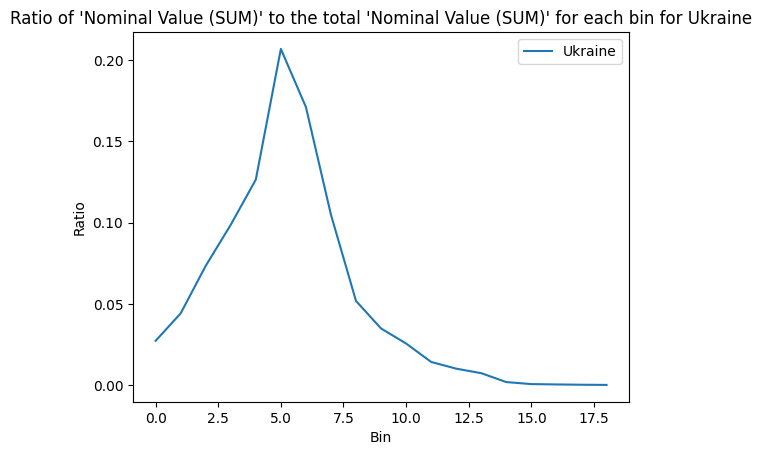

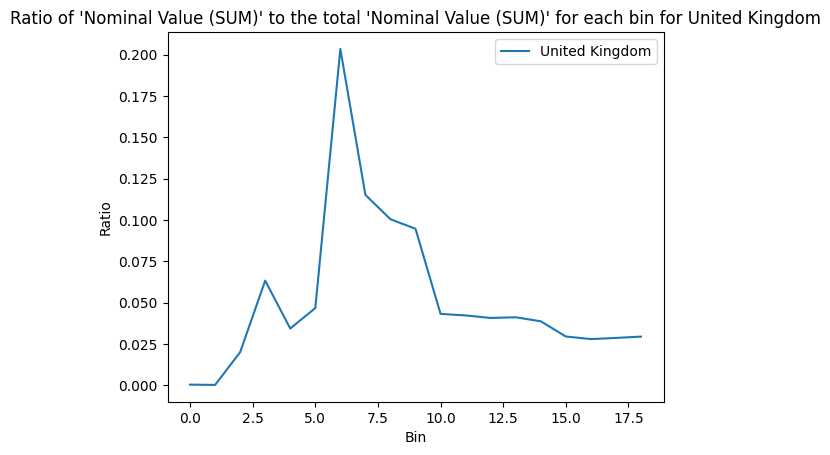

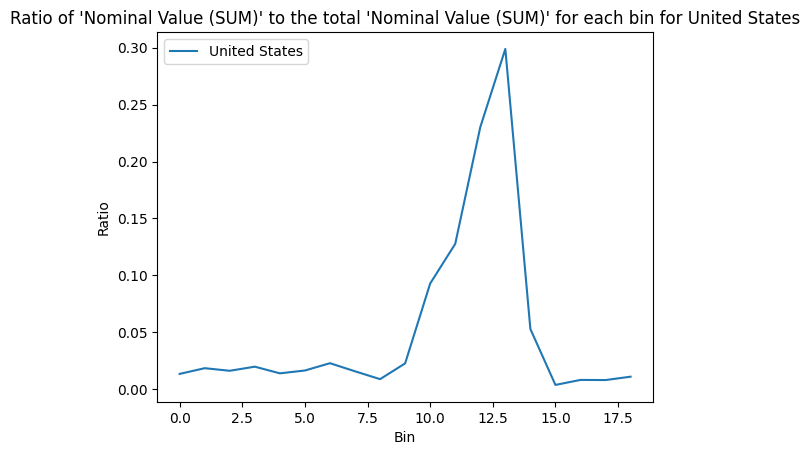

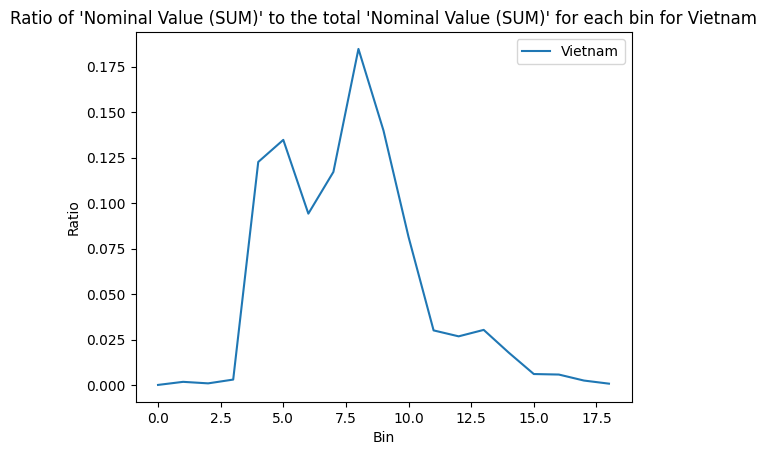

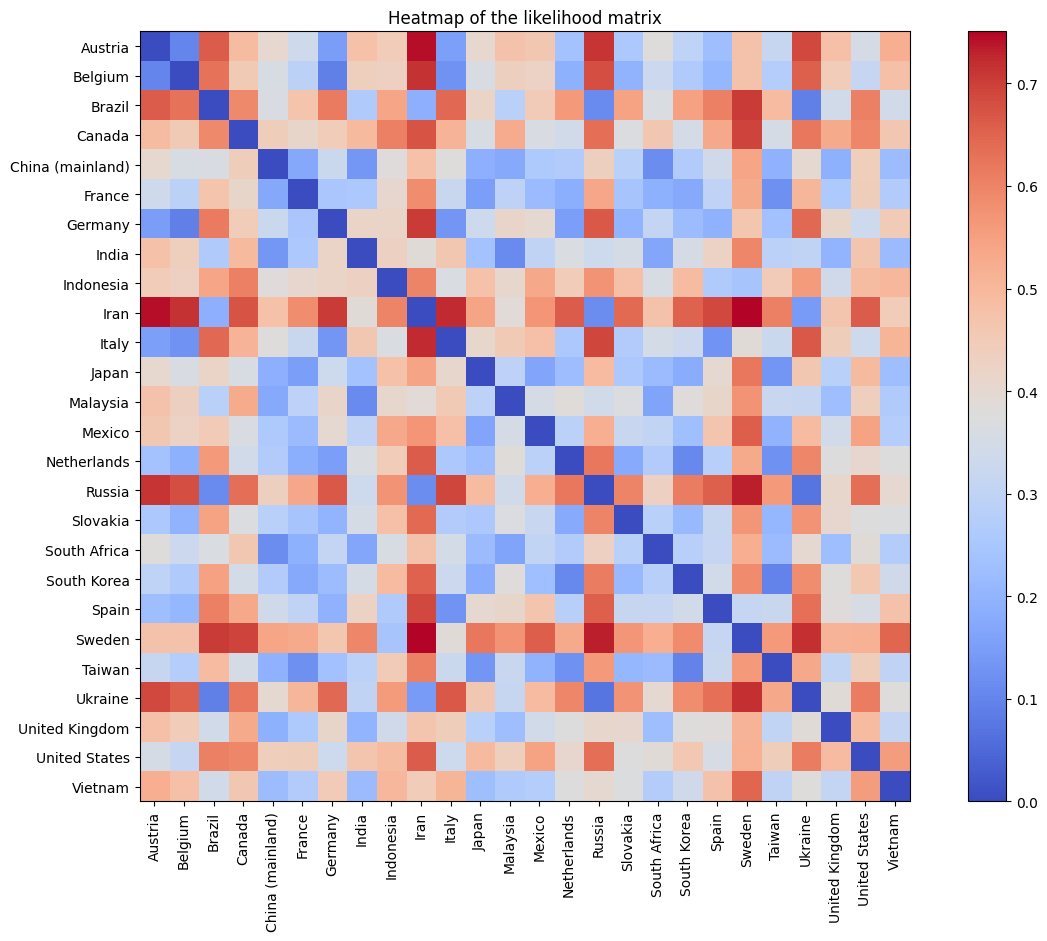

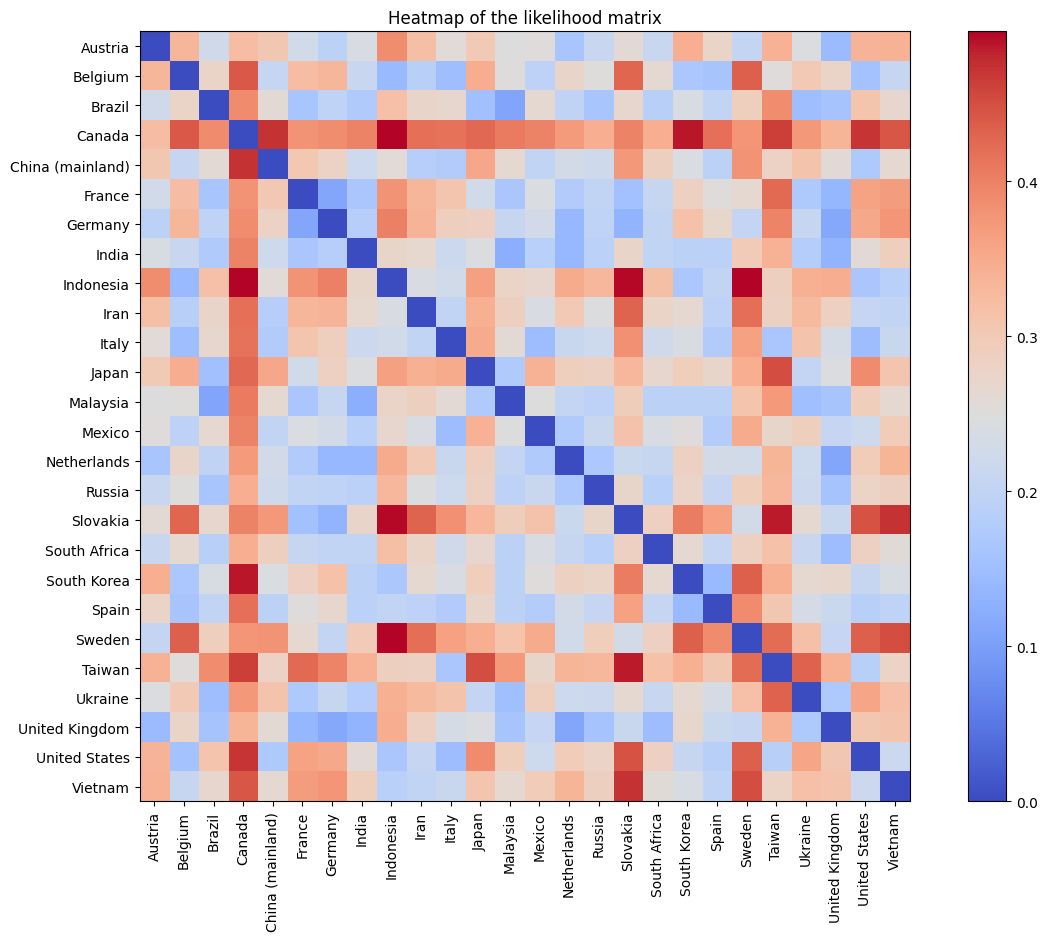

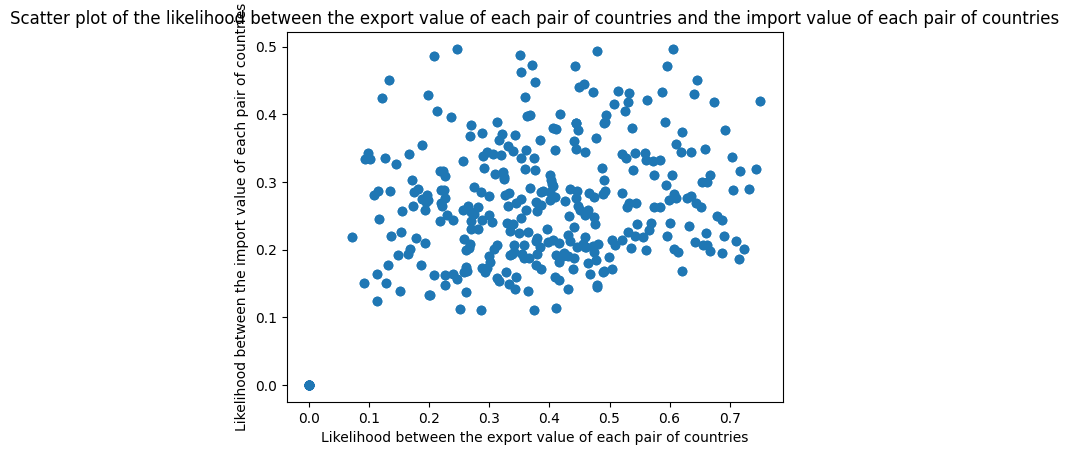

Index(['Export_country', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18'],
      dtype='object')
Index(['Import_country', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18'],
      dtype='object')


In [15]:
# load the data from the csv file
df_top = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_export.csv")
# sort the data by "Export_country"
df_top = df_top.sort_values(by="Export_country", ascending=True)

# divide 233 to 4425 into 10 bins
num_bins = 20
bins = np.linspace(np.log(233), np.log(2341), num_bins)
samplePoints = np.linspace(233, 2341, 3000)

df_store = pd.DataFrame(columns=["Export_country"] + [str(i) for i in range(num_bins-1)])
# generate a dataframe to store the ratio of "Nominal Value (SUM)" to the total "Nominal Value (SUM)" for each bin for each "Export_country"
# with rows as "Export_country" and columns as bins
# save the data to a single csv file
for country in df_top["Export_country"].unique():
    # df_smooth = df_top[df_top["Export_country"] == country].copy()
    # price_smooth = df_smooth["Price"].values
    # volumn_smooth = df_smooth["Tons (SUM)"].values
    # smoothed_volumn = lowess(volumn_smooth.flatten(), price_smooth.flatten(), frac=0.2,xvals=samplePoints)
    # # set the minus value to 0
    # smoothed_volumn[smoothed_volumn < 0] = 0
    # smoothed_result = np.column_stack((samplePoints, smoothed_volumn))
    # df_smooth = pd.DataFrame(smoothed_result, columns=["Price", "Tons (SUM)"])
    # df_country = df_smooth.copy()

    df_country = df_top[df_top["Export_country"] == country].copy()
    df_ratio = pd.DataFrame(columns=[str(i) for i in range(num_bins-1)])
    # calculate the ratio of "Nominal Value (SUM)" to the total "Nominal Value (SUM)" for each bin
    for i in range(num_bins-1):
        # df_ratio.loc[0, str(i)] = df_country[(df_country["Price"] >= bins[i]) & (df_country["Price"] < bins[i+1])]["Tons (SUM)"].sum() / df_country["Tons (SUM)"].sum()
        df_ratio.loc[0, str(i)] = df_country[(np.log(df_country["Price"]) >= bins[i]) & (np.log(df_country["Price"]) < bins[i+1])]["Tons (SUM)"].sum() / df_country["Tons (SUM)"].sum()

        # df_ratio.loc[0, str(i)] = df_country[(df_country["Price"] >= bins[i]) & (df_country["Price"] < bins[i+1])]["Nominal Value (SUM)"].sum()

    df_ratio["Export_country"] = country
    df_store = pd.concat([df_store, df_ratio], axis=0)

    # plot the ratio of "Nominal Value (SUM)" to the total "Nominal Value (SUM)" for each bin for each "Export_country"
    plt.plot(range(num_bins-1), df_ratio.iloc[0, :-1], label=country)
    plt.title("Ratio of 'Nominal Value (SUM)' to the total 'Nominal Value (SUM)' for each bin for "+country)
    plt.xlabel("Bin")
    plt.ylabel("Ratio")
    plt.legend()
    plt.show()

df_store = df_store.reset_index(drop=True)
# save the data to a csv file
df_store.to_csv("finalVersion/ratio_export.csv", index=False)

# calculte the likelihood between each pair of countries
likelihood = np.zeros((len(df_store), len(df_store)))
for i in range(len(df_store)):
    for j in range(len(df_store)):
        i_data = df_store.loc[i, [str(i) for i in range(num_bins-1)]].astype(float)
        j_data = df_store.loc[j, [str(i) for i in range(num_bins-1)]].astype(float)
        # use kernel density estimation to smooth the data
        # i_data = kde.fit(i_data.values.reshape(-1, 1)).score_samples(samplePoints.reshape(-1, 1))
        # j_data = kde.fit(j_data.values.reshape(-1, 1)).score_samples(samplePoints.reshape(-1, 1))   
        # calculate the likelihood between the smoothed data

        # likelihood[i, j] = stats.entropy(i_data, j_data)
        # use jensen-shannon divergence to calculate the likelihood
        likelihood[i, j] = jensenshannon(i_data, j_data)
        # likelihood[i, j] = linalg.norm(i_data - j_data)
        # likelihood[i, j] = np.corrcoef(df_store.loc[i, [str(i) for i in range(num_bins-1)]].astype(float), df_store.loc[j, [str(i) for i in range(num_bins-1)]].astype(float))[0, 1]

# turn the likelihood into a dataframe
likelihood = pd.DataFrame(likelihood, columns=df_store["Export_country"], index=df_store["Export_country"])
# save the data to a csv file
likelihood.to_csv("finalVersion/likelihood_export.csv", index=False)

# plot the heatmap of the likelihood matrix
plt.figure(figsize=(15, 10))
plt.imshow(likelihood, cmap="coolwarm", interpolation="nearest")
plt.xticks(np.arange(len(likelihood)), likelihood.columns, rotation=90)
plt.yticks(np.arange(len(likelihood)), likelihood.columns)
plt.colorbar()
plt.title("Heatmap of the likelihood matrix")
plt.show()



# load the data from the csv file
df_top = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_import.csv")
# sort the data by "Export_country"
df_top = df_top.sort_values(by="Import_country", ascending=True)

df_store = pd.DataFrame(columns=["Import_country"] + [str(i) for i in range(num_bins-1)])
# generate a dataframe to store the ratio of "Nominal Value (SUM)" to the total "Nominal Value (SUM)" for each bin for each "Import_country"
# with rows as "Import_country" and columns as bins
# save the data to a single csv file

for country in df_top["Import_country"].unique():
    df_country = df_top[df_top["Import_country"] == country].copy()
    df_ratio = pd.DataFrame(columns=[str(i) for i in range(num_bins-1)])
    # calculate the ratio of "Nominal Value (SUM)" to the total "Nominal Value (SUM)" for each bin
    for i in range(num_bins-1):
        # df_ratio.loc[0, str(i)] = df_country[(df_country["Price"] >= bins[i]) & (df_country["Price"] < bins[i+1])]["Tons (SUM)"].sum() / df_country["Tons (SUM)"].sum()
        df_ratio.loc[0, str(i)] = df_country[(np.log(df_country["Price"]) >= bins[i]) & (np.log(df_country["Price"]) < bins[i+1])]["Tons (SUM)"].sum() / df_country["Tons (SUM)"].sum()

        # df_ratio.loc[0, str(i)] = df_country[(df_country["Price"] >= bins[i]) & (df_country["Price"] < bins[i+1])]["Nominal Value (SUM)"].sum()

    df_ratio["Import_country"] = country
    df_store = pd.concat([df_store, df_ratio], axis=0)

    # # plot the ratio of "Nominal Value (SUM)" to the total "Nominal Value (SUM)" for each bin for each "Import_country"
    # plt.plot(range(num_bins-1), df_ratio.iloc[0, :-1], label=country)
    # plt.title("Ratio of 'Nominal Value (SUM)' to the total 'Nominal Value (SUM)' for each bin for "+country)
    # plt.xlabel("Bin")
    # plt.ylabel("Ratio")
    # plt.legend()
    # plt.show()

df_store = df_store.reset_index(drop=True)
# save the data to a csv file
df_store.to_csv("finalVersion/ratio_import.csv", index=False)

# calculte the likelihood between each pair of countries
likelihood = np.zeros((len(df_store), len(df_store)))
for i in range(len(df_store)):
    for j in range(len(df_store)):
        likelihood[i, j] = jensenshannon(df_store.loc[i, [str(i) for i in range(num_bins-1)]].astype(float), df_store.loc[j, [str(i) for i in range(num_bins-1)]].astype(float))
        # likelihood[i, j] = stats.entropy(df_store.loc[i, [str(i) for i in range(num_bins-1)]].astype(float), df_store.loc[j, [str(i) for i in range(num_bins-1)]].astype(float))
        # likelihood[i, j] = linalg.norm(df_store.loc[i, [str(i) for i in range(num_bins-1)]].astype(float) - df_store.loc[j, [str(i) for i in range(num_bins-1)]].astype(float))
        # likelihood[i, j] = np.corrcoef(df_store.loc[i, [str(i) for i in range(num_bins-1)]].astype(float), df_store.loc[j, [str(i) for i in range(num_bins-1)]].astype(float))[0, 1]

# turn the likelihood into a dataframe
likelihood = pd.DataFrame(likelihood, columns=df_store["Import_country"], index=df_store["Import_country"])
# save the data to a csv file
likelihood.to_csv("finalVersion/likelihood_import.csv", index=False)

# plot the heatmap of the likelihood matrix
plt.figure(figsize=(15, 10))
plt.imshow(likelihood, cmap="coolwarm", interpolation="nearest")
plt.xticks(np.arange(len(likelihood)), likelihood.columns, rotation=90)
plt.yticks(np.arange(len(likelihood)), likelihood.columns)
plt.colorbar()
plt.title("Heatmap of the likelihood matrix")
plt.show()

# load the two likelihood matrices
likelihood_export = pd.read_csv("finalVersion/likelihood_export.csv")
likelihood_import = pd.read_csv("finalVersion/likelihood_import.csv")
# flatten the two likelihood matrices
likelihood_export = likelihood_export.values.flatten()
likelihood_import = likelihood_import.values.flatten()
# plot the scatter plot of the likelihood between the export value of each pair of countries and the import value of each pair of countries
plt.scatter(likelihood_export, likelihood_import)
plt.xlabel("Likelihood between the export value of each pair of countries")
plt.ylabel("Likelihood between the import value of each pair of countries")
plt.title("Scatter plot of the likelihood between the export value of each pair of countries and the import value of each pair of countries")
plt.show()

# load the ratio import and the ratio export
df_ratio_export = pd.read_csv("finalVersion/ratio_export.csv")
df_ratio_import = pd.read_csv("finalVersion/ratio_import.csv")

# print the columns of the two dataframes
print(df_ratio_export.columns)
print(df_ratio_import.columns)

likelihood_export_and_import = np.zeros((len(df_ratio_export), len(df_ratio_import)))

for i in range(len(df_ratio_export)):
    for j in range(len(df_ratio_import)):
        # calculate the likelihood between the export value of each pair of countries and the import value of each pair of countries
        likelihood_export_and_import[i,j] = jensenshannon(df_ratio_export.iloc[i,1:].astype(float),df_ratio_import.iloc[j,1:].astype(float))

likelihood_export_and_import = pd.DataFrame(likelihood_export_and_import, columns=df_store["Import_country"], index=df_store["Import_country"])

# # plot the heatmap of the likelihood between the export value of each pair of countries and the import value of each pair of countries
# plt.figure(figsize=(15, 10))
# plt.imshow(likelihood_export_and_import, cmap="coolwarm", interpolation="nearest")
# plt.xticks(np.arange(len(likelihood_export_and_import.columns)), likelihood_export_and_import.columns, rotation=90)
# plt.yticks(np.arange(len(likelihood_export_and_import.index)), likelihood_export_and_import.index)
# plt.colorbar()
# plt.title("Heatmap of the likelihood between the export value of each pair of countries and the import value of each pair of countries")
# plt.show()

# # save the data to a csv file
# likelihood_export_and_import.to_csv("finalVersion/likelihood_export_and_import.csv", index=False)

In [16]:
# # load the data from the csv file
# df_export_of_topExport = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_export.csv")
# df_import_of_topExport = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_import.csv")
# # sort the data by "Export_country"
# df_top = df_top.sort_values(by="Export_country", ascending=True)

# # divide 233 to 4425 into 10 bins
# num_bins = 40
# bins = np.linspace(233, 2341, num_bins)
# samplePoints = np.linspace(233, 2341, 3000)

# df_store = pd.DataFrame(columns=["Export_country"] + [str(i) for i in range(num_bins-1)])
# # generate a dataframe to store the ratio of "Nominal Value (SUM)" to the total "Nominal Value (SUM)" for each bin for each "Export_country"
# # with rows as "Export_country" and columns as bins
# # save the data to a single csv file
# for country in df_top["Export_country"].unique():
#     df_country_export = df_export_of_topExport[df_export_of_topExport["Export_country"] == country].copy()
#     df_country_import = df_import_of_topExport[df_import_of_topExport["Import_country"] == country].copy()
#     df_export = pd.DataFrame(columns=[str(i) for i in range(num_bins-1)])
#     df_import = pd.DataFrame(columns=[str(i) for i in range(num_bins-1)])
#     df_ratio = pd.DataFrame(columns=[str(i) for i in range(num_bins-1)])

#     for i in range(num_bins-1):
#         df_export.loc[0, str(i)] = df_country_export[(df_country_export["Price"] >= bins[i]) & (df_country_export["Price"] < bins[i+1])]["Tons (SUM)"].sum()
#         df_import.loc[0, str(i)] = df_country_import[(df_country_import["Price"] >= bins[i]) & (df_country_import["Price"] < bins[i+1])]["Tons (SUM)"].sum()
#         df_ratio = df_ratio / df_ratio.sum(axis=1)

#     df_ratio["Export_country"] = country
#     df_store = pd.concat([df_store, df_ratio], axis=0)

#     # # plot the ratio of "Nominal Value (SUM)" to the total "Nominal Value (SUM)" for each bin for each "Export_country"
#     # plt.plot(range(num_bins-1), df_ratio.iloc[0, :-1], label=country)
#     # plt.title("Ratio of 'Nominal Value (SUM)' to the total 'Nominal Value (SUM)' for each bin for "+country)
#     # plt.xlabel("Bin")
#     # plt.ylabel("Ratio")
#     # plt.legend()
#     # plt.show()

# df_store = df_store.reset_index(drop=True)
# # save the data to a csv file
# df_store.to_csv("finalVersion/ratio_export_import_difference.csv", index=False)



f:\anaconda\envs\FYP\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "f:\anaconda\envs\FYP\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
f:\anaconda\envs\FYP\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
f:\anaconda\envs\FYP\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

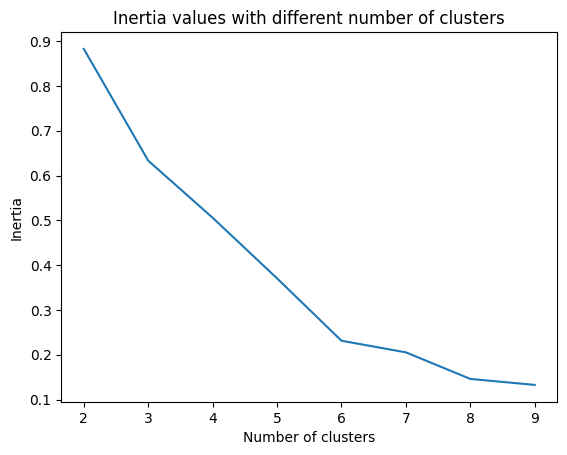

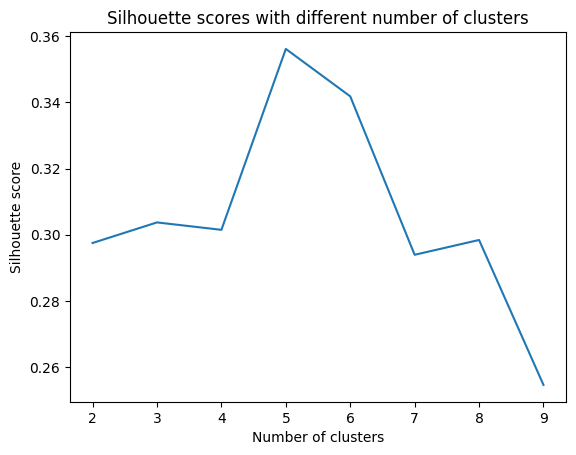

[4.60440787e-01 2.67447187e-01 1.27241498e-01 5.26780927e-02
 2.39392908e-02 1.75341045e-02 1.19600276e-02 1.11880936e-02
 9.05936750e-03 6.29537979e-03 4.13088299e-03 2.33524119e-03
 1.88191649e-03 1.53097609e-03 1.05944369e-03 7.08888978e-04
 3.18025970e-04 2.50796860e-04 8.26786158e-33]


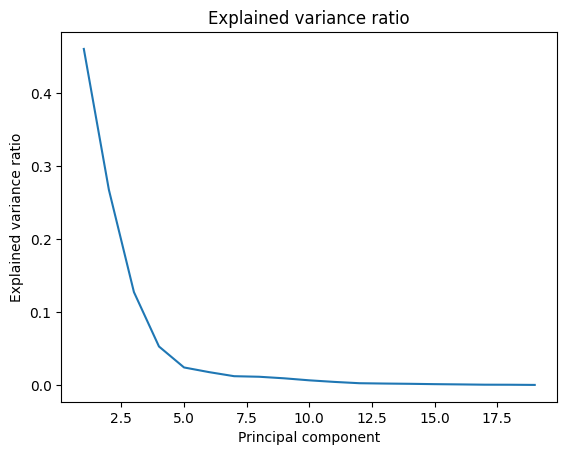

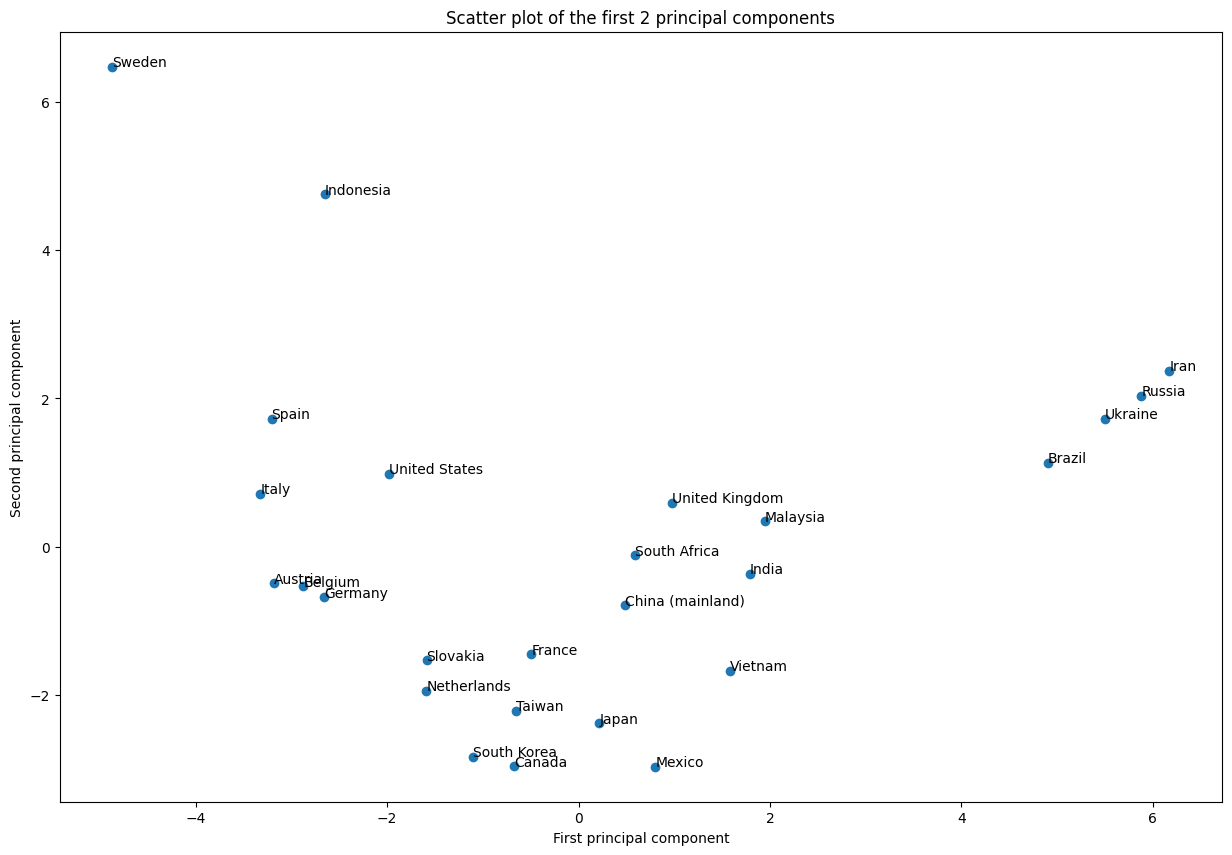

In [17]:
# load the data from the csv file
df_export = pd.read_csv("finalVersion/ratio_export.csv")

# do the k-means clustering for the export data

# find the optimal number of clusters
# create an empty list to store the inertia values
inertia = []
# create an empty list to store the silhouette scores
silhouette = []
# try different number of clusters
for i in range(2, 10):
    # create a k-means clustering model
    kmeans = KMeans(n_clusters=i, random_state=0)
    # fit the model
    kmeans.fit(df_export.drop(columns=["Export_country"]))
    # store the inertia value
    inertia.append(kmeans.inertia_)
    # store the silhouette score
    silhouette.append(silhouette_score(df_export.drop(columns=["Export_country"]), kmeans.labels_))

# plot the inertia values
plt.figure()
plt.plot(range(2, 10), inertia)
plt.title("Inertia values with different number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

# plot the silhouette scores
plt.figure()
plt.plot(range(2, 10), silhouette)
plt.title("Silhouette scores with different number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

# do PCA for the export data
# standardize the data
scaler = StandardScaler()
df_export_scaled = scaler.fit_transform(df_export.drop(columns=["Export_country"]))
# create a PCA model
pca = PCA()
# fit the model
df_export_pca = pca.fit_transform(df_export_scaled)
print(pca.explained_variance_ratio_)
# plot the explained variance ratio
plt.figure()
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.title("Explained variance ratio")
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.show()

# plot the scatter plot of the first 2 principal components
plt.figure(figsize=(15, 10))
plt.scatter(df_export_pca[:, 0], df_export_pca[:, 1])  
# label the points with the country names
for i in range(len(df_export)):
    plt.text(df_export_pca[i, 0], df_export_pca[i, 1], df_export["Export_country"][i])
plt.title("Scatter plot of the first 2 principal components")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()


    

variance ratio: [4.78088473e-01 3.17072601e-01 9.86118083e-02 4.11064000e-02
 1.59083976e-02 1.08530784e-02 7.68214608e-03 5.94598821e-03
 4.18363760e-03 3.59390801e-03 3.37123814e-03 2.49028080e-03
 2.00371242e-03 1.58632392e-03 1.44013141e-03 1.24884563e-03
 1.20623563e-03 8.18801852e-04 7.07144105e-04 5.28060392e-04
 4.12490749e-04 3.84618309e-04 3.46777100e-04 2.55924626e-04
 1.52976572e-04 1.72337215e-33]
components: [[ 2.61136256e-01  2.66482080e-01 -2.29274069e-01  1.47708457e-01
   9.70963687e-02  2.10090409e-01  2.72370271e-01 -4.29155573e-02
   9.51395767e-02 -2.53439923e-01  2.54833232e-01  1.42080456e-01
  -4.72457601e-02  1.17621154e-01  2.64044102e-01 -2.48364115e-01
   2.54407404e-01  1.13590586e-01  2.39196259e-01  2.42602513e-01
   1.19997916e-01  2.23211262e-01 -2.42235475e-01  6.18840092e-03
   1.84810847e-01 -1.20736829e-02]
 [-7.84283446e-02 -5.70159061e-02  1.82937998e-01  1.09031987e-01
   3.05172155e-01  2.17761065e-01 -3.17835143e-02  3.18705293e-01
  -9.285645

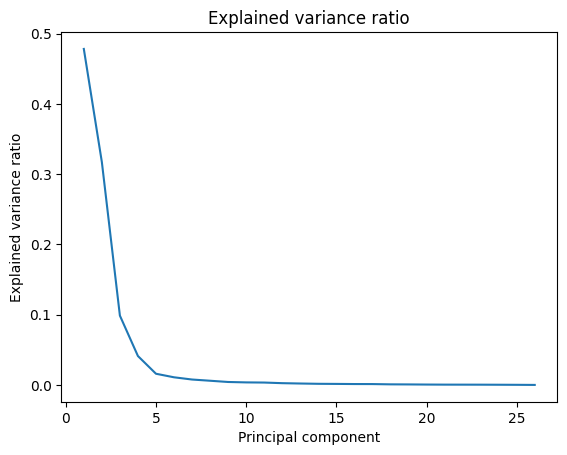

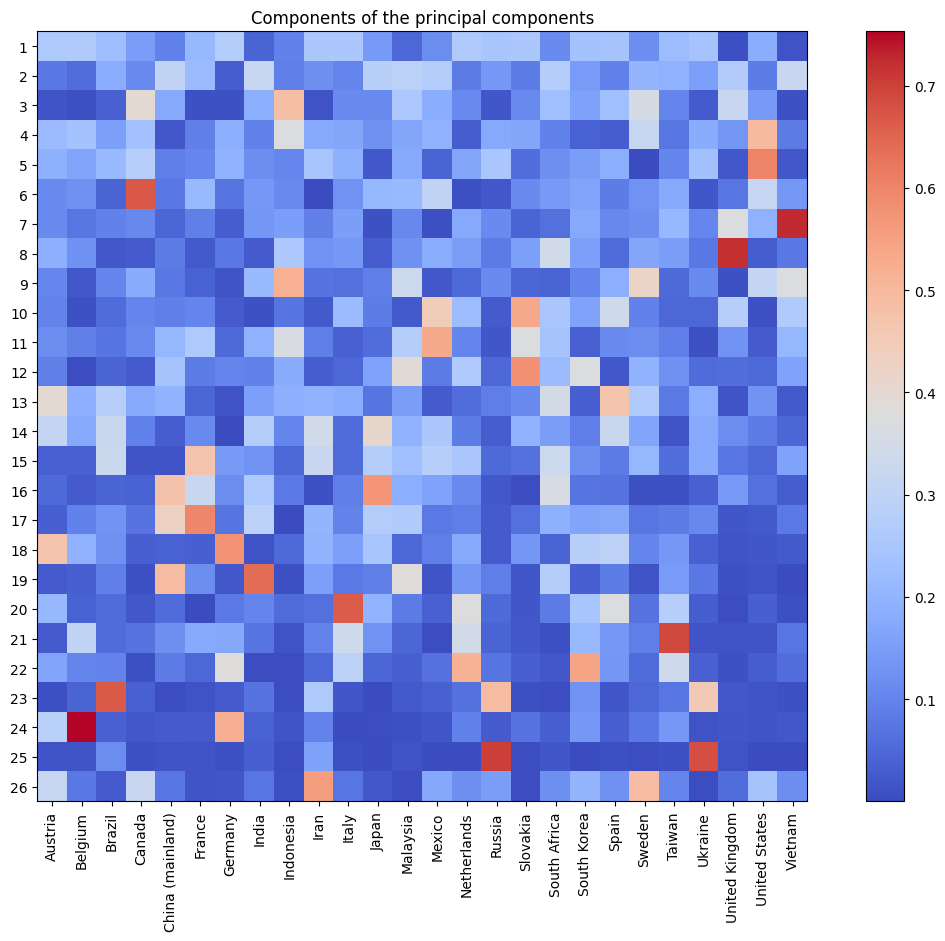

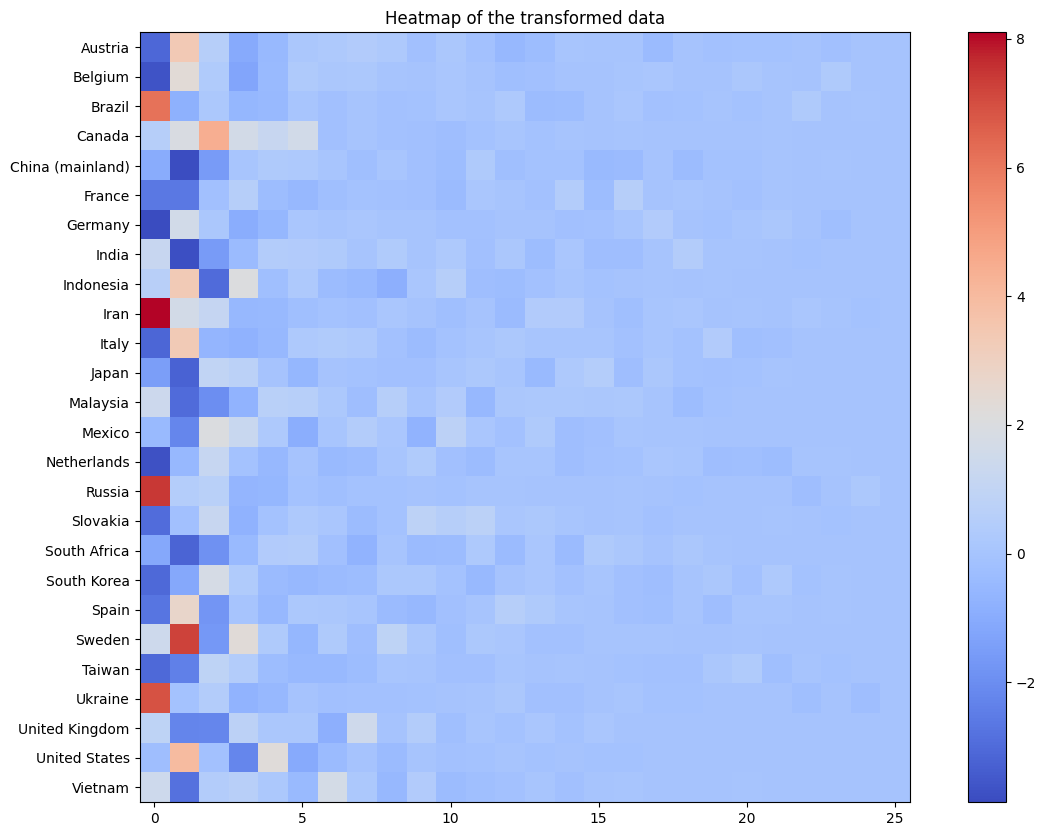

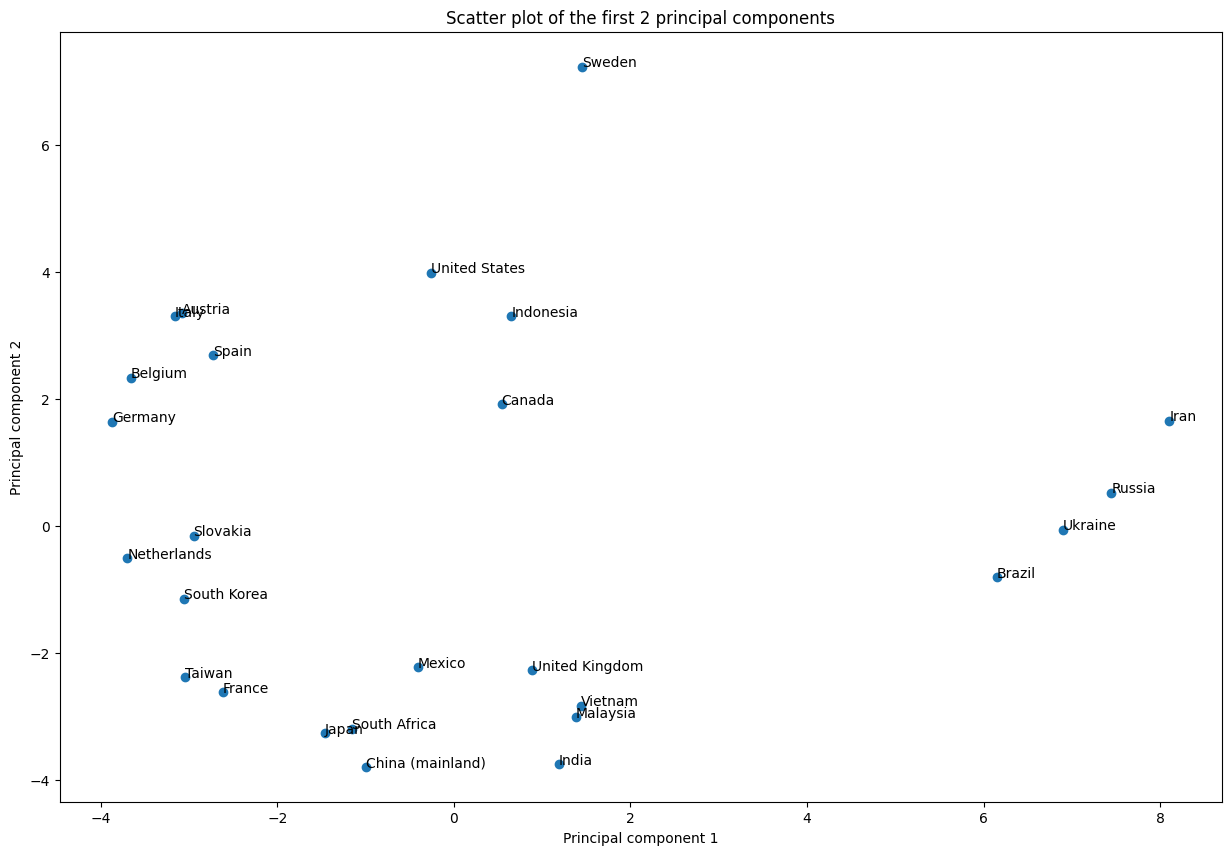

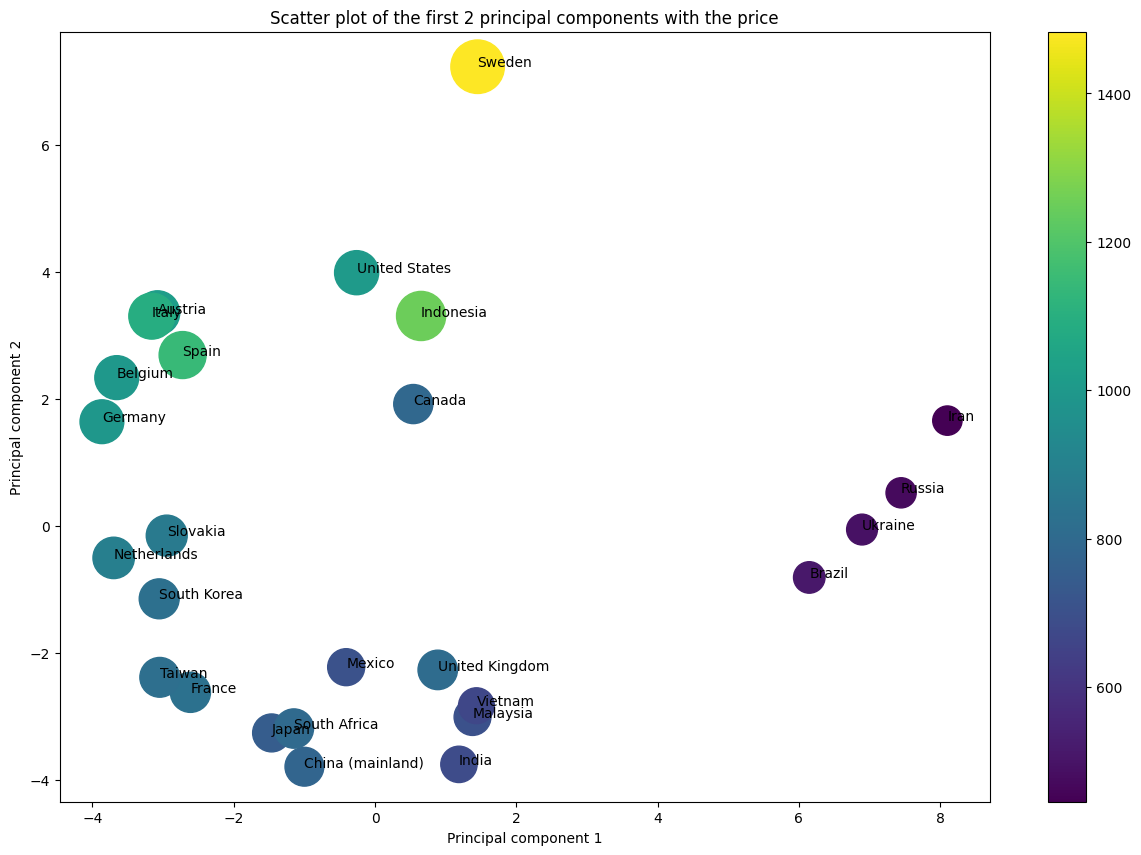

     Export_country        Price  Principal component 1  Principal component 2
0           Austria  1019.862000              -3.079015               3.353437
1           Belgium   997.770871              -3.656130               2.336095
2            Brazil   514.322282               6.147642              -0.808600
3            Canada   793.151640               0.541889               1.919944
4  China (mainland)   779.735770              -0.999615              -3.787187


In [18]:
# load the data from the csv file

df = pd.read_csv("finalVersion/filtered_byPrice_bytopExporters_export.csv")
# group the data by "Export_country" and calculate the total export value and the total export volume
df = df.groupby(["Export_country"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# caculate the average price
df["Price"] = df["Nominal Value (SUM)"] / df["Tons (SUM)"]
# sort the data by "Export_country"
df_price = df.sort_values(by="Export_country", ascending=True)
# reset the index
df_price = df_price.reset_index(drop=True)

# do PCA on the likelihood matrix likelihood_export

# load the data from the csv file
df = pd.read_csv("finalVersion/likelihood_export.csv")
# reset the index
df = df.reset_index(drop=True)
df = df.astype(float)

# standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
# do PCA on the standardized data and provide necessary information
pca = PCA()
df_pca = pca.fit_transform(df_scaled)
print("variance ratio:", pca.explained_variance_ratio_)
print("components:", pca.components_)
print("singular values:", pca.singular_values_)
# plot the explained variance ratio
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.title("Explained variance ratio")
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.show()

# plot the components of the all principal components
plt.figure(figsize=(15, 10))
plt.imshow(abs(pca.components_), cmap="coolwarm", interpolation="nearest")
# label the x-axis with the columns of the original data
plt.xticks(np.arange(len(df.columns)), df.columns, rotation=90)
# label the y-axis with the principal components
plt.yticks(np.arange(len(pca.components_)), np.arange(1, len(pca.components_)+1))
plt.colorbar()
plt.title("Components of the principal components")
plt.show()

# plot the heatmap of the transformed data
plt.figure(figsize=(15, 10))
plt.imshow(df_pca, cmap="coolwarm", interpolation="nearest")
# label the y-axis with the original data
plt.yticks(np.arange(len(df_pca)), df.columns)
plt.colorbar()
plt.title("Heatmap of the transformed data")
plt.show()

# plot the scatter plot of the first 2 principal components
plt.figure(figsize=(15, 10))
plt.scatter(df_pca[:, 0], df_pca[:, 1])
# label each point with the country name
for i, txt in enumerate(df.columns):
    plt.annotate(txt, (df_pca[i, 0], df_pca[i, 1]))
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.title("Scatter plot of the first 2 principal components")
plt.show()

# plot the scatter plot of the first 2 principal components with the price
plt.figure(figsize=(15, 10))
# change the size of the points according to the price
plt.scatter(df_pca[:, 0], df_pca[:, 1], s=df_price["Price"],c=df_price["Price"])
# label each point with the country name
for i, txt in enumerate(df.columns):
    plt.annotate(txt, (df_pca[i, 0], df_pca[i, 1]))
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.title("Scatter plot of the first 2 principal components with the price")
plt.colorbar()
plt.show()

# save the first 2 principal components and the price to a csv file with the country name
df_price["Principal component 1"] = df_pca[:, 0]
df_price["Principal component 2"] = df_pca[:, 1]
# drop the columns "Nominal Value (SUM)" and "Tons (SUM)"
df_price = df_price.drop(columns=["Nominal Value (SUM)", "Tons (SUM)"])
print(df_price.head())
# save the data to a csv file
df_price.to_csv("finalVersion/price_pca.csv", index=False)




         Price  Principal component 1  Principal component 2
0  1019.862000              -3.079015               3.353437
1   997.770871              -3.656130               2.336095
2   514.322282               6.147642              -0.808600
3   793.151640               0.541889               1.919944
4   779.735770              -0.999615              -3.787187
[[ 0.7555415  -0.87331505  1.16794957]
 [ 0.66284427 -1.03700482  0.81362527]
 [-1.36576831  1.74368379 -0.28162263]
 [-0.19576439  0.15369853  0.66868639]
 [-0.25205911 -0.28352547 -1.31901806]
 [-0.02773595 -0.74120254 -0.91128877]
 [ 0.6455383  -1.09656818  0.57193609]
 [-0.65202475  0.33701592 -1.30610148]
 [ 1.72043175  0.18497612  1.15154461]
 [-1.65445838  2.29825529  0.57797704]
 [ 1.06262503 -0.89637563  1.15060486]
 [-0.39512131 -0.41525178 -1.1337507 ]
 [-0.5758767   0.39145942 -1.04660515]
 [-0.54942203 -0.11588222 -0.77341039]
 [ 0.20324907 -1.04946064 -0.17447938]
 [-1.54214038  2.11248549  0.18220488]
 [ 0.12701

f:\anaconda\envs\FYP\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
f:\anaconda\envs\FYP\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
f:\anaconda\envs\FYP\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
f:\anaconda\envs\FYP\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when

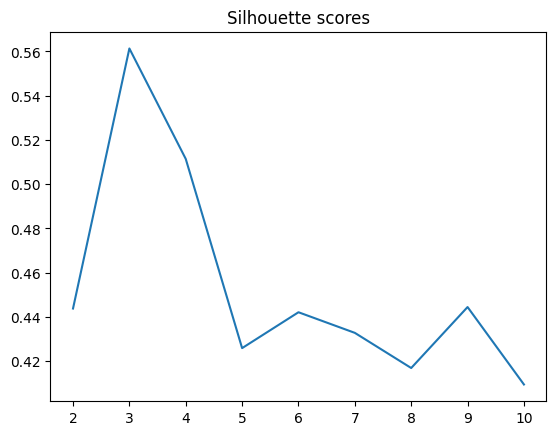

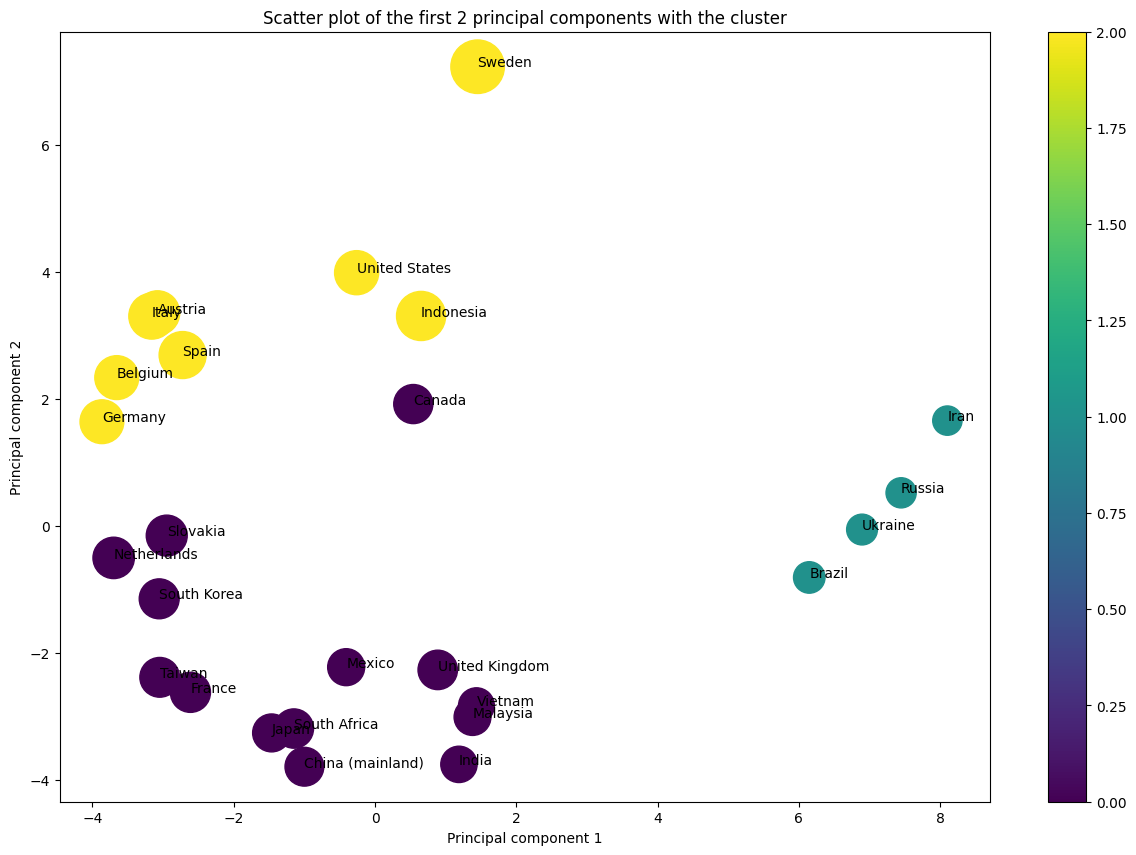

f:\anaconda\envs\FYP\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


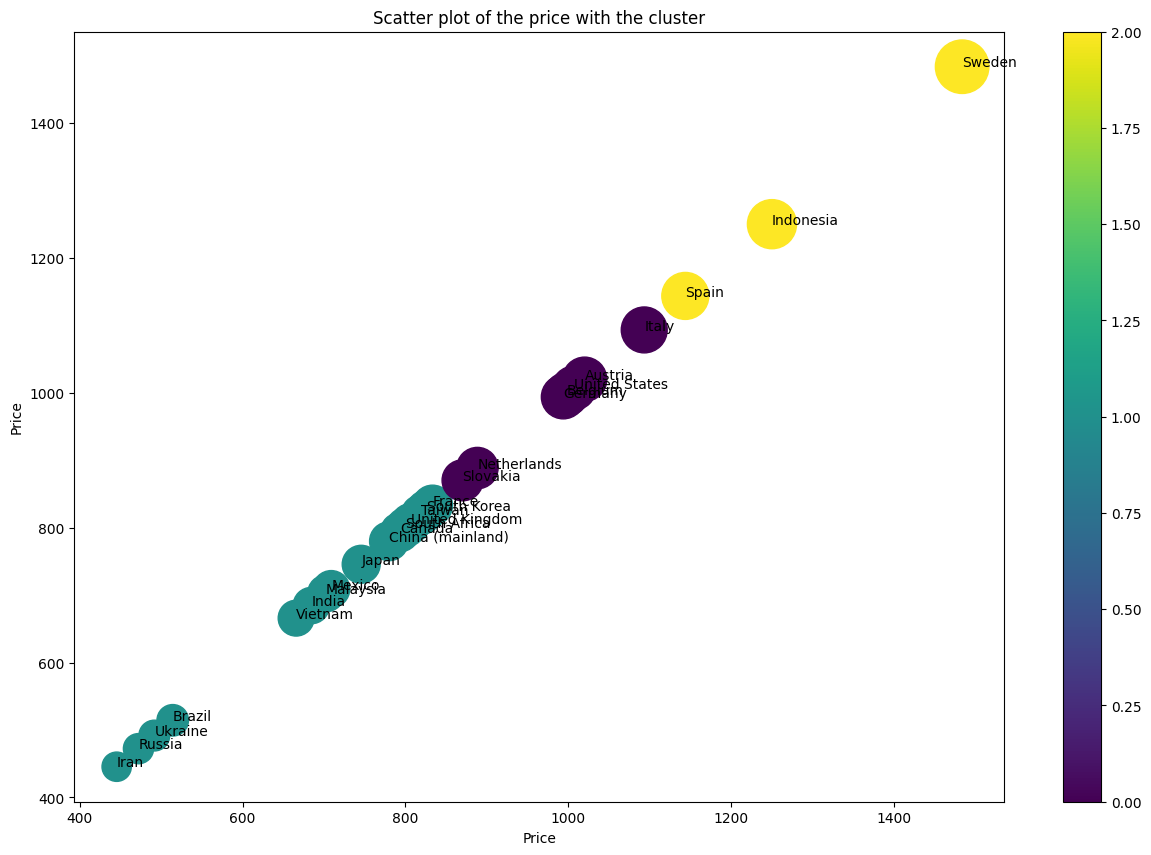

In [19]:
# do classification on the price_pca data

# load the data from the csv file
df_original = pd.read_csv("finalVersion/price_pca.csv")

# drop the column "Export_country"
df = df_original.drop(columns=["Export_country"])
print(df.head())    
# standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
print(df_scaled)

# find the optimal number of clusters
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# plot the silhouette scores
plt.plot(range(2, 11), silhouette_scores)
plt.title("Silhouette scores")

# choose the optimal number of clusters
n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
n_clusters = 3
print("The optimal number of clusters is", n_clusters)

# do clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(df_scaled)
df["Cluster"] = kmeans.labels_
print(df.head())

# plot the scatter plot of the first 2 principal components with the cluster
plt.figure(figsize=(15, 10))
# change the color of the points according to the cluster
plt.scatter(df["Principal component 1"], df["Principal component 2"], c=df["Cluster"],s = df_original["Price"])
# label each point with the country name
for i, txt in enumerate(df_original["Export_country"]):
    plt.annotate(txt, (df["Principal component 1"][i], df["Principal component 2"][i]))
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.title("Scatter plot of the first 2 principal components with the cluster")
plt.colorbar()
plt.show()

# use k-means directly on the price
price = df_original["Price"].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(price)
df_original["Cluster"] = kmeans.labels_

# plot the scatter plot of the price with the cluster without PCA
plt.figure(figsize=(15, 10))
# change the color of the points according to the cluster
plt.scatter(df_original["Price"], df_original["Price"], c=df_original["Cluster"],s = df_original["Price"])
# label each point with the country name
for i, txt in enumerate(df_original["Export_country"]):
    plt.annotate(txt, (df_original["Price"][i], df_original["Price"][i]))
plt.xlabel("Price")
plt.ylabel("Price")
plt.title("Scatter plot of the price with the cluster")
plt.colorbar()
plt.show()


In [20]:
# load the 2 likelihood matrix
likelihood_export = pd.read_csv("finalVersion/likelihood_export.csv")
likelihood_import = pd.read_csv("finalVersion/likelihood_import.csv")

# calculate the correlation between the 2 likelihood matrix
correlation = np.corrcoef(likelihood_export.values.flatten(), likelihood_import.values.flatten())[0, 1]
print("The correlation between the 2 likelihood matrix is", correlation)


The correlation between the 2 likelihood matrix is 0.339939694165344


## all countries

In [21]:
# # load the data from the csv file
# df = pd.read_csv("finalVersion/filtered_byPrice.csv")
# df_top = df.copy()
# # sort the data by "Export_country"
# df_top = df_top.sort_values(by="Export_country", ascending=True)

# # divide 233 to 4425 into 10 bins
# num_bins = 20
# bins = np.linspace(233, 2341, num_bins)
# samplePoints = np.linspace(233, 2341, 1000)

# df_store = pd.DataFrame(columns=["Export_country"] + [str(i) for i in range(num_bins-1)])
# # generate a dataframe to store the ratio of "Nominal Value (SUM)" to the total "Nominal Value (SUM)" for each bin for each "Export_country"
# # with rows as "Export_country" and columns as bins
# # save the data to a single csv file
# for country in df_top["Export_country"].unique():
#     df_smooth = df_top[df_top["Export_country"] == country].copy()
#     price_smooth = df_smooth["Price"].values
#     volumn_smooth = df_smooth["Tons (SUM)"].values
#     smoothed_volumn = lowess(volumn_smooth.flatten(), price_smooth.flatten(), frac=0.5,xvals=samplePoints)
#     smoothed_result = np.column_stack((samplePoints, smoothed_volumn))
#     df_smooth = pd.DataFrame(smoothed_result, columns=["Price", "Tons (SUM)"])

#     df_country = df_smooth.copy()
#     df_ratio = pd.DataFrame(columns=[str(i) for i in range(num_bins-1)])
#     # calculate the ratio of "Nominal Value (SUM)" to the total "Nominal Value (SUM)" for each bin
#     for i in range(num_bins-1):
#         df_ratio.loc[0, str(i)] = df_country[(df_country["Price"] >= bins[i]) & (df_country["Price"] < bins[i+1])]["Tons (SUM)"].sum() / df_country["Tons (SUM)"].sum()
#         # df_ratio.loc[0, str(i)] = df_country[(df_country["Price"] >= bins[i]) & (df_country["Price"] < bins[i+1])]["Nominal Value (SUM)"].sum()

#     df_ratio["Export_country"] = country
#     df_store = pd.concat([df_store, df_ratio], axis=0)

#     # plot the ratio of "Nominal Value (SUM)" to the total "Nominal Value (SUM)" for each bin for each "Export_country"
#     plt.plot(range(num_bins-1), df_ratio.iloc[0, :-1], label=country)
#     plt.title("Ratio of 'Nominal Value (SUM)' to the total 'Nominal Value (SUM)' for each bin for "+country)
#     plt.xlabel("Bin")
#     plt.ylabel("Ratio")
#     plt.legend()
#     plt.show()

# df_store = df_store.reset_index(drop=True)
# # save the data to a csv file
# df_store.to_csv("finalVersion/ratio_export.csv", index=False)

# # calculte the likelihood between each pair of countries
# likelihood = np.zeros((len(df_store), len(df_store)))
# for i in range(len(df_store)):
#     for j in range(len(df_store)):
#         i_data = df_store.loc[i, [str(i) for i in range(num_bins-1)]].astype(float)
#         j_data = df_store.loc[j, [str(i) for i in range(num_bins-1)]].astype(float)
#         # use kernel density estimation to smooth the data
#         # i_data = kde.fit(i_data.values.reshape(-1, 1)).score_samples(samplePoints.reshape(-1, 1))
#         # j_data = kde.fit(j_data.values.reshape(-1, 1)).score_samples(samplePoints.reshape(-1, 1))   
#         # calculate the likelihood between the smoothed data

#         likelihood[i, j] = stats.entropy(i_data, j_data)
#         # likelihood[i, j] = linalg.norm(i_data - j_data)
#         # likelihood[i, j] = np.corrcoef(df_store.loc[i, [str(i) for i in range(num_bins-1)]].astype(float), df_store.loc[j, [str(i) for i in range(num_bins-1)]].astype(float))[0, 1]

# # turn the likelihood into a dataframe
# likelihood = pd.DataFrame(likelihood, columns=df_store["Export_country"], index=df_store["Export_country"])
# # save the data to a csv file
# likelihood.to_csv("finalVersion/likelihood_export.csv", index=False)

# # plot the heatmap of the likelihood matrix
# plt.figure(figsize=(15, 10))
# plt.imshow(likelihood, cmap="coolwarm", interpolation="nearest")
# plt.xticks(np.arange(len(likelihood)), likelihood.columns, rotation=90)
# plt.yticks(np.arange(len(likelihood)), likelihood.columns)
# plt.colorbar()
# plt.title("Heatmap of the likelihood matrix")
# plt.show()

## pulling and pushing

In [22]:
# deal with the GDP data
# load the data from "originalData/GDP.xls"
df_gdp = pd.read_excel("originalData/GDP.xlsx", sheet_name="top exporter") # whose columns are "Country", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022"
print(df_gdp.head(100))
# make the year columns as rows
df_gdp = df_gdp.melt(id_vars=["Country"], var_name="Year", value_name="GDP")
print(df_gdp.head(100))
# save the data to a csv file
df_gdp.to_csv("finalVersion/GDP.csv", index=False)

# deal with the trade cost data
# load the data "originalData/trade cost.xlsx" whose columns are "reportername", "partnername", "year", "comprehensive trade cost", "geometric_avg_tariff", "nontariff_tij"
df_tradeCost = pd.read_excel("originalData/trade cost.xlsx",sheet_name="data")
# rename the columns
df_tradeCost.columns = ["Export_country", "Import_country", "Year", "Comprehensive trade cost", "Geometric average tariff", "Non-tariff trade barrier"]
# pivot the data with the columns "Export_country", "Import_country", "Year" and values to be "comprehensive trade cost"
df_tradeCost = df_tradeCost.pivot_table(index=["Export_country", "Import_country"], columns="Year", values="Comprehensive trade cost").reset_index(drop=False)

# save the data to a csv file
df_tradeCost.to_csv("finalVersion/trade_cost.csv", index=False)

             Country          2013          2014          2015          2016  \
0            Austria  4.301910e+11  4.425848e+11  3.819711e+11  3.958374e+11   
1            Belgium  5.217910e+11  5.353902e+11  4.623356e+11  4.760628e+11   
2             Brazil  2.472820e+12  2.456044e+12  1.802212e+12  1.795693e+12   
3             Canada  1.846597e+12  1.805750e+12  1.556509e+12  1.527995e+12   
4   China (mainland)  9.570471e+12  1.047562e+13  1.106157e+13  1.123331e+13   
5            Germany  3.733805e+12  3.889093e+12  3.357586e+12  3.469853e+12   
6              Spain  1.355580e+12  1.371821e+12  1.196157e+12  1.233555e+12   
7             France  2.811877e+12  2.855964e+12  2.439189e+12  2.472964e+12   
8     United Kingdom  2.784854e+12  3.064708e+12  2.927911e+12  2.689107e+12   
9          Indonesia  9.125241e+11  8.908148e+11  8.608542e+11  9.318774e+11   
10             India  1.856722e+12  2.039126e+12  2.103588e+12  2.294797e+12   
11              Iran  4.927756e+11  4.60

In [23]:
# # load the goal countries
# df_goal = pd.read_csv("finalVersion/topExporters.csv")
# # load the data from the csv file
# df = pd.read_csv("finalVersion/filtered_byPrice.csv")

# # group the data by "Export_country" and "Year" and calculate the total export value and the total export volume
# df_exporter_annually = df.groupby(["Export_country", "Year"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# # filter the data with the goal countries
# df_exporter_annually = df_exporter_annually[df_exporter_annually["Export_country"].isin(df_goal["Country"])]

# # group the data by "Import_country" and "Year" and calculate the total import value and the total import volume
# df_importer_annually = df.groupby(["Import_country", "Year"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# # filter the data with the goal countries
# df_importer_annually = df_importer_annually[df_importer_annually["Import_country"].isin(df_goal["Country"])]

# # caculate the trade volume and trade value for each pair of countries
# df_pair = df.groupby(["Export_country", "Import_country", "Year"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# # filter the data with the goal countries
# df_pair = df_pair[(df_pair["Export_country"].isin(df_goal["Country"])) & (df_pair["Import_country"].isin(df_goal["Country"]))]

# # merge the df_exporter_annually and df_importer_annually into the df_pair
# df_pair = df_pair.merge(df_exporter_annually, how="left", left_on=["Export_country", "Year"], right_on=["Export_country", "Year"], suffixes=("", "_exporter"))
# df_pair = df_pair.merge(df_importer_annually, how="left", left_on=["Import_country", "Year"], right_on=["Import_country", "Year"], suffixes=("", "_importer"))

# # load the data from "originalData/GDP.xls"
# df_gdp = pd.read_excel("originalData/GDP.xlsx", sheet_name="top exporter") # whose columns are "Country", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022"
# # melt the data
# df_gdp = df_gdp.melt(id_vars=["Country"], var_name="Year", value_name="GDP")
# # filter the data with the goal countries
# df_gdp = df_gdp[df_gdp["Country"].isin(df_goal["Country"])]
# # save the data to a csv file
# df_gdp.to_csv("finalVersion/GDP.csv", index=False)
# # load the data from "finalVersion/GDP.csv"
# df_gdp = pd.read_csv("finalVersion/GDP.csv")
# # add the "GDP_exporter" and "GDP_importer" with only the GDP of the exporter and importer
# df_pair = df_pair.merge(df_gdp, how="left", left_on=["Export_country", "Year"], right_on=["Country", "Year"], suffixes=("", "_exporter"))
# df_pair = df_pair.merge(df_gdp, how="left", left_on=["Import_country", "Year"], right_on=["Country", "Year"], suffixes=("", "_importer"))
# # drop the columns "Country", "Country_importer" and rename "GDP" to "GDP_exporter"
# df_pair = df_pair.drop(columns=["Country", "Country_importer"])
# df_pair = df_pair.rename(columns={"GDP": "GDP_exporter", "GDP_importer": "GDP_importer"})

# # load the data from "originalData/trade cost.xlsx" whose columns are "reportername", "partnername", "year", "comprehensive trade cost", "geometric_avg_tariff", "nontariff_tij"
# df_tradeCost = pd.read_excel("originalData/trade cost.xlsx",sheet_name="data")
# # rename the columns
# df_tradeCost.columns = ["Export_country", "Import_country", "Year", "Comprehensive trade cost", "Geometric average tariff", "Non-tariff trade barrier"]
# # save the data to a csv file
# df_tradeCost.to_csv("finalVersion/trade_cost.csv", index=False)
# # merge the df_tradeCost into the df_pair with the columns "Export_country", "Import_country" and "Year"
# df_pair = df_pair.merge(df_tradeCost, how="left", left_on=["Export_country", "Import_country", "Year"], right_on=["Export_country", "Import_country", "Year"], suffixes=("", "_tradeCost"))
# # drop the columns "Geometric average tariff_tradeCost" and "Non-tariff trade barrier_tradeCost"
# df_pair = df_pair.drop(columns=["Geometric average tariff", "Non-tariff trade barrier"])

# # load "originalData\Copy of dist_cepii.xlsx" whose columns are 'iso_o', 'iso_d', 'dist', 'distcap', 'distw', 'distwces'
# df_distance = pd.read_excel("originalData/Copy of dist_cepii.xlsx",sheet_name="top exporters")
# print(df_distance.columns)
# # rename the columns
# df_distance.columns = ["Export_country", "Import_country", "Distance", "Distance capital", "Distance weighted with popuation", "Distance weighted with population_1"]
# # save the data to a csv file
# df_distance.to_csv("finalVersion/distance.csv", index=False)
# # merge the df_distance into the df_pair with the columns "Export_country" and "Import_country"
# df_pair = df_pair.merge(df_distance, how="left", left_on=["Export_country", "Import_country"], right_on=["Export_country", "Import_country"], suffixes=("", "_distance"))

# # save the data to a csv file
# df_pair.to_csv("finalVersion/pairWithNaN.csv", index=False)

# # df_pair.head(100)
# # # count the number of NaN in each column
# # print(df_pair.isnull().sum())
# # drop the rows with NaN
# df_pair = df_pair.dropna()
# # # count the number of NaN in each column
# # print(df_pair.isnull().sum())

# # remove the rows whose "Tons (SUM)" is less than 20
# df_pair = df_pair[df_pair["Tons (SUM)"] >= 100]

# # save the data to a csv file
# df_pair.to_csv("finalVersion/pair.csv", index=False)
# print(df_pair.columns)

In [24]:
# # load the data from the csv file
# df = pd.read_csv("finalVersion/pair.csv")

# # calcuate the correlation between the columns
# df["exporter_importer_value"] = df["Nominal Value (SUM)_exporter"] * df["Nominal Value (SUM)_importer"]
# df["exporter_importer_volume"] = df["Tons (SUM)_exporter"] * df["Tons (SUM)_importer"]
# df["expoter_importer_GDP"] = df["GDP_exporter"] * df["GDP_importer"]    
# df_corr = df.drop(columns=["Export_country", "Import_country", "Year"]).corr()
# # draw the heatmap of the correlation matrix
# plt.figure(figsize=(15, 10))
# plt.imshow(df_corr, cmap="coolwarm", interpolation="nearest")
# # text the correlation value
# for i in range(len(df_corr)):
#     for j in range(len(df_corr)):
#         plt.text(j, i, round(df_corr.iloc[i, j], 2), ha="center", va="center", color="black")
# plt.xticks(np.arange(len(df_corr.columns)), df_corr.columns, rotation=90)
# plt.yticks(np.arange(len(df_corr.columns)), df_corr.columns)
# plt.colorbar()
# plt.title("Heatmap of the correlation matrix")
# plt.show()

# # do the linear regression on columns "Ton (SUM)" and "Ton (SUM)_importer" and "Ton (SUM)_exporter" and "Comprehensive trade cost"
# # create a linear regression model
# model = LinearRegression()
# # fit the model
# model.fit(np.log(df[["Tons (SUM)_exporter", "Tons (SUM)_importer", "Comprehensive trade cost"]]), np.log(df["Tons (SUM)"]))
# # print the coefficients
# print("The coefficients are", model.coef_)
# # print the intercept
# print("The intercept is", model.intercept_)
# # print the R^2
# print("The R^2 is", model.score(np.log(df[["Tons (SUM)_exporter", "Tons (SUM)_importer", "Comprehensive trade cost"]]), np.log(df["Tons (SUM)"])))
# # print the mean squared error
# print("The mean squared error is", mean_squared_error(np.log(df["Tons (SUM)"]), model.predict(np.log(df[["Tons (SUM)_exporter", "Tons (SUM)_importer", "Comprehensive trade cost"]]))))


### trial

     Export_country  Nominal Value (SUM)    Tons (SUM)
0           Austria         2.037138e+10  1.997465e+07
1           Belgium         5.601753e+10  5.614268e+07
2            Brazil         5.686258e+10  1.105583e+08
3            Canada         2.034705e+10  2.565341e+07
4  China (mainland)         1.577452e+11  2.023060e+08
     Import_country  Nominal Value (SUM)    Tons (SUM)
0           Austria         1.536470e+10  1.587555e+07
1           Belgium         3.247987e+10  4.747651e+07
2            Brazil         8.298700e+09  9.379886e+06
3            Canada         2.183140e+10  2.164746e+07
4  China (mainland)         7.775913e+10  1.063418e+08
  Export_country    Import_country  Nominal Value (SUM)     Tons (SUM)
0        Austria           Belgium         3.407750e+08  394924.387851
1        Austria            Brazil         6.749310e+07   55781.338341
2        Austria            Canada         2.699922e+06    1308.909264
3        Austria  China (mainland)         6.605876e+07 

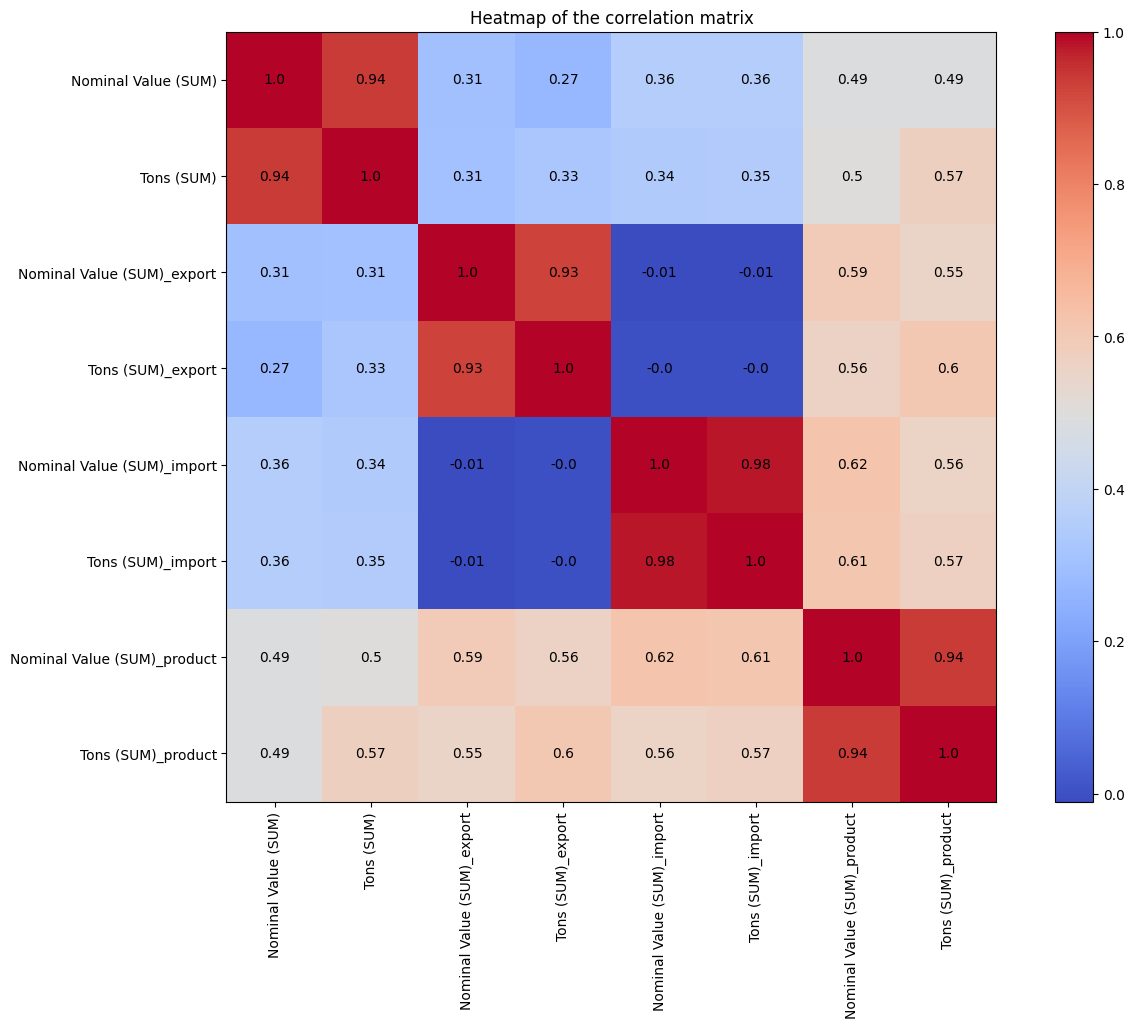

The pearson correlation between 'likelihood' and Nominal Value (SUM) is -0.18708734251737538 with a p-value of 2.025211847792913e-06
The pearson correlation between 'likelihood' and Tons (SUM) is -0.16092597503945177 with a p-value of 4.561725353188709e-05
The pearson correlation between 'likelihood' and Nominal Value (SUM)_export is -0.08750054263469124 with a p-value of 0.027343949489770678
The pearson correlation between 'likelihood' and Tons (SUM)_export is 0.038133687067505875 with a p-value of 0.3369785130298413
The pearson correlation between 'likelihood' and Nominal Value (SUM)_import is 8.747659890333617e-05 with a p-value of 0.9982432701614665
The pearson correlation between 'likelihood' and Tons (SUM)_import is 0.0019173787184940151 with a p-value of 0.961509532096947
The pearson correlation between 'likelihood' and Nominal Value (SUM)_product is -0.06193061237876775 with a p-value of 0.11869936657288993
The pearson correlation between 'likelihood' and Tons (SUM)_product is 

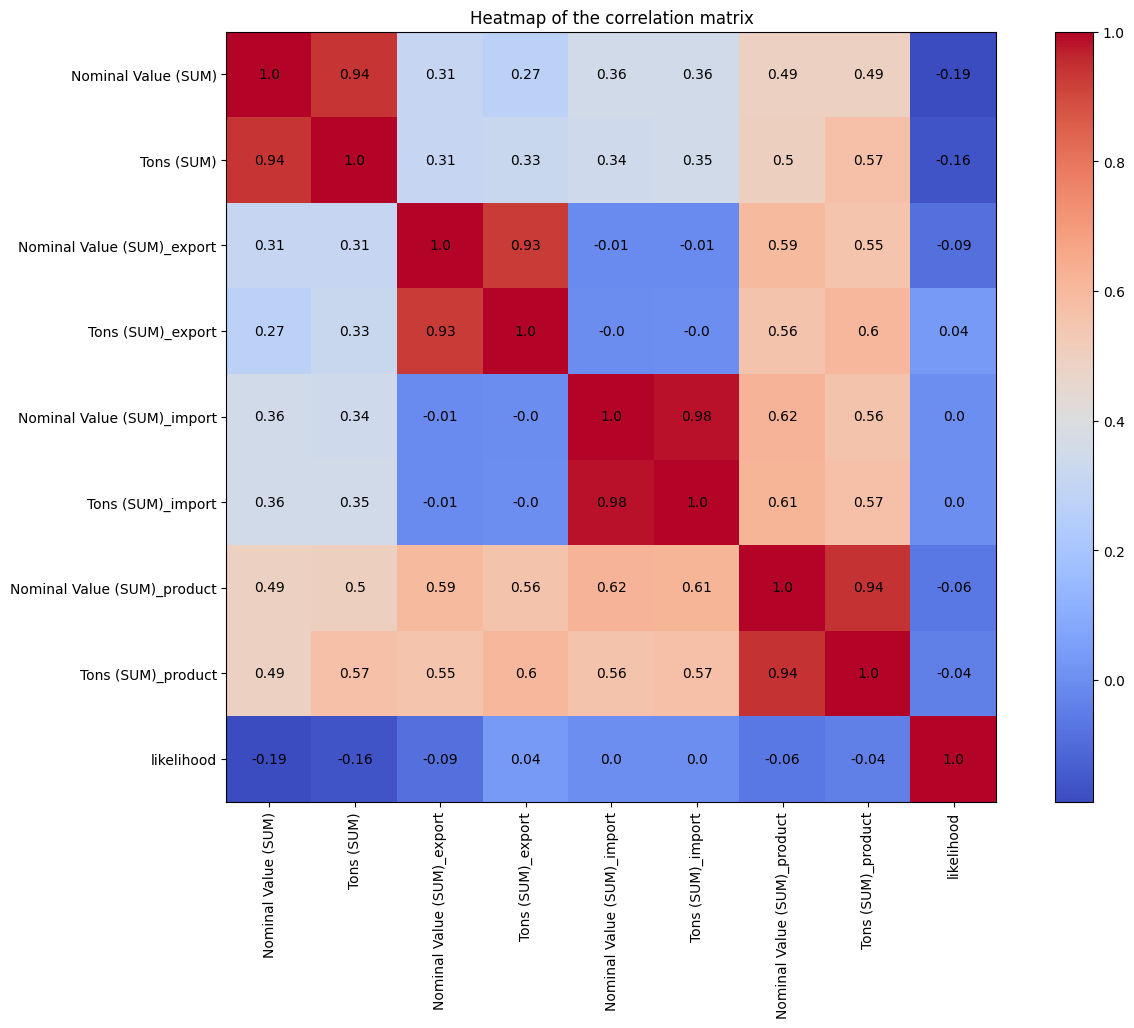

In [25]:
# load the goal countries
df_goal = pd.read_csv("finalVersion/topExporters.csv")

# load the data from the csv file
df = pd.read_csv("finalVersion/filtered_byPrice.csv")

# group the data by "Export_country" and calculate the total export value and the total export volume
df_export_total = df.groupby(["Export_country"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# filter the data by the goal countries
df_export_total = df_export_total[df_export_total["Export_country"].isin(df_goal["Country"])].reset_index(drop=True)
print(df_export_total.head())

# group the data by "Import_country" and calculate the total import value and the total import volume
df_import_total = df.groupby(["Import_country"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# filter the data by the goal countries
df_import_total = df_import_total[df_import_total["Import_country"].isin(df_goal["Country"])].reset_index(drop=True)
print(df_import_total.head())

# caculate the trade volume and trade value for each pair of countries
df_pair = df.groupby(["Export_country", "Import_country"]).agg({"Nominal Value (SUM)": "sum", "Tons (SUM)": "sum"}).reset_index()
# filter the data by the goal countries
df_pair = df_pair[df_pair["Export_country"].isin(df_goal["Country"]) & df_pair["Import_country"].isin(df_goal["Country"])].reset_index(drop=True)
print(df_pair.head())

# merge the df_export_total and df_import_total into df_pair
df_pair = pd.merge(df_pair, df_export_total, left_on="Export_country", right_on="Export_country", how="left", suffixes=("", "_export"))
df_pair = pd.merge(df_pair, df_import_total, left_on="Import_country", right_on="Import_country", how="left", suffixes=("", "_import"))
print(df_pair.head())

# calculate the multiplification of the "Nominal Value (SUM)_export" and "Nominal Value (SUM)_import"
df_pair["Nominal Value (SUM)_product"] = df_pair["Nominal Value (SUM)_export"] * df_pair["Nominal Value (SUM)_import"]

# calculate the multiplification of the "Tons (SUM)_export" and "Tons (SUM)_import"
df_pair["Tons (SUM)_product"] = df_pair["Tons (SUM)_export"] * df_pair["Tons (SUM)_import"]

# save the data to a csv file
df_pair.to_csv("finalVersion/pair_pulling_pushing.csv", index=False)

# drop the columns "Export_country" and "Import_country" and the "Nominal Value" columns
df_pair_without_country = df_pair.drop(columns=["Export_country", "Import_country"])
# caculate the correlation matrix of the data without the country names
correlationMatrix = df_pair_without_country.corr()
# plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 10))
plt.imshow(correlationMatrix, cmap="coolwarm", interpolation="nearest")
# label the data with the correlationMatrix
for i in range(len(correlationMatrix)):
    for j in range(len(correlationMatrix.columns)):
        plt.text(j, i, round(correlationMatrix.iloc[i, j], 2), ha="center", va="center", color="black")
plt.xticks(np.arange(len(correlationMatrix.columns)), correlationMatrix.columns, rotation=90)
plt.yticks(np.arange(len(correlationMatrix.index)), correlationMatrix.index)
plt.colorbar()
plt.title("Heatmap of the correlation matrix")
plt.show()

# load the data from the csv file
df_divergence = pd.read_csv("finalVersion/likelihood_export_and_import.csv")
# set the row index same as the column index
df_divergence.index = df_divergence.columns

# load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing.csv")
# add a new colume "likelihood" in the pair_pulling_pushing by matching the row index and column index of the likelihood matrix
df["likelihood"] = df.apply(lambda x: df_divergence.loc[x["Export_country"], x["Import_country"]], axis=1)   

# do the pearson correlation between the "likelihood" and other columns
for column in df.columns:
    if column != "Export_country" and column != "Import_country":
        correlation,p = stats.pearsonr(df["likelihood"], df[column])
        print("The pearson correlation between 'likelihood' and", column, "is", correlation, "with a p-value of", p)
        
# caculate the correlation between "likelihood" and other columns
# drop the columns "Export_country" and "Import_country" and the "Nominal Value" columns
df_pair_without_country = df.drop(columns=["Export_country", "Import_country"])
# caculate the correlation matrix of the data without the country names
correlationMatrix = df_pair_without_country.corr()
# plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 10))
plt.imshow(correlationMatrix, cmap="coolwarm", interpolation="nearest")
# label the data with the correlationMatrix
for i in range(len(correlationMatrix)):
    for j in range(len(correlationMatrix.columns)):
        plt.text(j, i, round(correlationMatrix.iloc[i, j], 2), ha="center", va="center", color="black")
plt.xticks(np.arange(len(correlationMatrix.columns)), correlationMatrix.columns, rotation=90)
plt.yticks(np.arange(len(correlationMatrix.index)), correlationMatrix.index)
plt.colorbar()
plt.title("Heatmap of the correlation matrix")
plt.show()


  Export_country    Import_country        2011        2012        2013  \
0        Austria           Belgium   73.626716   76.003992   74.867367   
1        Austria            Brazil  151.352142  164.061382  163.695798   
2        Austria            Canada  124.609160  127.779179  119.704285   
3        Austria  China (mainland)  121.864112  127.026438  126.756990   
4        Austria            France   67.534460   68.422791   67.625872   

         2014        2015        2016        2017        2018        2019  \
0   75.003309   79.935956   78.774150   75.237596   71.934294   69.427146   
1  162.043283  157.798286  168.289525  156.574300  144.184710  152.361580   
2  127.570961  126.578295  135.617597  123.465145  130.194226         NaN   
3  124.152587  125.714918  128.460933  124.647971  124.068273  121.912844   
4   66.748880   69.172232   70.282505   64.522054   65.480531   66.075456   

         2020        2021  
0   69.820903   60.963963  
1  150.692324  146.376907  
2       

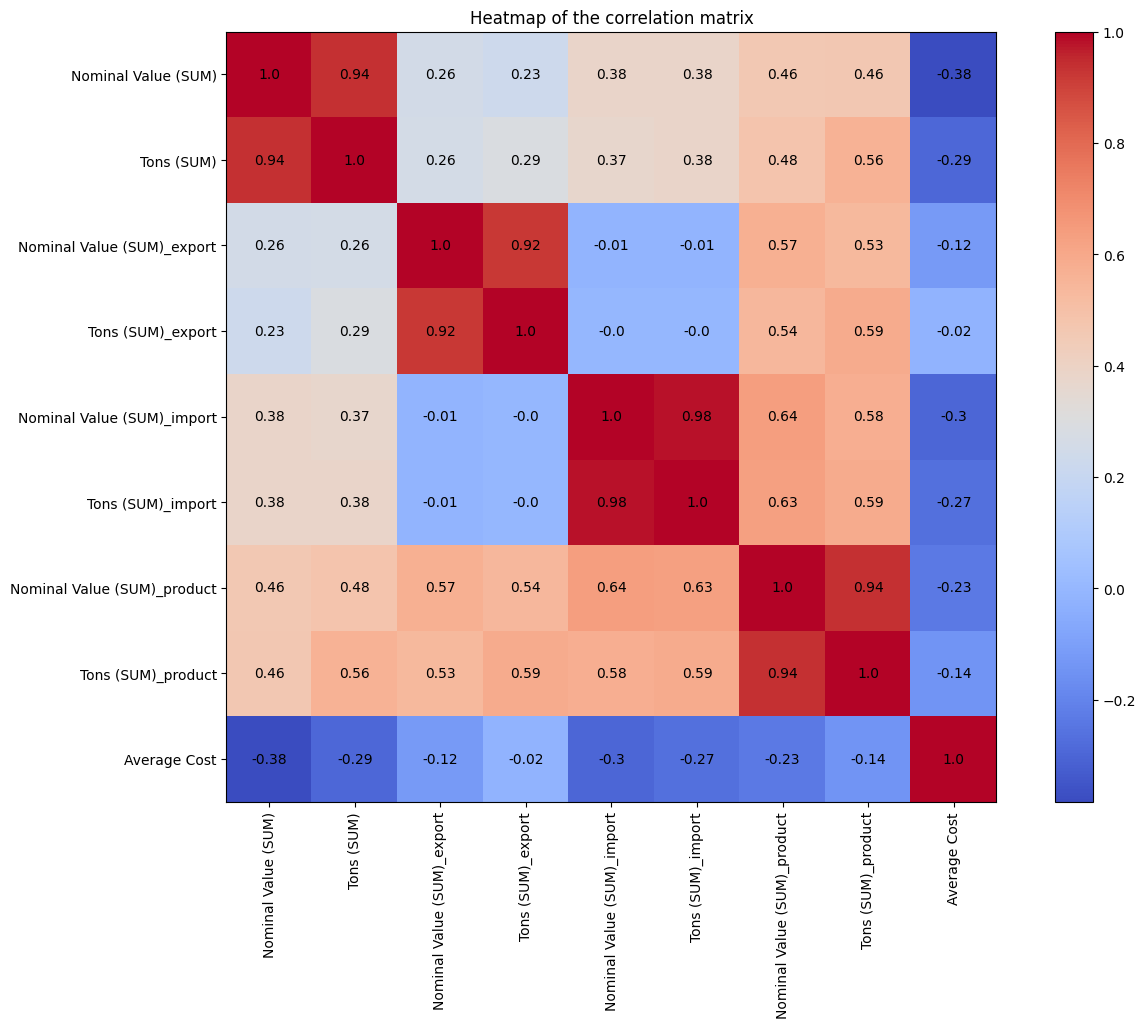

In [26]:
# load the data from the csv file whose columns are Export_country,Import_country,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
df_tradeCost = pd.read_csv("finalVersion/trade_cost.csv")
print(df_tradeCost.head())
# drop the rows with "Taiwan","Netherlands","Vietnam","Slovakia"
df_tradeCost = df_tradeCost[~df_tradeCost["Export_country"].isin(["Taiwan","Netherlands","Vietnam","Slovakia"])]
df_tradeCost = df_tradeCost[~df_tradeCost["Import_country"].isin(["Taiwan","Netherlands","Vietnam","Slovakia"])]
# find the empty cell and fill it with NaN
df_tradeCost = df_tradeCost.replace("", np.nan)
# calculate the average value of each row except the first 2 columns
df_tradeCost["Average Cost"] = df_tradeCost.iloc[:, 2:].mean(axis=1)
print(df_tradeCost.head())

# load the pair_pulling_pushing data
df_pair = pd.read_csv("finalVersion/pair_pulling_pushing.csv")
# drop the rows with "Taiwan","Netherlands","Vietnam","Slovakia"
df_pair = df_pair[~df_pair["Export_country"].isin(["Taiwan","Netherlands","Vietnam","Slovakia"])]
df_pair = df_pair[~df_pair["Import_country"].isin(["Taiwan","Netherlands","Vietnam","Slovakia"])]
# merge the "Average Cost" column of df_tradeCost into df_pair
df_pair = pd.merge(df_pair, df_tradeCost[["Export_country", "Import_country", "Average Cost"]], left_on=["Export_country", "Import_country"], right_on=["Export_country", "Import_country"], how="left")
# save the data to a csv file
df_pair.to_csv("finalVersion/pair_pulling_pushing_tradeCost.csv", index=False)
print(df_pair.head())
print(df_pair.isnull().sum())
print(df_pair[df_pair["Average Cost"].isnull()])
# print the top 3 export countries and the top 3 import countries in the rows with NaN
print(df_pair[df_pair["Average Cost"].isnull()]["Export_country"].value_counts())
print(df_pair[df_pair["Average Cost"].isnull()]["Import_country"].value_counts())

# calculate the correlation between the "Tons (SUM)" and the "Average Cost"
correlation = np.corrcoef(df_pair["Tons (SUM)"], 1/(df_pair["Average Cost"]))[0, 1]
print("The correlation between the 'Tons (SUM)' and the 'Average Cost' is", correlation)

# calculate the correlation between the "Nominal Value (SUM)" and the "Average Cost"
correlation = np.corrcoef(df_pair["Nominal Value (SUM)"], 1/(df_pair["Average Cost"]))[0, 1]
print("The correlation between the 'Nominal Value (SUM)' and the 'Average Cost' is", correlation)

# using stats.pearsonr to get the coefficient and the p-value of each pair of columns
for column in df_pair.columns[2:]:
    for column2 in df_pair.columns[2:]:
        if column != column2:
            correlation, p_value = stats.pearsonr(df_pair[column], df_pair[column2])
            # store the correlation and p-value in a csv file
            print("The correlation between", column, "and", column2, "is", correlation, "with p-value", p_value)


# drop the columns "Export_country" and "Import_country"
df_pair_without_country = df_pair.drop(columns=["Export_country", "Import_country"])
# plot the correlation matrix of the data
correlationMatrix = df_pair_without_country.corr()
plt.figure(figsize=(15, 10))
plt.imshow(correlationMatrix, cmap="coolwarm", interpolation="nearest")
for i in range(len(correlationMatrix)):
    for j in range(len(correlationMatrix.columns)):
        plt.text(j, i, round(correlationMatrix.iloc[i, j], 2), ha="center", va="center", color="black")
plt.xticks(np.arange(len(correlationMatrix.columns)), correlationMatrix.columns, rotation=90)
plt.yticks(np.arange(len(correlationMatrix.index)), correlationMatrix.index)
plt.colorbar()
plt.title("Heatmap of the correlation matrix")
plt.show()


  Export_country    Import_country  Nominal Value (SUM)     Tons (SUM)  \
0        Austria           Belgium         3.407750e+08  394924.387851   
1        Austria            Brazil         6.749310e+07   55781.338341   
2        Austria            Canada         2.699922e+06    1308.909264   
3        Austria  China (mainland)         6.605876e+07   39008.215116   
4        Austria            France         9.416162e+08  709415.638619   

   Nominal Value (SUM)_export  Tons (SUM)_export  Nominal Value (SUM)_import  \
0                2.037138e+10       1.997465e+07                3.247987e+10   
1                2.037138e+10       1.997465e+07                8.298700e+09   
2                2.037138e+10       1.997465e+07                2.183140e+10   
3                2.037138e+10       1.997465e+07                7.775913e+10   
4                2.037138e+10       1.997465e+07                5.154463e+10   

   Tons (SUM)_import  Nominal Value (SUM)_product  Tons (SUM)_product  \
0

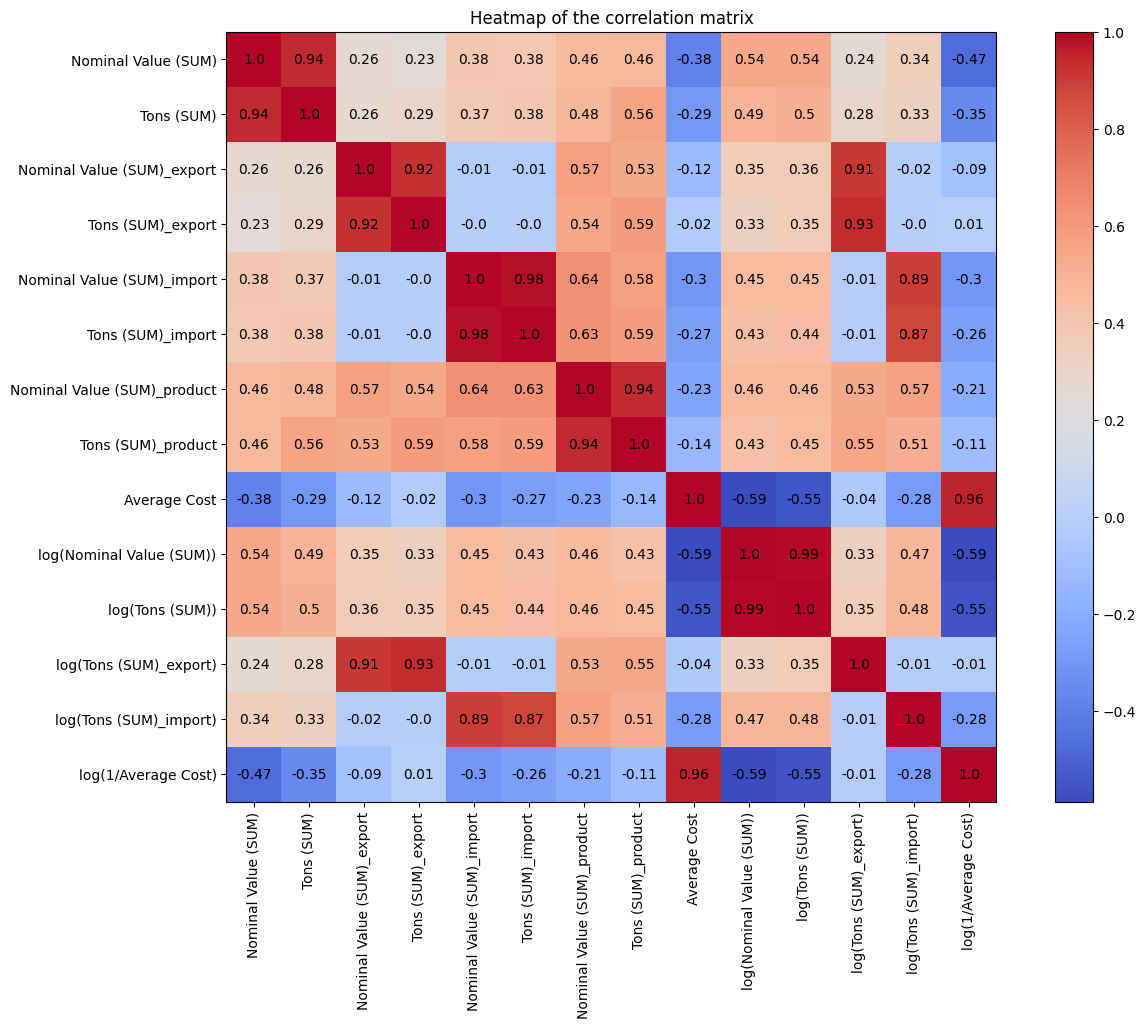

     log(Nominal Value (SUM))  log(Tons (SUM)_export)  log(Tons (SUM)_import)  \
0                   19.646733               16.809974               17.675746   
1                   18.027536               16.809974               16.054078   
2                   14.808734               16.809974               16.890399   
3                   18.006055               16.809974               18.482169   
4                   20.663108               16.809974               17.830702   
..                        ...                     ...                     ...   
446                 19.602023               17.415456               17.943238   
447                 19.308155               17.415456               17.536619   
448                 16.971488               17.415456               15.812725   
449                 14.644106               17.415456               14.911926   
450                 17.780917               17.415456               16.530409   

     log(1/Average Cost)  


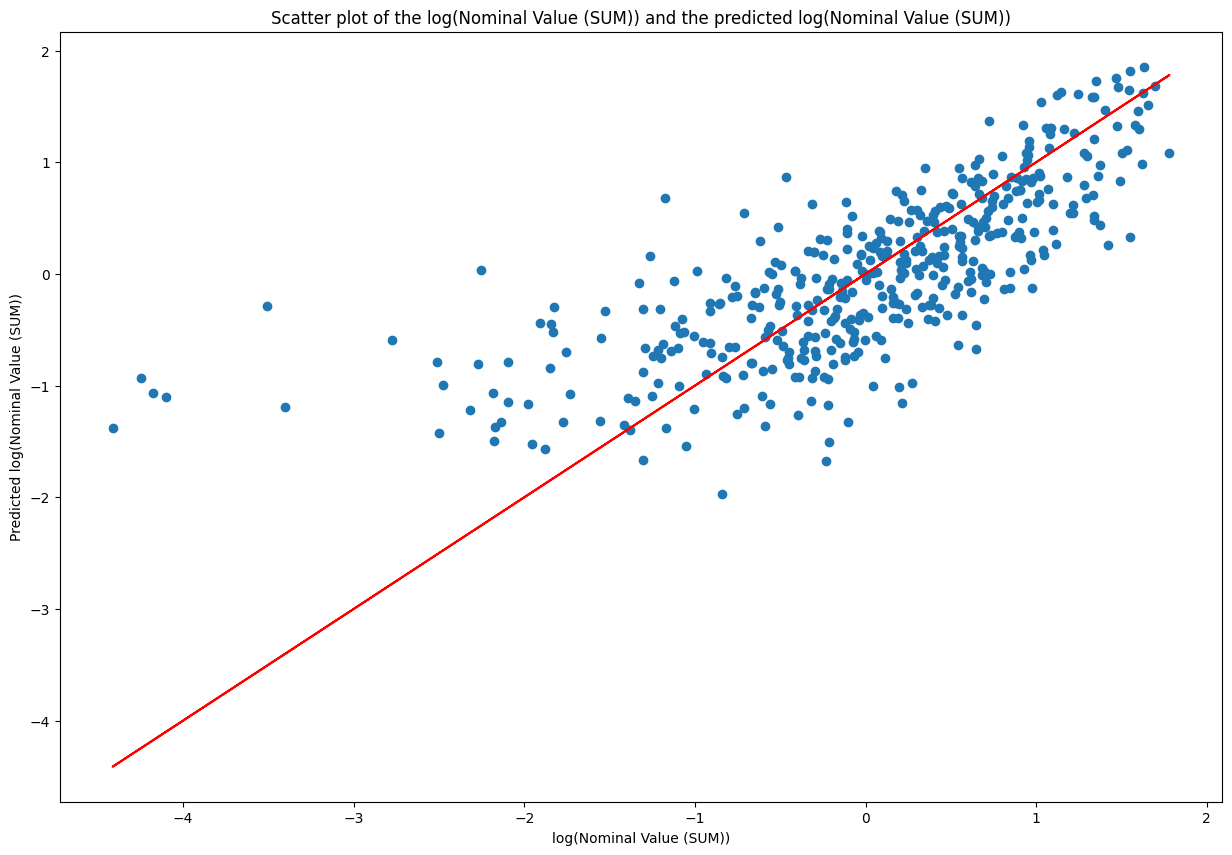

In [27]:
# load the data from the csv file 
from sklearn.feature_selection import f_regression


df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost.csv")
print(df.head())

# calculate log("Nominal Value (SUM)"), log("Tons (SUM)"), log("Tons (SUM)_export"), log("Tons (SUM)_import"), log("1/Average Cost")
df["log(Nominal Value (SUM))"] = np.log(df["Nominal Value (SUM)"])
df["log(Tons (SUM))"] = np.log(df["Tons (SUM)"])
df["log(Tons (SUM)_export)"] = np.log(df["Tons (SUM)_export"])
df["log(Tons (SUM)_import)"] = np.log(df["Tons (SUM)_import"])
df["log(1/Average Cost)"] = np.log(df["Average Cost"])

# drop the first 2 columns
df_1 = df.drop(columns=["Export_country", "Import_country"])
# caculate the correlation of the dataframes
correlationMatrix = df_1.corr()
plt.figure(figsize=(15, 10))
plt.imshow(correlationMatrix, cmap="coolwarm", interpolation="nearest")
for i in range(len(correlationMatrix)):
    for j in range(len(correlationMatrix.columns)):
        plt.text(j, i, round(correlationMatrix.iloc[i, j], 2), ha="center", va="center", color="black")
plt.xticks(np.arange(len(correlationMatrix.columns)), correlationMatrix.columns, rotation=90)
plt.yticks(np.arange(len(correlationMatrix.index)), correlationMatrix.index)
plt.colorbar()
plt.title("Heatmap of the correlation matrix")
plt.show()

# crate a new dataframe to store the country names and the log data
df_log = df[["Export_country", "Import_country", "log(Nominal Value (SUM))", "log(Tons (SUM)_export)", "log(Tons (SUM)_import)", "log(1/Average Cost)"]]
# df_log = df[["Export_country", "Import_country", "log(Tons (SUM))", "log(Tons (SUM)_export)", "log(Tons (SUM)_import)", "log(1/Average Cost)"]]

# drop the columns "Export_country" and "Import_country"
df_log = df_log.drop(columns=["Export_country", "Import_country"])

# standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_log)
print(df_log)
print(df_scaled)

# df_scaled = df_log.values

# do a linear regression on the data with the log("Nominal Value (SUM)") as the dependent variable and the other columns as the independent variables
regression = LinearRegression()
regression.fit(df_scaled[:, 1:], df_scaled[:, 0])
# print the coefficients
print("The coefficients are", regression.coef_)
# print the intercept
print("The intercept is", regression.intercept_)
# print the R^2 value
print("The R^2 value is", regression.score(df_scaled[:, 1:], df_scaled[:, 0]))



# # print the mean squared error
# print("The mean squared error is", mean_squared_error(df_scaled[:, 0], regression.predict(df_scaled[:, 1:])))
# # # print the mean absolute error
# # print("The mean absolute error is", mean_absolute_error(df_scaled[:, 0], regression.predict(df_scaled[:, 1:])))
# # # print the explained variance score
# # print("The explained variance score is", explained_variance_score(df_scaled[:, 0], regression.predict(df_scaled[:, 1:])))
# # print the F-test
# print("The pvalue of the coefficients are", f_regression(df_scaled[:, 1:], df_scaled[:, 0])[1])

# plot the scatter plot of the log("Nominal Value (SUM)") and the predicted log("Nominal Value (SUM)")
plt.figure(figsize=(15, 10))
plt.scatter(df_scaled[:, 0], regression.predict(df_scaled[:, 1:]))
# draw the line y = x
plt.plot(df_scaled[:, 0], df_scaled[:, 0], color="red")
plt.xlabel("log(Nominal Value (SUM))")
plt.ylabel("Predicted log(Nominal Value (SUM))")
plt.title("Scatter plot of the log(Nominal Value (SUM)) and the predicted log(Nominal Value (SUM))")
plt.show()


In [28]:
# load the ratio import and the ratio export
df_ratio_export = pd.read_csv("finalVersion/ratio_export.csv")
df_ratio_import = pd.read_csv("finalVersion/ratio_import.csv")

likelihood_export_and_import = np.zeros((len(df_ratio_export), len(df_ratio_import)))

for i in range(len(df_ratio_export)):
    for j in range(len(df_ratio_import)):
        # calculate the likelihood between the export value of each pair of countries and the import value of each pair of countries
        likelihood_export_and_import[i,j] = jensenshannon(df_ratio_export.iloc[i,1:].astype(float),df_ratio_import.iloc[j,1:].astype(float))

likelihood_export_and_import = pd.DataFrame(likelihood_export_and_import, columns=df_store["Import_country"], index=df_store["Import_country"])

# load the data from the csv file 
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost.csv")
print(df.head())

  Export_country    Import_country  Nominal Value (SUM)     Tons (SUM)  \
0        Austria           Belgium         3.407750e+08  394924.387851   
1        Austria            Brazil         6.749310e+07   55781.338341   
2        Austria            Canada         2.699922e+06    1308.909264   
3        Austria  China (mainland)         6.605876e+07   39008.215116   
4        Austria            France         9.416162e+08  709415.638619   

   Nominal Value (SUM)_export  Tons (SUM)_export  Nominal Value (SUM)_import  \
0                2.037138e+10       1.997465e+07                3.247987e+10   
1                2.037138e+10       1.997465e+07                8.298700e+09   
2                2.037138e+10       1.997465e+07                2.183140e+10   
3                2.037138e+10       1.997465e+07                7.775913e+10   
4                2.037138e+10       1.997465e+07                5.154463e+10   

   Tons (SUM)_import  Nominal Value (SUM)_product  Tons (SUM)_product  \
0

## regression

Index(['Export_country', 'Import_country', 'Nominal Value (SUM)', 'Tons (SUM)',
       'Nominal Value (SUM)_export', 'Tons (SUM)_export',
       'Nominal Value (SUM)_import', 'Tons (SUM)_import',
       'Nominal Value (SUM)_product', 'Tons (SUM)_product', 'Average Cost'],
      dtype='object')


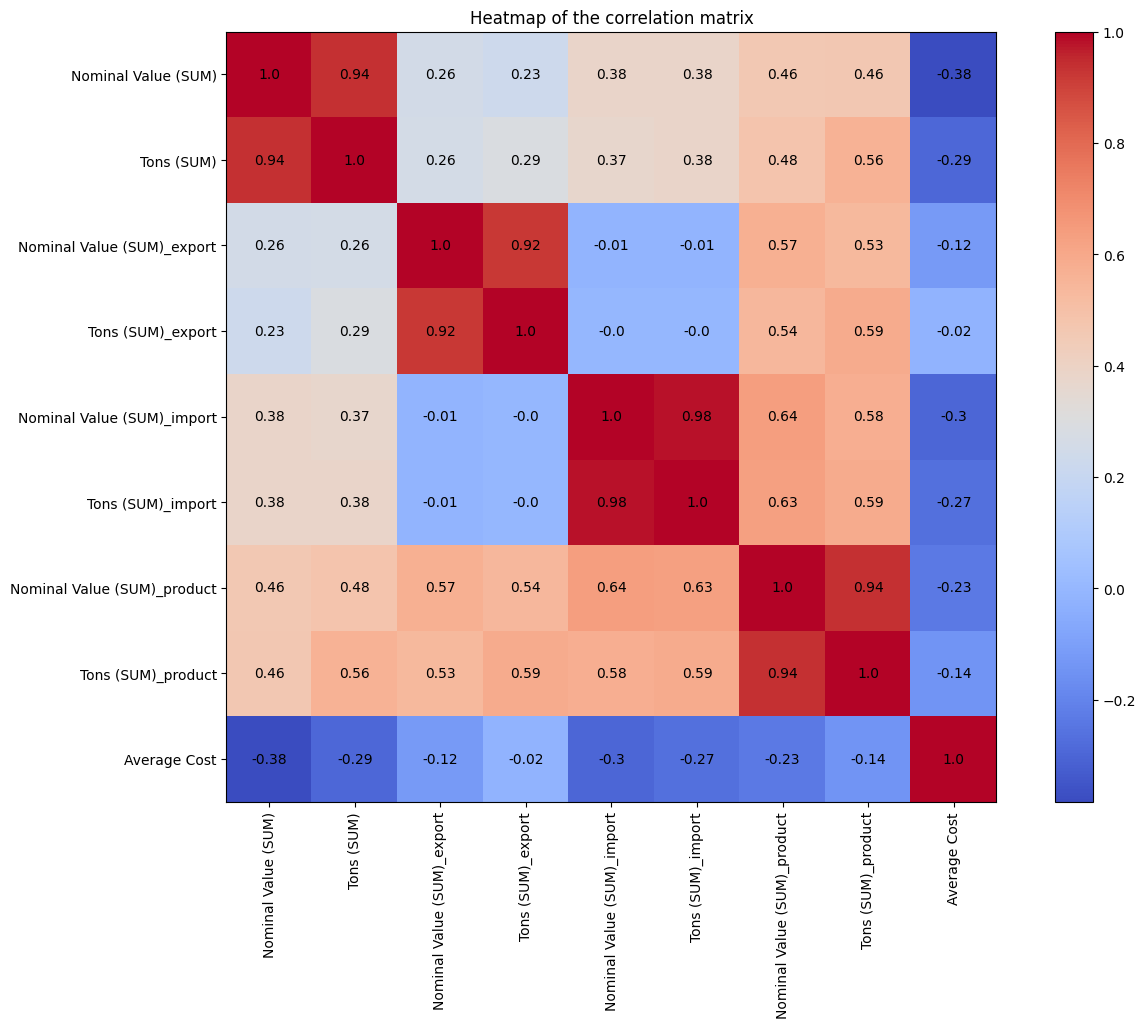

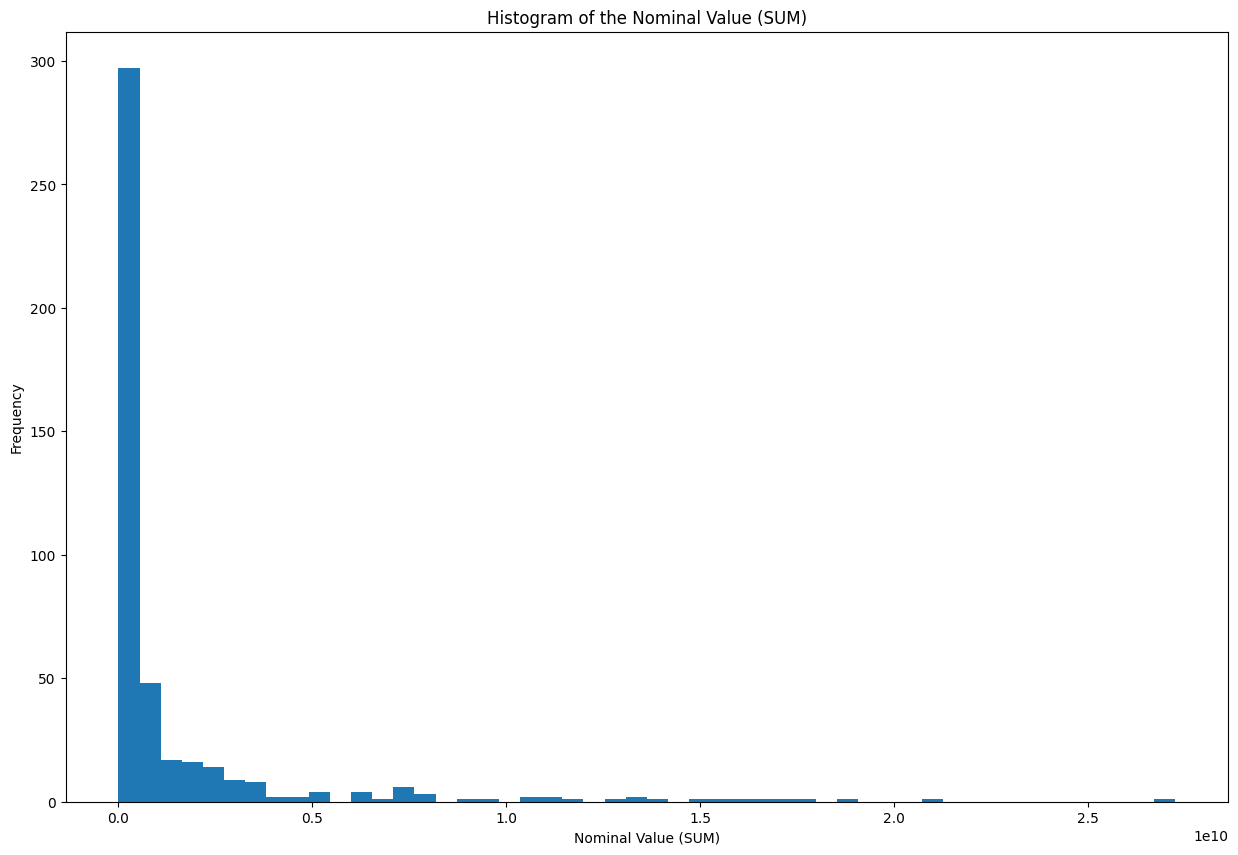

In [29]:
# load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost.csv")
print(df.columns)

# calculate the correlation matrix
# drop the columns "Export_country" and "Import_country"
df_pair_without_country = df.drop(columns=["Export_country", "Import_country"])
df_corr = df_pair_without_country.corr()
# plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 10))
plt.imshow(df_corr, cmap="coolwarm", interpolation="nearest")
# label the data with the correlationMatrix
for i in range(len(df_corr)):
    for j in range(len(df_corr.columns)):
        plt.text(j, i, round(df_corr.iloc[i, j], 2), ha="center", va="center", color="black")
plt.xticks(np.arange(len(df_corr.columns)), df_corr.columns, rotation=90)
plt.yticks(np.arange(len(df_corr.columns)), df_corr.columns)
plt.colorbar()
plt.title("Heatmap of the correlation matrix")
plt.show()

# plot the distribution of the "Nominal Value (SUM)"
plt.figure(figsize=(15, 10))
plt.hist(df["Nominal Value (SUM)"], bins=50)
plt.xlabel("Nominal Value (SUM)")
plt.ylabel("Frequency")
plt.title("Histogram of the Nominal Value (SUM)")
plt.show()

The correlation between log(Nominal Value (SUM)) and log(Tons (SUM)) is 0.9900609062263945 with p-value 0.0
The correlation between log(Nominal Value (SUM)) and log(Nominal Value (SUM)_export) is 0.3556758361490425 with p-value 6.7770266922737356e-15
The correlation between log(Nominal Value (SUM)) and log(Tons (SUM)_export) is 0.3270104657280763 with p-value 1.0628422247329616e-12
The correlation between log(Nominal Value (SUM)) and log(Nominal Value (SUM)_import) is 0.47572702002625955 with p-value 7.54209449046443e-27
The correlation between log(Nominal Value (SUM)) and log(Tons (SUM)_import) is 0.4707729381387178 with p-value 2.958540576745741e-26
The correlation between log(Nominal Value (SUM)) and log(Nominal Value (SUM)_product) is 0.599891091036368 with p-value 2.0096309574863075e-45
The correlation between log(Nominal Value (SUM)) and log(Tons (SUM)_product) is 0.5743622001309938 with p-value 6.080958016313684e-41
The correlation between log(Nominal Value (SUM)) and log(Averag

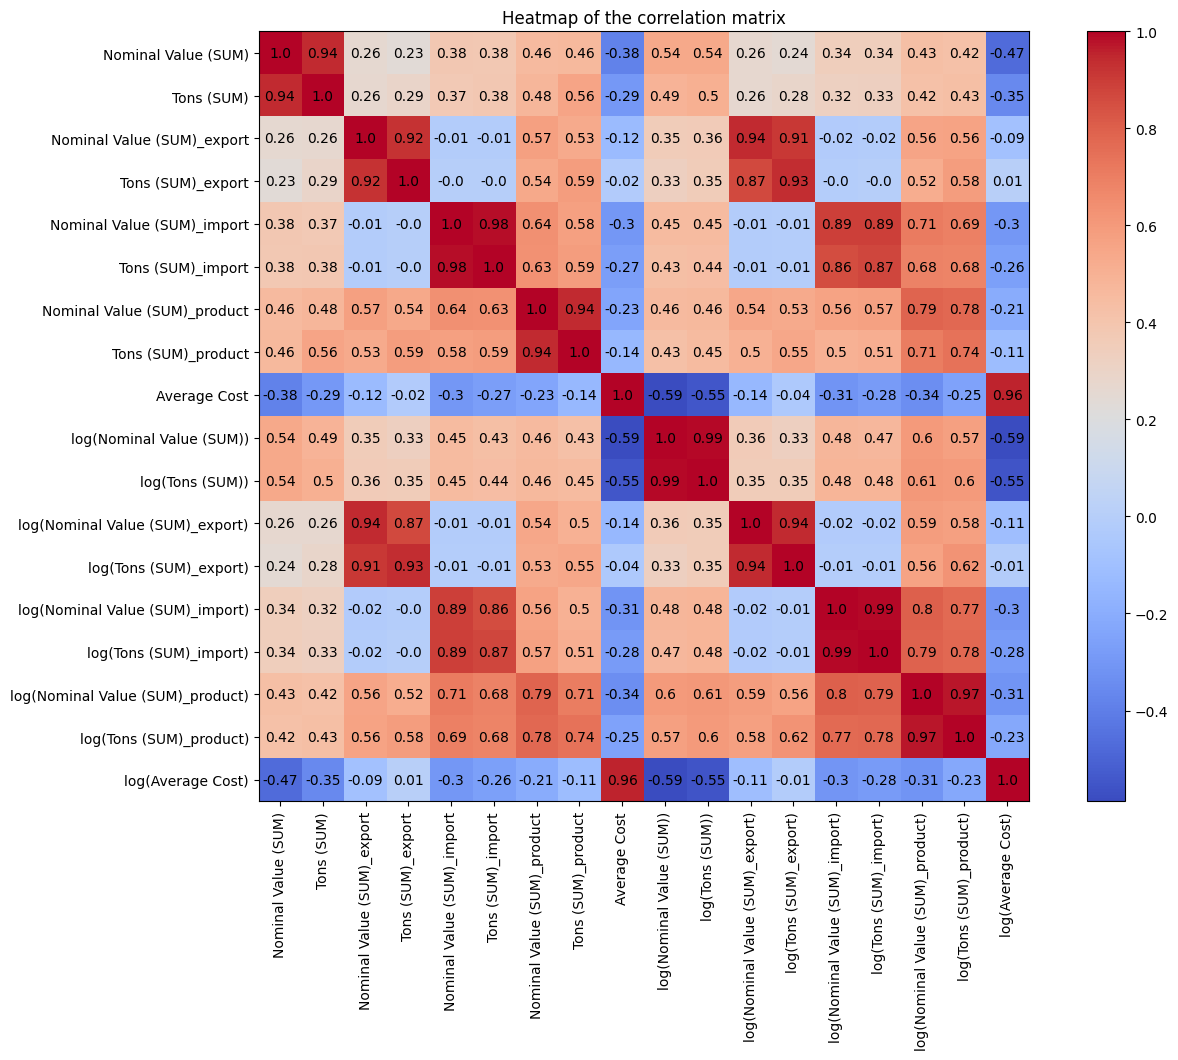

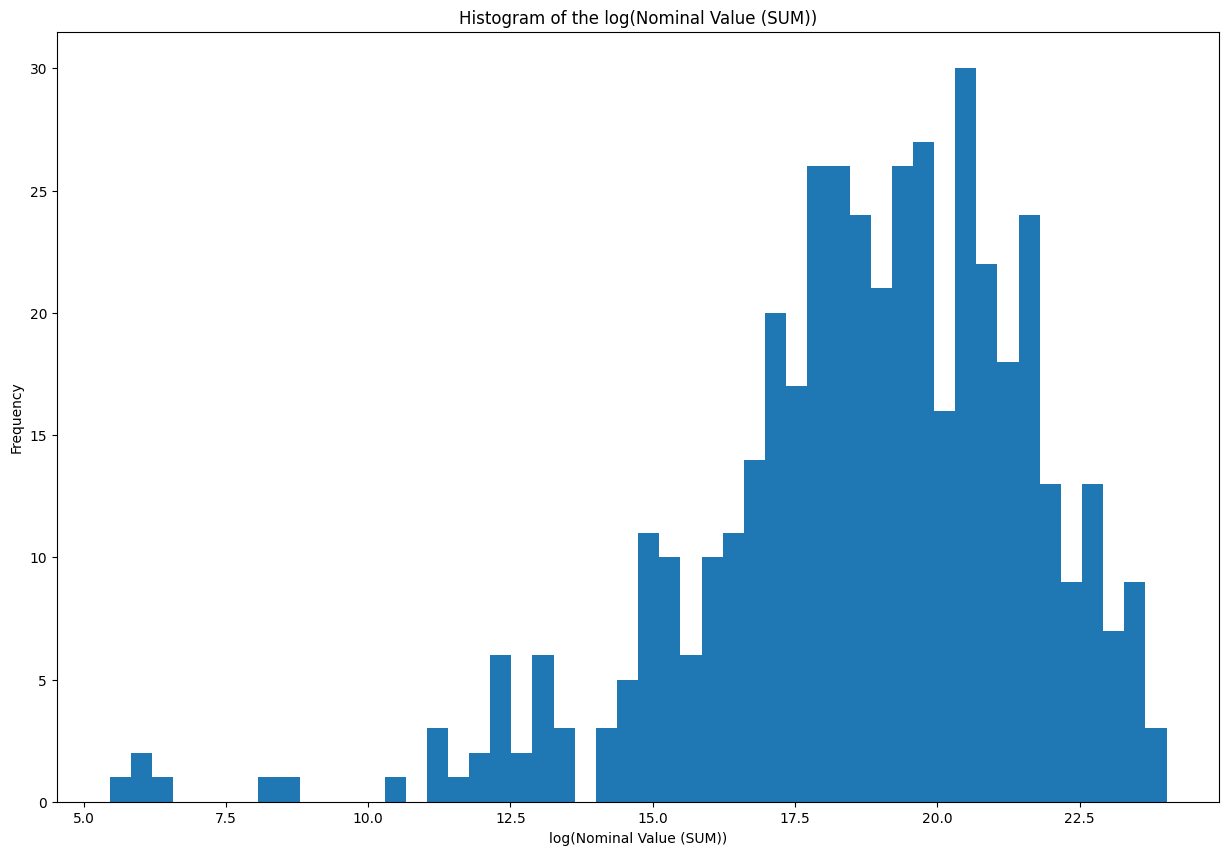

The mean is 18.68882573705284
The standard deviation is 2.997458831024039
The p-value of the K-S test is 0.014288409515040727
The mean is 17.144646041998868
The standard deviation is 1.0923578388289097
The p-value of the K-S test is 4.133984349936742e-05


In [66]:
# load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost.csv")

# take the log of each column
df["log(Nominal Value (SUM))"] = np.log(df["Nominal Value (SUM)"])
df["log(Tons (SUM))"] = np.log(df["Tons (SUM)"])
df["log(Nominal Value (SUM)_export)"] = np.log(df["Nominal Value (SUM)_export"])
df["log(Tons (SUM)_export)"] = np.log(df["Tons (SUM)_export"])
df["log(Nominal Value (SUM)_import)"] = np.log(df["Nominal Value (SUM)_import"])
df["log(Tons (SUM)_import)"] = np.log(df["Tons (SUM)_import"])
df["log(Nominal Value (SUM)_product)"] = np.log(df["Nominal Value (SUM)_product"])
df["log(Tons (SUM)_product)"] = np.log(df["Tons (SUM)_product"])
df["log(Average Cost)"] = np.log(df["Average Cost"])

# drop the first 2 columns and the non-log columns
df_1 = df.copy()
df_1 = df_1.drop(columns=["Nominal Value (SUM)", "Tons (SUM)", "Nominal Value (SUM)_export", "Tons (SUM)_export", "Nominal Value (SUM)_import", "Tons (SUM)_import", "Nominal Value (SUM)_product", "Tons (SUM)_product", "Average Cost"])
# using stats.pearsonr to get the coefficient and the p-value of each pair of columns
for column in df_1.columns[2:]:
    for column2 in df_1.columns[2:]:
        if column != column2:
            correlation, p_value = stats.pearsonr(df_1[column], df_1[column2])
            # store the correlation and p-value in a csv file
            print("The correlation between", column, "and", column2, "is", correlation, "with p-value", p_value)
df_1 = df.drop(columns=["Export_country", "Import_country"])
# caculate the correlation of the dataframes
correlationMatrix = df_1.corr()
plt.figure(figsize=(15, 10))
plt.imshow(correlationMatrix, cmap="coolwarm", interpolation="nearest")
for i in range(len(correlationMatrix)):
    for j in range(len(correlationMatrix.columns)):
        plt.text(j, i, round(correlationMatrix.iloc[i, j], 2), ha="center", va="center", color="black")
plt.xticks(np.arange(len(correlationMatrix.columns)), correlationMatrix.columns, rotation=90)
plt.yticks(np.arange(len(correlationMatrix.index)), correlationMatrix.index)
plt.colorbar()
plt.title("Heatmap of the correlation matrix")
plt.show()

# save the data to a csv file
df_1.to_csv("finalVersion/pair_pulling_pushing_tradeCost_log.csv", index=False)

# plot the distribution of the "log(Nominal Value (SUM))"
plt.figure(figsize=(15, 10))
plt.hist(df["log(Nominal Value (SUM))"], bins=50)
plt.xlabel("log(Nominal Value (SUM))")
plt.ylabel("Frequency")
plt.title("Histogram of the log(Nominal Value (SUM))")
plt.show()

# fit the data to a normal distribution
mean, std = stats.norm.fit(df["log(Nominal Value (SUM))"])
print("The mean is", mean)
print("The standard deviation is", std)
# do K-S test on the "log(Nominal Value (SUM))"
statistic, pvalue = stats.kstest(df["log(Nominal Value (SUM))"], "norm", args=(mean, std))
print("The p-value of the K-S test is", pvalue)

# fit the data to a normal distribution
mean, std = stats.norm.fit(df["log(Tons (SUM)_import)"])
print("The mean is", mean)
print("The standard deviation is", std)
# do K-S test on the "log(Tons (SUM)_export)"
statistic, pvalue = stats.kstest(df["log(Tons (SUM)_import)"], "norm", args=(mean, std))
print("The p-value of the K-S test is", pvalue)



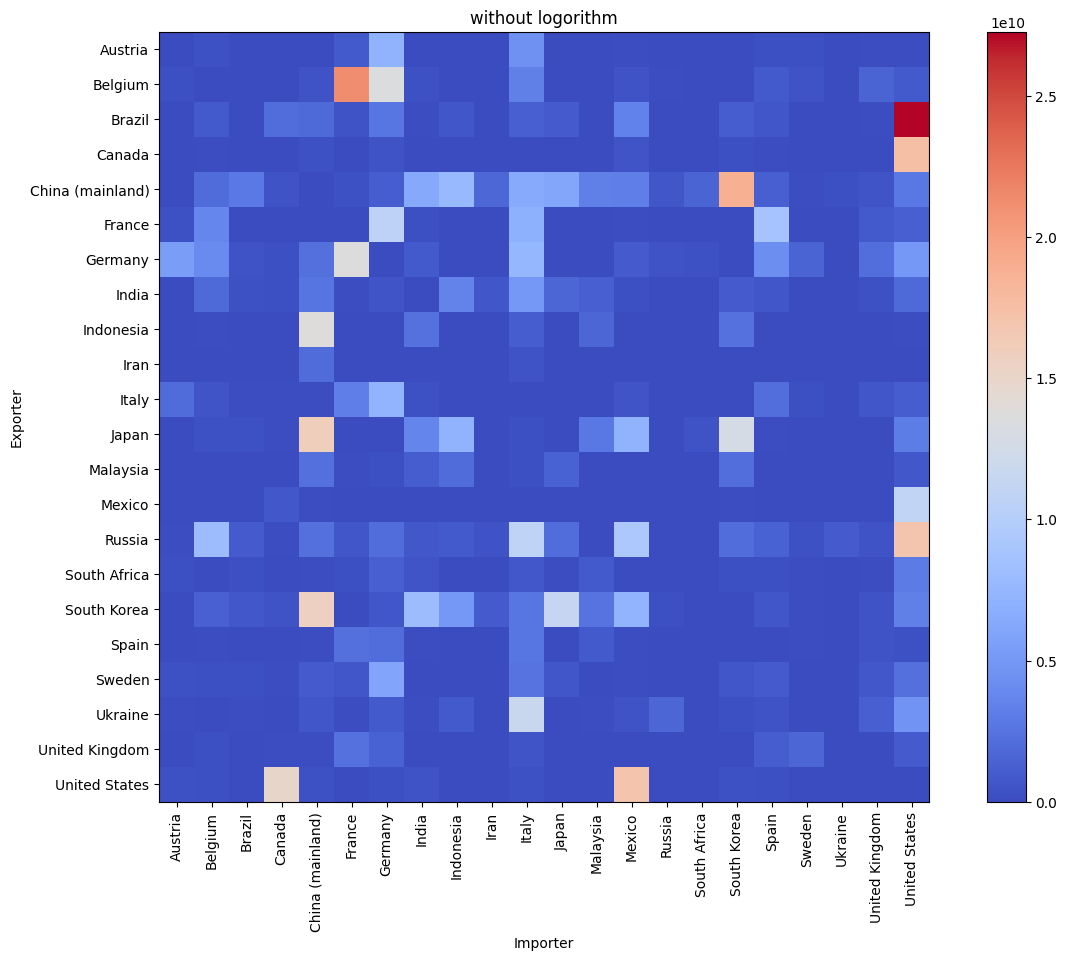

f:\anaconda\envs\FYP\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


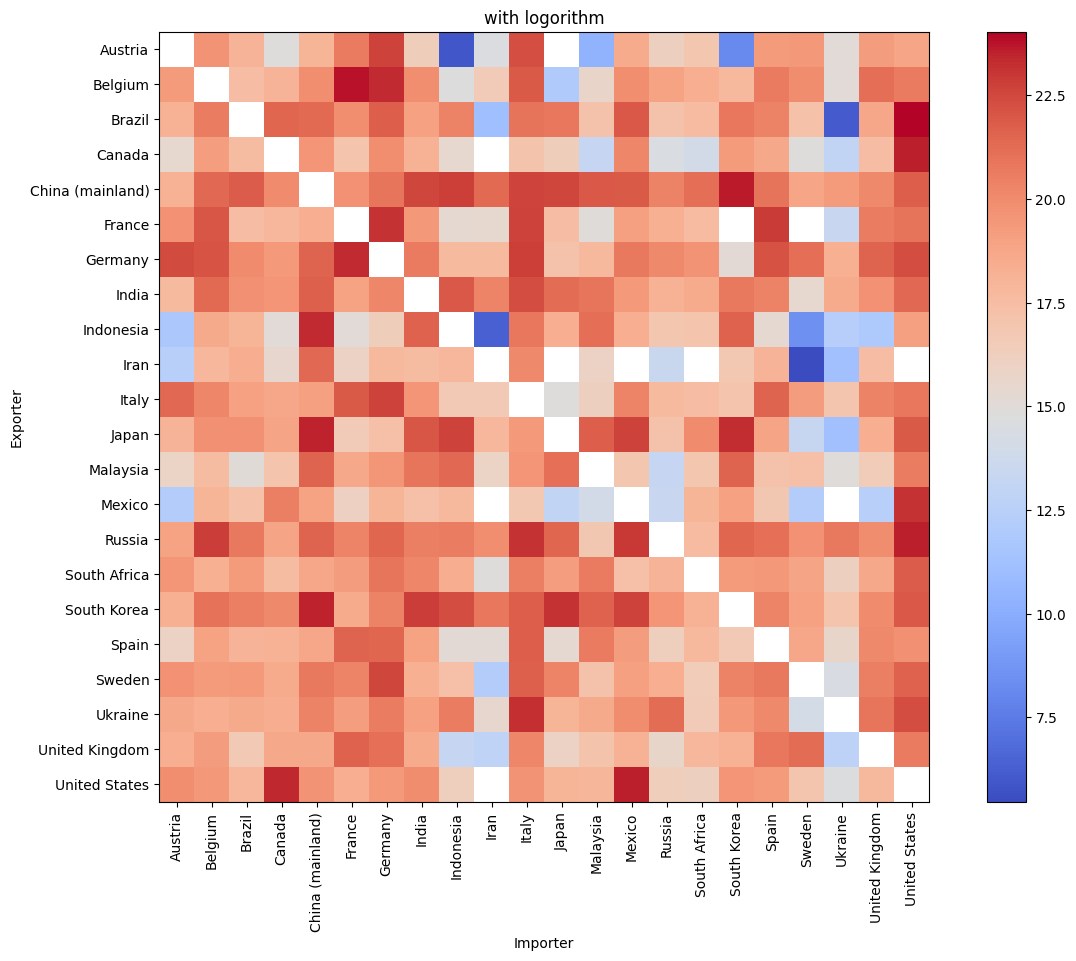

In [71]:
# Load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost.csv")

# get the unique values of the "Export_country"
countries = df["Export_country"].unique()

# set this as a new dataframe's index and column names
df_store = pd.DataFrame(index=countries, columns=countries)

# make the rows to be the exporters and the columns to be the importers, add the value of the "Nominal Value (SUM)" to the dataframe
for i in countries:
    for j in countries:
        df_store.loc[i, j] = df[(df["Export_country"] == i) & (df["Import_country"] == j)]["Nominal Value (SUM)"].sum()

# plot the heatmap of the "Nominal Value (SUM)"
plt.figure(figsize=(15, 10))
plt.imshow(df_store.astype(float), cmap="coolwarm", interpolation="nearest")
plt.xticks(np.arange(len(df_store.columns)), df_store.columns, rotation=90)
plt.yticks(np.arange(len(df_store.index)), df_store.index)
plt.xlabel("Importer")
plt.ylabel("Exporter")
plt.colorbar()
plt.title("without logorithm")
plt.show()

# plot the heat map with all the value to be log(value)
plt.figure(figsize=(15, 10))
plt.imshow(np.log(df_store.astype(float)), cmap="coolwarm", interpolation="nearest")
plt.xticks(np.arange(len(df_store.columns)), df_store.columns, rotation=90)
plt.yticks(np.arange(len(df_store.index)), df_store.index)
plt.xlabel("Importer")
plt.ylabel("Exporter")
plt.colorbar()
plt.title("with logorithm")
plt.show()

In [31]:
# load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost.csv")
# take the average value of "Tons (SUM)" column
average = df["Tons (SUM)"].mean()
print(average)

1857141.3875449316


                               OLS Regression Results                               
Dep. Variable:     log(Nominal Value (SUM))   R-squared:                       0.552
Model:                                  OLS   Adj. R-squared:                  0.549
Method:                       Least Squares   F-statistic:                     183.6
Date:                      Mon, 22 Apr 2024   Prob (F-statistic):           1.44e-77
Time:                              09:29:32   Log-Likelihood:                -953.96
No. Observations:                       451   AIC:                             1916.
Df Residuals:                           447   BIC:                             1932.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

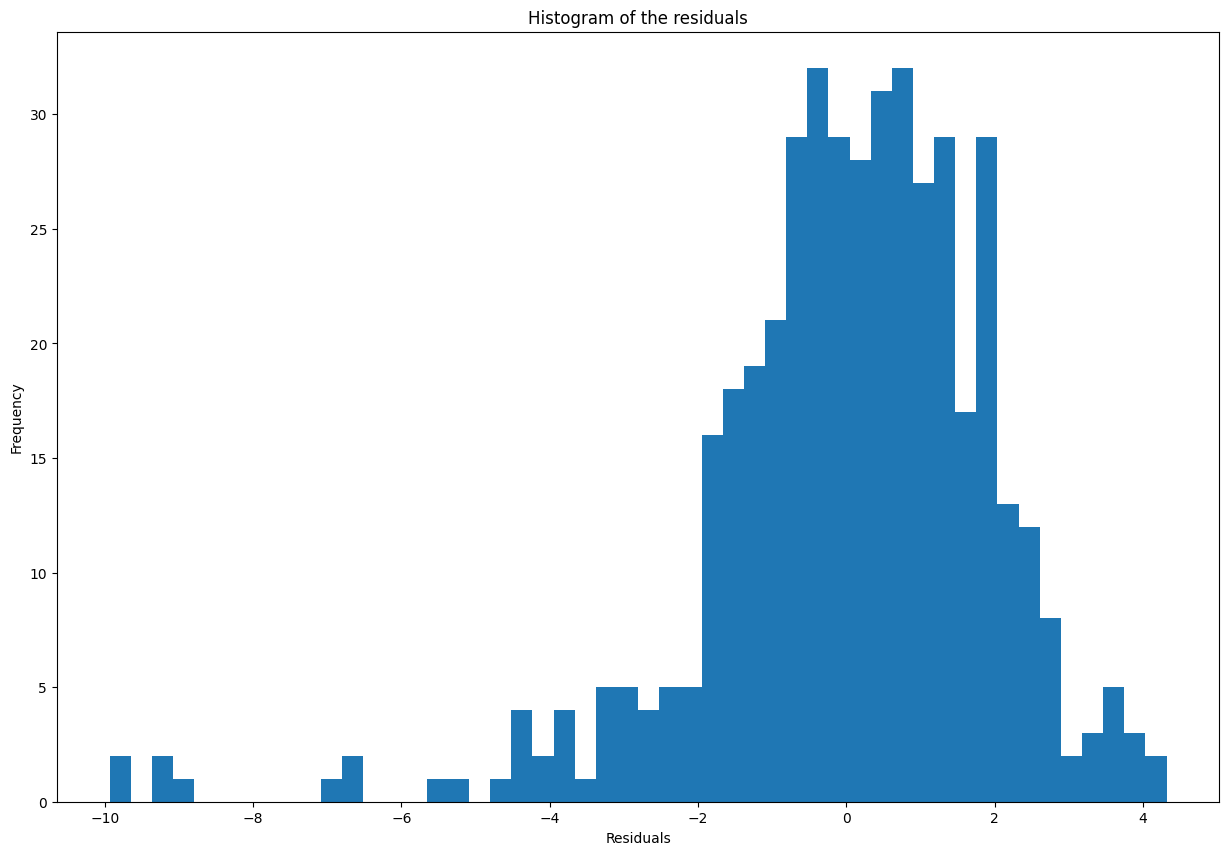

The mean is -1.676313682591456e-14
The standard deviation is 2.006250156741641
The p-value of the K-S test is 0.0034083235825651584


In [42]:
import statsmodels.api as sm
import seaborn as sns

# load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost_log.csv")
X = df[["log(Tons (SUM)_export)", "log(Tons (SUM)_import)", "log(Average Cost)"]]
y = df["log(Nominal Value (SUM))"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# plot the distribution of the residuals
plt.figure(figsize=(15, 10))
plt.hist(model.resid, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of the residuals")
plt.show()

# fit the residuals to a normal distribution
mean, std = stats.norm.fit(model.resid)
print("The mean is", mean)
print("The standard deviation is", std)
# do K-S test on the residuals
statistic, pvalue = stats.kstest(model.resid, "norm", args=(mean, std))
print("The p-value of the K-S test is", pvalue)

In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost_log.csv")
# take the average value of "log(Tons (SUM))" column
average = df["log(Tons (SUM))"].mean()
print(average)

# 真实值
y_true = df["log(Tons (SUM))"]

# 计算真实值的均值
mean_value = np.mean(y_true)

# 创建一个全是均值的数组，作为常数信号模型的“预测值”
y_pred_mean = np.full(shape=y_true.shape, fill_value=mean_value)

# 计算MSE
mse = mean_squared_error(y_true, y_pred_mean)

# 计算R²
r2 = r2_score(y_true, y_pred_mean)

print("MSE for constant signal model:", mse)
print("R² for constant signal model:", r2)

11.787582636161932
MSE for constant signal model: 9.823687961169
R² for constant signal model: 0.0


In [34]:
# load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost_log.csv")
print(df.columns)

# do regression on the data
regression = LinearRegression()
X = df[["log(Tons (SUM)_export)", "log(Tons (SUM)_import)", "log(Average Cost)"]]
Y = df["log(Tons (SUM))"]
regression.fit(X, Y)
# print the coefficients
print("The coefficients are", regression.coef_)
# print the intercept
print("The intercept is", regression.intercept_)
# print the R^2 value
print("The R^2 value is", regression.score(X, Y))
# print the mean squared error
print("The mean squared error is", mean_squared_error(Y, regression.predict(X)))

Index(['log(Nominal Value (SUM))', 'log(Tons (SUM))',
       'log(Nominal Value (SUM)_export)', 'log(Tons (SUM)_export)',
       'log(Nominal Value (SUM)_import)', 'log(Tons (SUM)_import)',
       'log(Nominal Value (SUM)_product)', 'log(Tons (SUM)_product)',
       'log(Average Cost)'],
      dtype='object')
The coefficients are [ 1.2498243   1.03033004 -3.50530686]
The intercept is -11.739202030323856
The R^2 value is 0.5442987287138572
The mean squared error is 4.476667092623089


In [35]:
# load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost_log.csv")
print(df.columns)

# do regression on the data
regression = LinearRegression()
X = df[["log(Tons (SUM)_export)", "log(Tons (SUM)_import)", "log(Average Cost)"]]
Y = df["log(Nominal Value (SUM))"]
regression.fit(X, Y)
# print the coefficients
print("The coefficients are", regression.coef_)
# print the intercept
print("The intercept is", regression.intercept_)
# print the R^2 value
print("The R^2 value is", regression.score(X, Y))
# print the mean squared error
print("The mean squared error is", mean_squared_error(Y, regression.predict(X)))

Index(['log(Nominal Value (SUM))', 'log(Tons (SUM))',
       'log(Nominal Value (SUM)_export)', 'log(Tons (SUM)_export)',
       'log(Nominal Value (SUM)_import)', 'log(Tons (SUM)_import)',
       'log(Nominal Value (SUM)_product)', 'log(Tons (SUM)_product)',
       'log(Average Cost)'],
      dtype='object')
The coefficients are [ 1.1031391   0.92562611 -3.65963178]
The intercept is 0.2557647028058092
The R^2 value is 0.5520147515740853
The mean squared error is 4.025039691425859


In [36]:
# load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost_log.csv")
print(df.columns)

# do regression on the data
regression = LinearRegression()
X = df[["log(Nominal Value (SUM)_export)", "log(Nominal Value (SUM)_import)", "log(Average Cost)"]]
Y = df["log(Nominal Value (SUM))"]
regression.fit(X, Y)
# print the coefficients
print("The coefficients are", regression.coef_)
# print the intercept
print("The intercept is", regression.intercept_)
# print the R^2 value
print("The R^2 value is", regression.score(X, Y))
# print the mean squared error
print("The mean squared error is", mean_squared_error(Y, regression.predict(X)))

Index(['log(Nominal Value (SUM))', 'log(Tons (SUM))',
       'log(Nominal Value (SUM)_export)', 'log(Tons (SUM)_export)',
       'log(Nominal Value (SUM)_import)', 'log(Tons (SUM)_import)',
       'log(Nominal Value (SUM)_product)', 'log(Tons (SUM)_product)',
       'log(Average Cost)'],
      dtype='object')
The coefficients are [ 1.22773761  1.01390969 -3.35059162]
The intercept is -19.921655378254567
The R^2 value is 0.5391522932279768
The mean squared error is 4.140605785520051


In [37]:
# load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost_log.csv")
print(df.columns)

# do regression on the data
regression = LinearRegression()
X = df[["log(Nominal Value (SUM)_export)", "log(Nominal Value (SUM)_import)", "log(Average Cost)"]]
Y = df["log(Tons (SUM))"]
regression.fit(X, Y)
# print the coefficients
print("The coefficients are", regression.coef_)
# print the intercept
print("The intercept is", regression.intercept_)
# print the R^2 value
print("The R^2 value is", regression.score(X, Y))
# print the mean squared error
print("The mean squared error is", mean_squared_error(Y, regression.predict(X)))

Index(['log(Nominal Value (SUM))', 'log(Tons (SUM))',
       'log(Nominal Value (SUM)_export)', 'log(Tons (SUM)_export)',
       'log(Nominal Value (SUM)_import)', 'log(Tons (SUM)_import)',
       'log(Nominal Value (SUM)_product)', 'log(Tons (SUM)_product)',
       'log(Average Cost)'],
      dtype='object')
The coefficients are [ 1.29628337  1.12426648 -3.17997079]
The intercept is -31.91211928798852
The R^2 value is 0.514225357304458
The mean squared error is 4.7720985092893695


In [68]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.datasets import make_regression

# load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost.csv")

# create a new df with the first 2 columns same with df
df_1 = df[["Export_country", "Import_country","Nominal Value (SUM)"]]
# load "originalData\Copy of dist_cepii.xlsx" whose columns are 'iso_o', 'iso_d', 'dist', 'distcap', 'distw', 'distwces'
df_distance = pd.read_excel("originalData/Copy of dist_cepii.xlsx",sheet_name="top exporters")
print(df_distance.columns)
# rename the columns
df_distance.columns = ["Export_country", "Import_country", "Distance", "Distance capital", "Distance weighted with popuation", "Distance weighted with population_1"]
# save the data to a csv file
df_distance.to_csv("finalVersion/distance.csv", index=False)
# merge the df_distance into the df_pair with the columns "Export_country" and "Import_country"
df_1 = df_1.merge(df_distance, how="left", left_on=["Export_country", "Import_country"], right_on=["Export_country", "Import_country"], suffixes=("", "_distance"))
# only keep the columns "Export_country", "Import_country", "Distance weighted with popuation"
df_1 = df_1[["Export_country", "Import_country","Nominal Value (SUM)", "Distance weighted with popuation"]]

# load the data from "originalData/GDP.xls"
df_gdp = pd.read_excel("originalData/GDP.xlsx", sheet_name="top exporter") # whose columns are "Country", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022"
# calculate the average GDP of each country
df_gdp["Average GDP"] = df_gdp.iloc[:, 1:].mean(axis=1)

# add the "Average GDP_exporter" and "Average GDP_importer" with "Average GDP" column
df_1 = df_1.merge(df_gdp, how="left", left_on=["Export_country"], right_on=["Country"], suffixes=("", "_exporter"))
df_1 = df_1.merge(df_gdp, how="left", left_on=["Import_country"], right_on=["Country"], suffixes=("", "_importer"))
# keeps only the first 4 columns and "Average GDP","Average GDP_importer"
df_1 = df_1[["Export_country", "Import_country","Nominal Value (SUM)", "Distance weighted with popuation", "Average GDP", "Average GDP_importer"]]
# rename the "Average GDP" to "Average GDP_exporter"
df_1 = df_1.rename(columns={"Average GDP": "Average GDP_exporter"})

df_1.head()

# take the log of the last 4 columns
df_1["log(Nominal Value (SUM))"] = np.log(df_1["Nominal Value (SUM)"])
df_1["log(Distance weighted with popuation)"] = np.log(df_1["Distance weighted with popuation"])
df_1["log(Average GDP_exporter)"] = np.log(df_1["Average GDP_exporter"])
df_1["log(Average GDP_importer)"] = np.log(df_1["Average GDP_importer"])

# keep the first 2 and last 4 columns
df_1 = df_1[["Export_country", "Import_country", "log(Nominal Value (SUM))", "log(Distance weighted with popuation)", "log(Average GDP_exporter)", "log(Average GDP_importer)"]]
df_1.head()


Index(['iso_o', 'iso_d', 'dist', 'distcap', 'distw', 'distwces'], dtype='object')


Export_country    Import_country  log(Nominal Value (SUM))  \
0        Austria           Belgium                 19.646733   
1        Austria            Brazil                 18.027536   
2        Austria            Canada                 14.808734   
3        Austria  China (mainland)                 18.006055   
4        Austria            France                 20.663108   

   log(Distance weighted with popuation)  log(Average GDP_exporter)  \
0                               6.754800                  26.799237   
1                               9.156780                  26.799237   
2                               8.863627                  26.799237   
3                               8.978303                  26.799237   
4                               6.883226                  26.799237   

   log(Average GDP_importer)  
0                  26.993868  
1                  28.295065  
2                  28.200859  
3                  30.221021  
4                  28.627262

The mean is 18.75200641051488
The mean is 18.634475839658332
The mean is 18.685470908024225
The mean is 18.657225596153626
The mean is 18.7331475493076
The mean is 18.71685090195462
The mean is 18.699321534670535
The mean is 18.666759958459586
The mean is 18.646541290227557
The mean is 18.711174166347398
The mean is 18.667961998477693
The mean is 18.774388955829398
The mean is 18.68356152423187
The mean is 18.65195466294582
The mean is 18.651694831848058
Constant Model MSE: 9.024993642129553 ± 4.6718020748209135
Model 1 MSE: 4.239401933462606 ± 2.7176880777332793
Model 2 MSE: 6.014058562791154 ± 3.7395665713278547


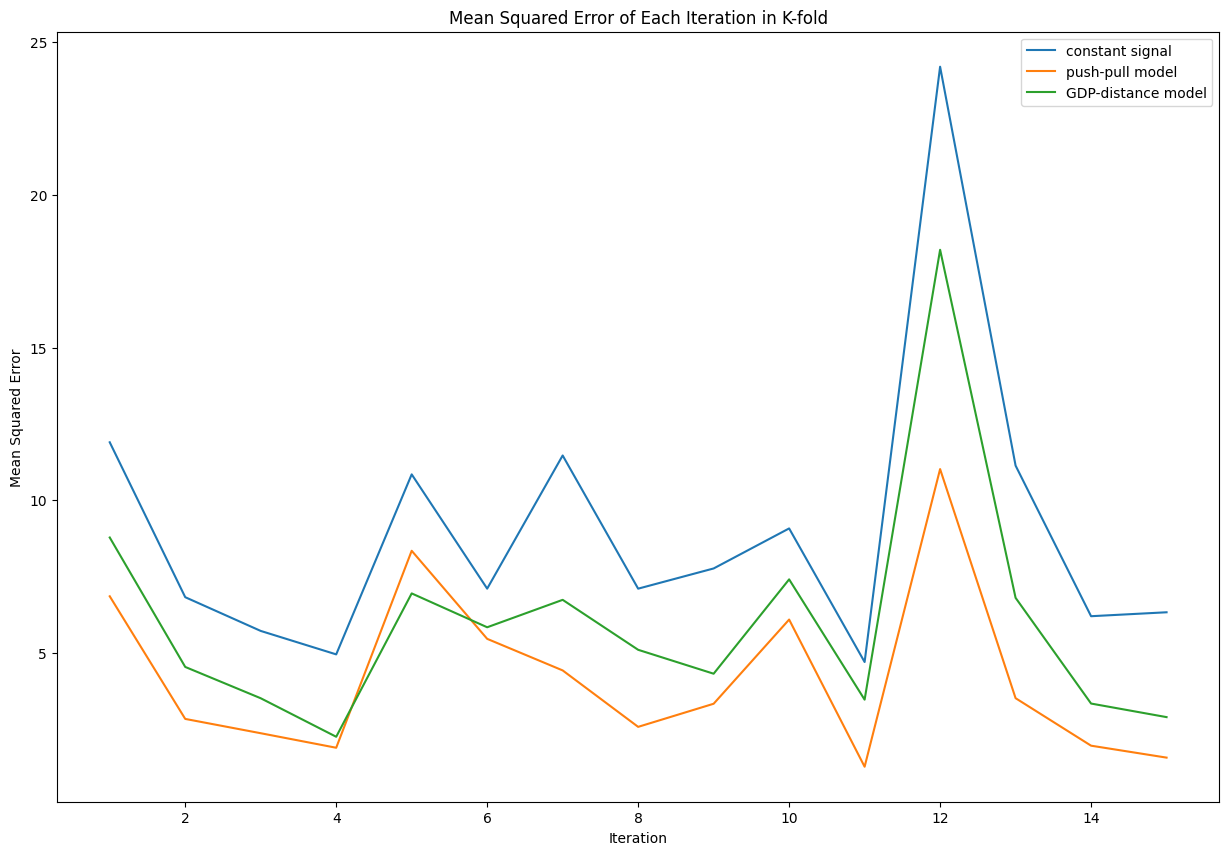

In [69]:
# load the data from the csv file
df = pd.read_csv("finalVersion/pair_pulling_pushing_tradeCost_log.csv")

# 定义常数模型类
class ConstantModel(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        self.mean_ = np.mean(y)
        print("The mean is", self.mean_ )
        return self

    def predict(self, X):
        return np.full(shape=(len(X),), fill_value=self.mean_)

# print(df["log(Nominal Value (SUM))"])
# print(df_1["log(Nominal Value (SUM))"])

y = df["log(Nominal Value (SUM))"]

X1 = df[["log(Nominal Value (SUM)_export)", "log(Nominal Value (SUM)_import)", "log(Average Cost)"]]
X2 = df_1[["log(Average GDP_exporter)","log(Average GDP_importer)","log(Distance weighted with popuation)"]]

kf = KFold(n_splits=15, shuffle=True, random_state=57)

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# constant signal
constant_model = ConstantModel()
scores_constant = cross_val_score(constant_model, X, y, cv=kf, scoring=mse_scorer)

# push-pull model
model1 = LinearRegression()
scores_model1 = cross_val_score(model1, X1, y, cv=kf, scoring=mse_scorer)

# GDP-distance model
model2 = LinearRegression()
scores_model2 = cross_val_score(model2, X2, y, cv=kf, scoring=mse_scorer)

# 输出每个模型的性能
print("Constant Model MSE:", -scores_constant.mean(), "±", scores_constant.std())
print("Model 1 MSE:", -scores_model1.mean(), "±", scores_model1.std())
print("Model 2 MSE:", -scores_model2.mean(), "±", scores_model2.std())

# plot the mse of each iteration of the "constant signal", "push-pull model" and "GDP-distance model"
plt.figure(figsize=(15, 10))
plt.plot(range(1, 16), -scores_constant, label="constant signal")
plt.plot(range(1, 16), -scores_model1, label="push-pull model")
plt.plot(range(1, 16), -scores_model2, label="GDP-distance model")
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error of Each Iteration in K-fold")
plt.legend()
plt.show()



